In [1]:
# /// script
# requires-python = ">=3.12"
# dependencies = [
#     "cmocean",
#     "flox",
#     "gsw",
#     "matplotlib",
#     "numpy",
#     "pandas",
#     "scipy",
#     "statsmodels",
#     "sympy",
#     "tqdm",
#     "xarray[io,accel,parallel]",
# ]
# ///

In [2]:
from __future__ import annotations

import calendar
import os
import re
import string
from pathlib import Path
from typing import TYPE_CHECKING

import gsw
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xarray as xr
from cmocean import cm as cmo
from cycler import cycler
from flox.xarray import xarray_reduce
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
from scipy.integrate import simpson
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.signal import filtfilt, find_peaks, firwin, savgol_filter
from scipy.stats import distributions
from sympy import Piecewise, integrate, symbols
from tqdm import tqdm as tq

import functions.util as util

if TYPE_CHECKING:
    from numpy.typing import NDArray

In [3]:
savefigs = False
show_bottle_comparisons = False
notebook_dir = Path().resolve()

# matplotlib style
plt.style.use("default")
plt.style.use(os.path.join(notebook_dir, "../misc/mplstyles/jgr_manuscript.mplstyle"))

# For confidence intervals
ci = 95
norm = (
    distributions.norm()
)  # for use with n > 30 so Student's t can be approximated by normal distribution
qg_norm = norm.isf((1 - ci / 100) / 2)

# Data Analysis

## Nitrate Data Analysis

Nitrate data has already been ran through quality control in the downloader script. There is a baseline subtracted from each deployment independently determined through a combinatoin of overlapping NHL/OOI bottle samples and the nitrate-density relationship. A daily mean is taken on the data. Several "bad" deployments are dropped.

In [4]:
nitrate = xr.open_dataset(
    os.path.join(
        notebook_dir,
        "../data/CE01ISSP/CE01ISSP_nitrate_binned_baseline_subtracted_2014-04-17_2023-09-17.nc",
    )
)
deployments = np.unique(nitrate.deployment.values)[
    ~np.isnan(np.unique(nitrate.deployment.values))
]
# rename for convenience
nitrate = nitrate.rename(
    {"salinity_corrected_nitrate": "nitrate", "sigma_theta": "density"}
)
nitrate["depth_integrated_nitrate"] = (
    ["time"],
    xr.apply_ufunc(
        lambda x, y: np.array(
            [
                np.trapezoid(yi[~np.isnan(yi)], x[~np.isnan(yi)])
                if len(yi[~np.isnan(yi)]) > 0
                else np.nan
                for yi in y
            ]
        ),
        nitrate.depth.values,
        nitrate.nitrate.values,
    ),
)
nitrate = nitrate.resample(time="1D").median()

nitrate["dndt"] = nitrate["depth_integrated_nitrate"].differentiate(
    "time", datetime_unit="s"
)
nitrate = nitrate.dropna("time", how="all", subset=["nitrate"])

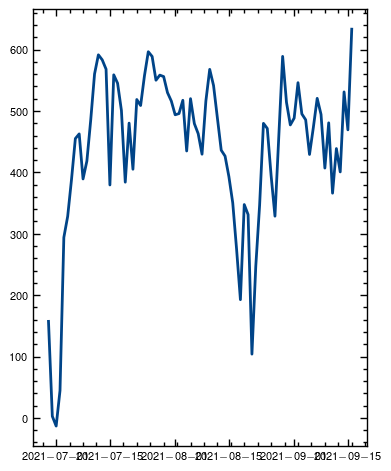

In [5]:
plt.plot(
    nitrate.where(nitrate.deployment == 18, drop=True)["depth_integrated_nitrate"].time,
    nitrate.where(nitrate.deployment == 18, drop=True)["depth_integrated_nitrate"].mean(
        dim="depth"
    ),
)

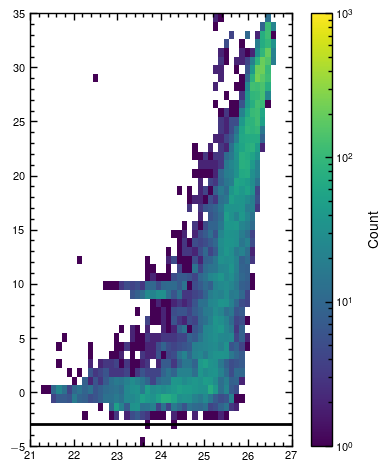

In [6]:
hist_total = np.zeros((50, 50))
x_bins = np.linspace(21, 27, 51)
y_bins = np.linspace(-5, 35, 51)
for i, d in enumerate(nitrate.depth):
    temp = nitrate.sel(depth=d).where(
        (~np.isnan(nitrate.density.sel(depth=d)))
        & (~np.isnan(nitrate.nitrate.sel(depth=d))),
        drop=True,
    )
    hist, _, _ = np.histogram2d(temp.density, temp.nitrate, bins=[x_bins, y_bins])
    # hist[hist == 0] = np.nan
    hist_total += hist
hist_total[hist_total == 0] = np.nan
plt.pcolormesh(
    x_bins,
    y_bins,
    hist_total.T,
    cmap="viridis",
    norm=mcolors.LogNorm(vmin=1, vmax=1000),
)
plt.colorbar(label="Count")
# plt.xlim(15, 30)
plt.axhline(-3, c="k", lw=2)

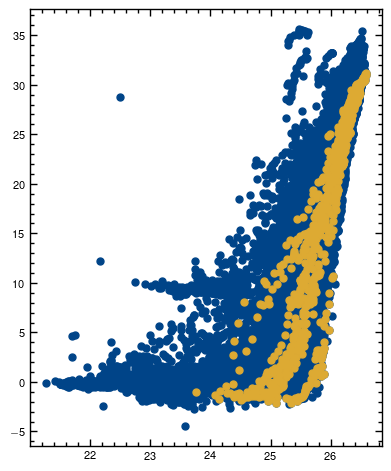

In [7]:
plt.scatter(nitrate.density, nitrate.nitrate)
plt.scatter(
    nitrate.where(nitrate.deployment == 17).density,
    nitrate.where(nitrate.deployment == 17).nitrate,
)

## Midshelf Nitrate Analysis

Nitrate data has already been ran through quality control in the downloader script. There is a baseline subtracted from each deployment independently determined by assuming that the surface bin should have a mean nitrate of zero in each deployment. A daily mean is taken on the data. Several "bad" deployments are dropped.

In [8]:
midshelf_nitrate = xr.open_dataset(
    os.path.join(
        notebook_dir,
        "../data/CE02SHSP/CE02SHSP_nitrate_binned_baseline_subtracted_2015-03-18_2023-09-23.nc",
    )
)

# deployment 18 has some odd very negative data that isn't removed in QC, and a shift halfway through deployment
midshelf_nitrate = midshelf_nitrate.where(midshelf_nitrate.deployment != 18, drop=True)

midshelf_nitrate = midshelf_nitrate.rename(
    {"salinity_corrected_nitrate": "nitrate", "sigma_theta": "density"}
)

midshelf_nitrate["depth_integrated_nitrate"] = (
    ["time"],
    xr.apply_ufunc(
        lambda x, y: np.array(
            [
                np.trapezoid(yi[~np.isnan(yi)], x[~np.isnan(yi)])
                if len(yi[~np.isnan(yi)]) > 40
                else np.nan
                for yi in y
            ]
        ),
        midshelf_nitrate.depth.values,
        midshelf_nitrate.nitrate.values,
    ),
)

midshelf_nitrate = midshelf_nitrate.resample(time="1D").median()

midshelf_nitrate["dndt"] = midshelf_nitrate["depth_integrated_nitrate"].differentiate(
    "time", datetime_unit="s"
)

## Wind Data Analysis

Wind data comes from the output of the wind downloader and is already rotated and the wind stress calculated using pyCOARE.

In [9]:
wind = xr.open_dataset("../data/NDBC_46050/46050_wind_binned.nc", decode_timedelta=True)
wind = wind.drop_duplicates("time").resample({"time": "1D"}).mean()
wind["day_num"] = (["time"], np.arange(len(wind.time)))
avg_len = 8
fout = np.nan * np.zeros(len(wind["day_num"]))
for i, f in enumerate(tq(fout)):
    temp = util.ws_integrand(
        wind["day_num"].values[i - avg_len * 5 : i],
        wind["day_num"].values[i],
        wind["coare_y"].values[i - avg_len * 5 : i],
        avg_len,
        rho=1,
    )
    mask = ~np.isnan(temp)
    if temp.size == 0:
        continue
    if np.any(np.isnan(wind.coare_y[i - avg_len * 5 : i])):
        continue
    fout[i] = (
        simpson(temp[mask], x=wind["day_num"].values[i - avg_len * 5 : i][mask])
        / avg_len
    )
wind["w8d"] = (["time"], fout)
avg_len = 5
fout = np.nan * np.zeros(len(wind["day_num"]))
for i, f in enumerate(tq(fout)):
    temp = util.ws_integrand(
        wind["day_num"].values[i - avg_len * 5 : i],
        wind["day_num"].values[i],
        wind["coare_y"].values[i - avg_len * 5 : i],
        avg_len,
        rho=1,
    )
    mask = ~np.isnan(temp)
    if temp.size == 0:
        continue
    if np.any(np.isnan(wind.coare_y[i - avg_len * 5 : i])):
        continue
    fout[i] = (
        simpson(temp[mask], x=wind["day_num"].values[i - avg_len * 5 : i][mask])
        / avg_len
    )
wind["w5d"] = (["time"], fout)

100%|██████████| 11642/11642 [00:03<00:00, 2985.46it/s]


## Ship Data Analysis

Gets ship data from EA cruises and NHL cruises for both CTD and nitrate data. Plots profiles of the closest in time profiles to the bottle samples. Finally, plots nitrate-density relationship of profiler data overlaid with bottle sample data. Repeats for the midshelf site with the notable exception that no NHL cruise nitrate data is available.

In [10]:
# loading ooi cruise data df = ooi cruise data
fileList = os.listdir(os.path.join(notebook_dir, "../data/ship/ea_ship_data/"))
df_list = []
col_names = [
    "Station",
    "Start Time [UTC]",
    "Start Latitude [degrees]",
    "Start Longitude [degrees]",
    "CTD Pressure [db]",
    "CTD Salinity 1 [psu]",
    "CTD Salinity 2 [psu]",
    "CTD Temperature 1 [deg C]",
    "CTD Temperature 2 [deg C]",
    "Discrete Nitrate [uM]",
]
for f in fileList:
    df_temp = pd.read_csv(
        os.path.join(notebook_dir, "../data/ship/ea_ship_data/", f), usecols=col_names
    )
    rows = df_temp.loc[df_temp["Station"] == "CE01"]
    df_list.append(rows)

ooi_crse = pd.concat(df_list)
ooi_crse = ooi_crse.rename(
    columns={
        "Start Time [UTC]": "time",
        "Start Latitude [degrees]": "lat",
        "Start Longitude [degrees]": "lon",
        "CTD Pressure [db]": "pressure",
        "CTD Salinity 1 [psu]": "sal1",
        "CTD Salinity 2 [psu]": "sal2",
        "CTD Temperature 1 [deg C]": "temp1",
        "CTD Temperature 2 [deg C]": "temp2",
        "Discrete Nitrate [uM]": "nitrate",
    }
)
ooi_crse["time"] = pd.to_datetime(ooi_crse["time"])
ooi_cruse = ooi_crse.set_index(["time", "pressure"])
ooi_crse = ooi_crse.iloc[np.unique(ooi_cruse.index, return_index=True)[1]]
ooi_crse = ooi_crse.set_index(["time", "pressure"])
ooi_crse = ooi_crse.to_xarray()
ooi_crse["time"] = pd.DatetimeIndex(ooi_crse["time"].values)
ooi_crse = ooi_crse.where(ooi_crse.nitrate > -100, drop=True)
ooi_crse["pot_density_anom"] = gsw.density.sigma0(
    ooi_crse["sal1"],
    gsw.conversions.CT_from_t(
        ooi_crse["sal1"], ooi_crse["temp1"], ooi_crse["pressure"]
    ),
)

In [11]:
temp = nitrate.sel(time=ooi_crse.time, method="nearest")
ooi_overlapping_bottles = []
ooi_notoverlapping_bottles = []
prof_overlapping_bottles = []
prof_notoverlapping_bottles = []
for i, (t1, t2) in enumerate(zip(temp.time.values, ooi_crse.time.values)):
    if np.abs((t1 - t2) / np.timedelta64(1, "D")) < 1:
        ooi_overlapping_bottles.append(ooi_crse.isel(time=i))
        prof_overlapping_bottles.append(
            nitrate.sel(time=t1 - np.timedelta64(1, "D"), method="nearest")
        )
    else:
        ooi_notoverlapping_bottles.append(ooi_crse.isel(time=i))
        prof_notoverlapping_bottles.append(temp.isel(time=i))
print(
    f"{len(ooi_overlapping_bottles)} out of {len(ooi_overlapping_bottles) + len(ooi_notoverlapping_bottles)} OOI bottle samples overlap with profiler deployments within one day."
)
print(
    f"{len(ooi_notoverlapping_bottles)} out of {len(ooi_overlapping_bottles) + len(ooi_notoverlapping_bottles)} OOI bottle samples do not overlap with profiler deployments within one day."
)
ooi_overlapping_bottles = xr.concat(ooi_overlapping_bottles, dim="time")
prof_overlapping_bottles = xr.concat(prof_overlapping_bottles, dim="time")

6 out of 26 OOI bottle samples overlap with profiler deployments within one day.
20 out of 26 OOI bottle samples do not overlap with profiler deployments within one day.


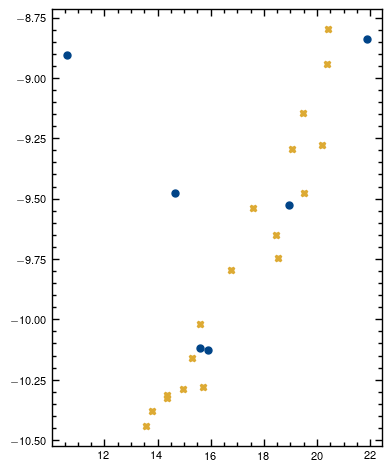

In [12]:
plt.plot(
    ooi_overlapping_bottles.isel(time=2).nitrate,
    -ooi_overlapping_bottles.isel(time=2).temp1,
    "o",
)
plt.plot(
    prof_overlapping_bottles.isel(time=2).nitrate,
    -prof_overlapping_bottles.isel(time=2).temperature,
    "X",
)

In [13]:
ooi_crse.nitrate.max()

<xarray.DataArray 'nitrate' ()> Size: 8B
array(31.4519)

In [14]:
# ctd data from NH, nhl_crse_ctd = nh line cruise ctd data
nhl_crse_ctd = xr.open_dataset(
    os.path.join(
        notebook_dir,
        "../data/NHL_Gridded/newport_hydrographic_line_gridded_sections.nc",
    )
)
# fix some xr stuff, assign coords, remove unnecessary dims, etc
nhl_crse_ctd = nhl_crse_ctd.assign_coords(
    date=nhl_crse_ctd["time"].astype("datetime64[D]")
)
nhl_crse_ctd = nhl_crse_ctd.swap_dims({"time": "date"})
nhl_crse_ctd["longitude"] = nhl_crse_ctd["longitude"] - 360
nhl_crse_ctd = nhl_crse_ctd.squeeze()

# nitrate data from NH line cruises, nhl_crse_nit = nh line cruise nitrate data
nhl_crse_nit = pd.read_csv(os.path.join(notebook_dir, "../data/ship/NH_line_data.csv"))

# bin the bottle sample data by date and pressure
nh_pressure_grid = nhl_crse_ctd["pressure"]
nh_time_grid = nhl_crse_ctd["date"]
nhl_crse_nit["Sample Date"] = pd.to_datetime(
    nhl_crse_nit["Sample Date"].values, unit="ns"
)

nitr_tbin, pres_tbin, time_tbin, long_tbin, stat_tbin = [], [], [], [], []
for i, t in enumerate(nhl_crse_ctd["date"].values):
    # find places where nitrate data lines up with ctd data
    # need exact date matches - don't want nearest neighbor for this step
    time_mask = np.where(nhl_crse_nit["Sample Date"] == t)
    for n, d, s, p, lon in zip(
        nhl_crse_nit["NO3 (um)"].values[time_mask],
        nhl_crse_nit["Sample Date"].values[time_mask],
        nhl_crse_nit["Station"].values[time_mask],
        nhl_crse_nit["DepthorPressure (m)"].values[time_mask],
        nhl_crse_nit["Longitude"].values[time_mask],
    ):
        nitr_tbin.append(n)
        pres_tbin.append(p)
        time_tbin.append(d)
        long_tbin.append(lon)
        stat_tbin.append(s)

# make numpy arrays
nitr_tbin, pres_tbin, time_tbin, long_tbin, stat_tbin = (
    np.array(nitr_tbin),
    np.array(pres_tbin),
    np.array(time_tbin),
    np.array(long_tbin),
    np.array(stat_tbin),
)

# make dataarrays for vectorized indexing, doesn't work with np arrays for some reason
pres_targ = xr.DataArray(pres_tbin, dims="date")
time_targ = xr.DataArray(time_tbin, dims="date")
long_targ = xr.DataArray(long_tbin, dims="date")

# bin the ctd data using the arrays from the bottle sample binning, using nearest binning method, e.g., if pressure=0 from bottle, then pressure=1 from ship since this is closest.
nhl_crse = nhl_crse_ctd.sel(
    date=time_targ, pressure=pres_targ, longitude=long_targ, method="nearest"
)

# add nitrate and station
nhl_crse["nitrate"] = (("date"), nitr_tbin)
nhl_crse["station"] = (("date"), stat_tbin)

# view created xarray
nhl_crse_nh01 = nhl_crse.where(nhl_crse.station == "NH01", drop=True)
nhl_crse_nh01 = nhl_crse_nh01.swap_dims({"date": "time"})

In [15]:
nhl_crse_nh01.nitrate.max()

<xarray.DataArray 'nitrate' ()> Size: 8B
array(32.9843)
Coordinates:
    latitude  float32 4B 44.65

In [16]:
temp = nitrate.sel(time=nhl_crse_nh01.time, method="nearest")
nhl_overlapping_bottles = []
nhl_notoverlapping_bottles = []
prof_overlapping_bottles = []
prof_notoverlapping_bottles = []
for i, (t1, t2) in enumerate(zip(temp.time.values, nhl_crse_nh01.time.values)):
    if np.abs((t1 - t2) / np.timedelta64(1, "D")) < 1:
        # print((t1 - t2)/np.timedelta64(1, 'D'))
        nhl_overlapping_bottles.append(nhl_crse_nh01.isel(time=i))
        prof_overlapping_bottles.append(nitrate.sel(time=t1, method="nearest"))
    else:
        nhl_notoverlapping_bottles.append(nhl_crse_nh01.isel(time=i))
        prof_notoverlapping_bottles.append(temp.isel(time=i))
nhl_overlapping_bottles = xr.concat(nhl_overlapping_bottles, dim="time")
nhl_notoverlapping_bottles = xr.concat(nhl_notoverlapping_bottles, dim="time")
prof_overlapping_bottles = xr.concat(prof_overlapping_bottles, dim="time")
print(
    f"{len(np.unique(nhl_overlapping_bottles.date))} out of {len(np.unique(nhl_overlapping_bottles.date)) + len(np.unique(nhl_notoverlapping_bottles.date))} NHL bottle samples overlap with profiler deployments within one day."
)
print(
    f"{len(np.unique(nhl_notoverlapping_bottles.date))} out of {len(np.unique(nhl_overlapping_bottles.date)) + len(np.unique(nhl_notoverlapping_bottles.date))} NHL bottle samples do not overlap with profiler deployments within one day."
)

21 out of 86 NHL bottle samples overlap with profiler deployments within one day.
65 out of 86 NHL bottle samples do not overlap with profiler deployments within one day.


In [17]:
if show_bottle_comparisons:
    temp = nhl_overlapping_bottles.isel(time=0).date
    for i in range(len(nhl_overlapping_bottles.time)):
        if temp != nhl_overlapping_bottles.isel(time=i).date:
            plt.figure()
        plt.plot(
            nhl_overlapping_bottles.isel(time=i).nitrate,
            nhl_overlapping_bottles.isel(time=i).temperature,
            "o",
        )
        plt.plot(
            prof_overlapping_bottles.isel(time=i).nitrate,
            prof_overlapping_bottles.isel(time=i).temperature,
            "X",
        )
        plt.annotate(
            f"{nhl_overlapping_bottles.isel(time=i).date.values}\n{np.unique(prof_overlapping_bottles.isel(time=i).deployment.values)}",
            (0.9, 0.9),
            xycoords="axes fraction",
        )
        temp = nhl_overlapping_bottles.isel(time=i).date

In [18]:
nhl_crse_inshore = nhl_crse
ooi_crse_inshore = ooi_crse

Mean N below 25.8 sigma: 6.761072682611403
Mean N above 25.8 sigma: 25.888516655563475


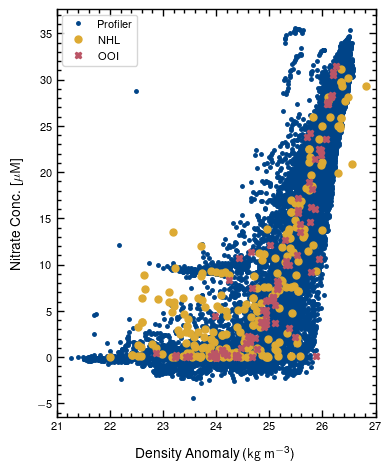

In [19]:
plt.plot(nitrate.density, nitrate.nitrate, ".", color="#004488", label="Profiler")
plt.plot(
    nhl_crse.potential_density, nhl_crse.nitrate, "o", color="#DDAA33", label="NHL"
)
plt.plot(ooi_crse.pot_density_anom, ooi_crse.nitrate, "X", color="#BB5566", label="OOI")
plt.xlim(21, 27)
plt.xlabel("Density Anomaly ($\\mathsf{kg \\; m^{-3}}$)")
plt.ylabel("Nitrate Conc. [$\\mathsf{\\mu M}$]")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(
    zip(labels, handles)
)  # dicts can't have duplicate keys, avoids duplicate legend entries
plt.legend(by_label.values(), by_label.keys())
# plt.savefig('../../figs/nitrate-wind_manuscript_figs/inshore_nitrate-denisty.eps', format='eps')
print(
    f"Mean N below 25.8 sigma: {np.nanmean(nitrate.where(nitrate.density < 25.8).nitrate)}"
)
print(
    f"Mean N above 25.8 sigma: {np.nanmean(nitrate.where(nitrate.density > 25.8).nitrate)}"
)
pass

### Midshelf

In [20]:
# loading ooi cruise data df = ooi cruise data
fileList = os.listdir(os.path.join(notebook_dir, "../data/ship/ea_ship_data/"))
df_list = []
col_names = [
    "Station",
    "Start Time [UTC]",
    "Start Latitude [degrees]",
    "Start Longitude [degrees]",
    "CTD Pressure [db]",
    "CTD Salinity 1 [psu]",
    "CTD Salinity 2 [psu]",
    "CTD Temperature 1 [deg C]",
    "CTD Temperature 2 [deg C]",
    "Discrete Nitrate [uM]",
]
for f in fileList:
    df_temp = pd.read_csv(
        os.path.join(notebook_dir, "../data/ship/ea_ship_data/", f), usecols=col_names
    )
    rows = df_temp.loc[df_temp["Station"] == "CE02"]
    df_list.append(rows)

ooi_crse = pd.concat(df_list)
ooi_crse = ooi_crse.rename(
    columns={
        "Start Time [UTC]": "time",
        "Start Latitude [degrees]": "lat",
        "Start Longitude [degrees]": "lon",
        "CTD Pressure [db]": "pressure",
        "CTD Salinity 1 [psu]": "sal1",
        "CTD Salinity 2 [psu]": "sal2",
        "CTD Temperature 1 [deg C]": "temp1",
        "CTD Temperature 2 [deg C]": "temp2",
        "Discrete Nitrate [uM]": "nitrate",
    }
)
ooi_crse["time"] = pd.to_datetime(ooi_crse["time"])
ooi_cruse = ooi_crse.set_index(["time", "pressure"])
ooi_crse = ooi_crse.iloc[np.unique(ooi_cruse.index, return_index=True)[1]]
ooi_crse = ooi_crse.set_index(["time", "pressure"])
ooi_crse = ooi_crse.to_xarray()
ooi_crse["time"] = pd.DatetimeIndex(ooi_crse["time"].values)
ooi_crse = ooi_crse.where(ooi_crse.nitrate > -100, drop=True)
ooi_crse["pot_density_anom"] = gsw.density.sigma0(
    ooi_crse["sal1"],
    gsw.conversions.CT_from_t(
        ooi_crse["sal1"], ooi_crse["temp1"], ooi_crse["pressure"]
    ),
)

In [21]:
temp = midshelf_nitrate.sel(time=ooi_crse.time, method="nearest")
ooi_overlapping_bottles = []
ooi_notoverlapping_bottles = []
prof_overlapping_bottles = []
prof_notoverlapping_bottles = []
for i, (t1, t2) in enumerate(zip(temp.time.values, ooi_crse.time.values)):
    if np.abs((t1 - t2) / np.timedelta64(1, "D")) < 1:
        ooi_overlapping_bottles.append(ooi_crse.isel(time=i))
        prof_overlapping_bottles.append(
            nitrate.sel(time=t1 - np.timedelta64(1, "D"), method="nearest")
        )
    else:
        ooi_notoverlapping_bottles.append(ooi_crse.isel(time=i))
        prof_notoverlapping_bottles.append(temp.isel(time=i))
print(
    f"{len(ooi_overlapping_bottles)} out of "
    f"{len(ooi_overlapping_bottles) + len(ooi_notoverlapping_bottles)} "
    "OOI bottle samples overlap with profiler deployments within one day."
)
print(
    f"{len(ooi_notoverlapping_bottles)} out of "
    f"{len(ooi_overlapping_bottles) + len(ooi_notoverlapping_bottles)} "
    "OOI bottle samples do not overlap with profiler deployments within one day."
)
ooi_overlapping_bottles = xr.concat(ooi_overlapping_bottles, dim="time")
prof_overlapping_bottles = xr.concat(prof_overlapping_bottles, dim="time")

23 out of 24 OOI bottle samples overlap with profiler deployments within one day.
1 out of 24 OOI bottle samples do not overlap with profiler deployments within one day.


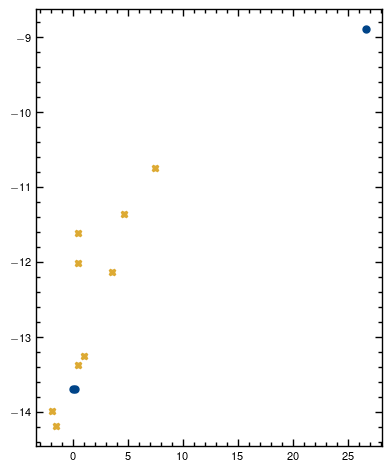

In [22]:
plt.plot(
    ooi_overlapping_bottles.isel(time=2).nitrate,
    -ooi_overlapping_bottles.isel(time=2).temp1,
    "o",
)
plt.plot(
    prof_overlapping_bottles.isel(time=2).nitrate,
    -prof_overlapping_bottles.isel(time=2).temperature,
    "X",
)

In [23]:
ooi_overlapping_bottles

<xarray.Dataset> Size: 133kB
Dimensions:           (time: 23, pressure: 80)
Coordinates:
  * time              (time) datetime64[ns] 184B 2015-04-02T20:58:33 ... 2021...
  * pressure          (pressure) float64 640B 1.49 1.78 1.92 ... 81.22 81.4
Data variables:
    Station           (time, pressure) object 15kB nan nan 'CE02' ... nan nan
    lat               (time, pressure) float64 15kB nan nan 44.64 ... nan nan
    lon               (time, pressure) float64 15kB nan nan -124.3 ... nan nan
    temp1             (time, pressure) float64 15kB nan nan 12.7 ... nan nan nan
    temp2             (time, pressure) float64 15kB nan nan 12.69 ... nan nan
    sal1              (time, pressure) float64 15kB nan nan 32.52 ... nan nan
    sal2              (time, pressure) float64 15kB nan nan 31.64 ... nan nan
    nitrate           (time, pressure) float64 15kB nan nan 0.142 ... nan nan
    pot_density_anom  (time, pressure) float64 15kB nan nan 24.42 ... nan nan

In [24]:
if show_bottle_comparisons:
    temp = ooi_overlapping_bottles.isel(time=0).time
    for i in range(len(ooi_overlapping_bottles.time)):
        if temp != ooi_overlapping_bottles.isel(time=i).time:
            plt.figure()
        plt.plot(
            ooi_overlapping_bottles.isel(time=i).nitrate,
            ooi_overlapping_bottles.isel(time=i).pressure,
            "o",
        )
        plt.plot(
            prof_overlapping_bottles.isel(time=i).nitrate,
            prof_overlapping_bottles.isel(time=i).depth,
            "X",
        )
        plt.annotate(
            f"{ooi_overlapping_bottles.isel(time=i).time.values}\n{np.unique(prof_overlapping_bottles.isel(time=i).deployment.values)}",
            (0.9, 0.9),
            xycoords="axes fraction",
        )
        temp = ooi_overlapping_bottles.isel(time=i).time

No NH10 nitrate data from NHL cruises.

In [25]:
# view created xarray
nhl_crse_nh01 = nhl_crse.where(nhl_crse.station == "NH01", drop=True)
nhl_crse_nh01 = nhl_crse_nh01.swap_dims({"date": "time"})

Mean N below 25.8 sigma: 6.761072682611403
Mean N above 25.8 sigma: 25.888516655563475
Mean N below 25.8 sigma: 4.776562023108734
Mean N above 25.8 sigma: 13.462938888074358


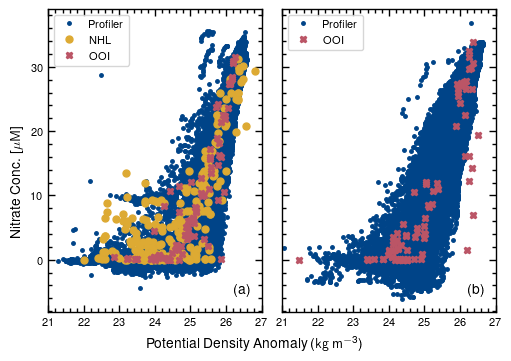

In [26]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(5, 3.5), sharey=True)
# ax0.plot(midshelf_nitrate.density, midshelf_nitrate.nitrate ,'.', color='#004488', label='Profiler', rasterized=True)
# ax0.plot(nhl_crse.potential_density, nhl_crse.nitrate, 'o', color='#DDAA33', label='NHL')
ax0.plot(nitrate.density, nitrate.nitrate, ".", color="#004488", label="Profiler")
ax0.plot(
    nhl_crse_inshore.potential_density,
    nhl_crse_inshore.nitrate,
    "o",
    color="#DDAA33",
    label="NHL",
)
ax0.plot(
    ooi_crse_inshore.pot_density_anom,
    ooi_crse_inshore.nitrate,
    "X",
    color="#BB5566",
    label="OOI",
)
ax0.set_xlim(21, 27)

handles, labels = ax0.get_legend_handles_labels()
by_label = dict(
    zip(labels, handles)
)  # dicts can't have duplicate keys, avoids duplicate legend entries
ax0.legend(by_label.values(), by_label.keys())
# plt.savefig('../../figs/nitrate-wind_manuscript_figs/inshore_nitrate-denisty.eps', format='eps')
print(
    f"Mean N below 25.8 sigma: {np.nanmean(nitrate.where(nitrate.density < 25.8).nitrate)}"
)
print(
    f"Mean N above 25.8 sigma: {np.nanmean(nitrate.where(nitrate.density > 25.8).nitrate)}"
)

ax1.plot(
    midshelf_nitrate.density,
    midshelf_nitrate.nitrate,
    ".",
    color="#004488",
    label="Profiler",
    rasterized=True,
)
ax1.plot(ooi_crse.pot_density_anom, ooi_crse.nitrate, "X", color="#BB5566", label="OOI")
ax1.set_xlim(21, 27)
# ax1.set_xlabel('Density Anomaly ($\mathsf{kg \; m^{-3}}$)')
# ax1.set_ylabel('Nitrate Conc. [$\mathsf{\mu M}$]')
handles, labels = ax1.get_legend_handles_labels()
by_label = dict(
    zip(labels, handles)
)  # dicts can't have duplicate keys, avoids duplicate legend entries
ax1.legend(by_label.values(), by_label.keys())
fig.supxlabel("Potential Density Anomaly ($\\mathsf{kg \\; m^{-3}}$)")
fig.supylabel("Nitrate Conc. [$\\mathsf{\\mu M}$]")

ax0.text(
    0.95, 0.05, "(a)", transform=ax0.transAxes, fontsize=10, ha="right", va="bottom"
)
ax1.text(
    0.95, 0.05, "(b)", transform=ax1.transAxes, fontsize=10, ha="right", va="bottom"
)

print(
    f"Mean N below 25.8 sigma: {np.nanmean(midshelf_nitrate.where(nitrate.density < 25.8).nitrate)}"
)
print(
    f"Mean N above 25.8 sigma: {np.nanmean(midshelf_nitrate.where(nitrate.density > 25.8).nitrate)}"
)

# plt.savefig(
#     "../../figs/nitrate-wind_manuscript_figs/nitrate-denisty.eps",
#     format="eps",
#     bbox_inches="tight",
#     dpi=1200,
# )

## Composite Analysis

In [27]:
cmap = cmo.tools.crop_by_percent(cmo.balance_i, 30, which="both")  # type: ignore
cmap = cmap.from_list("cmap", cmap(np.linspace(0, 1, 11)), 11)

In [28]:
velocity_nh10 = xr.open_mfdataset(
    os.path.join(
        notebook_dir,
        "../data/NH10_Mooring_Data/*.nc",
    )
)
velocity_nh10 = velocity_nh10.squeeze()
velocity_original_depths = velocity_nh10.depth


# apply lanczos filter to velocity data with 33 hour window
wts = firwin(120, 1 / 33, window="lanczos", fs=1)
evel_filt = filtfilt(wts, 1, velocity_nh10["eastward_velocity"].values)
nvel_filt = filtfilt(wts, 1, velocity_nh10["northward_velocity"].values)
theta, major, minor = util.princax(
    np.nanmean(nvel_filt, axis=1), np.nanmean(evel_filt, axis=1)
)
temp_cs, temp_as = util.rot(evel_filt, nvel_filt, theta)
velocity_nh10["cs"] = (["depth", "time"], temp_cs)
velocity_nh10["as"] = (["depth", "time"], temp_as)
velocity_nh10["cs"] = velocity_nh10["cs"] - velocity_nh10["cs"].mean(dim="depth")

In [29]:
velocity_nh10 = velocity_nh10.resample(time="1D").mean()
velocity_nh10 = velocity_nh10.squeeze()
velocity_nh10 = velocity_nh10.where(
    ((velocity_nh10["time.month"] > 3) & (velocity_nh10["time.month"] < 10)), drop=True
)
velocity_nh10["density"] = gsw.rho_t_exact(
    velocity_nh10.salinity, velocity_nh10.temperature, velocity_nh10.depth
)

In [30]:
velocity_nh10 = xr.open_mfdataset(
    os.path.join(
        notebook_dir,
        "../data/NH10_Mooring_Data/*.nc",
    )
)
velocity_nh10 = velocity_nh10.squeeze()

wts = firwin(120, 1 / 33, window="lanczos", fs=1)

evel_filt = filtfilt(wts, 1, velocity_nh10["eastward_velocity"].values)
nvel_filt = filtfilt(wts, 1, velocity_nh10["northward_velocity"].values)

velocity_nh10_da = velocity_nh10.mean(dim="depth")
phi = np.arctan2(np.nanmean(nvel_filt, axis=0), np.nanmean(evel_filt, axis=0))
rot = np.array([[[np.cos(p), np.sin(p)], [-np.sin(p), np.cos(p)]] for p in phi])
vel = np.einsum("ijk->jki", np.array([evel_filt, nvel_filt]))
ns = np.array([vt @ r for vd in vel for vt, r in zip(vd, rot)]).reshape(vel.shape)
n = ns[:, :, 0]
s = ns[:, :, 1]
uproj = np.array([np.sin(np.abs(phi)) * nd for nd in n])
velocity_nh10["cs"] = (["depth", "time"], uproj)
velocity_nh10["eastward_velocity_filt"] = (["depth", "time"], evel_filt)

wts = firwin(120, 1 / 33, window="lanczos", fs=1)
evel_filt = filtfilt(wts, 1, velocity_nh10["eastward_velocity"].values)
nvel_filt = filtfilt(wts, 1, velocity_nh10["northward_velocity"].values)
theta, major, minor = util.princax(
    np.nanmean(evel_filt, axis=1), np.nanmean(nvel_filt, axis=1)
)
# theta = 23.5
temp_cs, temp_as = util.rot(evel_filt, nvel_filt, theta)

C:\Users\asche\AppData\Local\Temp\ipykernel_37632\4265372626.py:15: RuntimeWarning: Mean of empty slice
  phi = np.arctan2(np.nanmean(nvel_filt, axis=0), np.nanmean(evel_filt, axis=0))


C:\Users\asche\AppData\Local\Temp\ipykernel_37632\2881437160.py:3: RuntimeWarning: Mean of empty slice
  np.nanmean(temp_cs, axis=0),
C:\Users\asche\AppData\Local\Temp\ipykernel_37632\2881437160.py:4: RuntimeWarning: Mean of empty slice
  np.nanmean(temp_as, axis=0),
C:\Users\asche\AppData\Local\Temp\ipykernel_37632\2881437160.py:12: RuntimeWarning: Mean of empty slice
  np.nanmean(evel_filt, axis=0),
C:\Users\asche\AppData\Local\Temp\ipykernel_37632\2881437160.py:13: RuntimeWarning: Mean of empty slice
  np.nanmean(nvel_filt, axis=0),


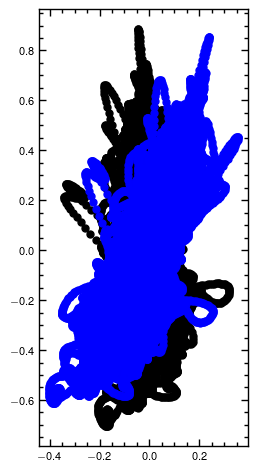

In [31]:
plt.figure()
plt.plot(
    np.nanmean(temp_cs, axis=0),
    np.nanmean(temp_as, axis=0),
    "o",
    mec="black",
    mfc="black",
)
plt.gca().set_aspect("equal")
# plt.figure()
plt.plot(
    np.nanmean(evel_filt, axis=0),
    np.nanmean(nvel_filt, axis=0),
    "o",
    mec="blue",
    mfc="blue",
)
plt.gca().set_aspect("equal")

In [32]:
velocity_nh10["cs"] = (["depth", "time"], temp_cs)
velocity_nh10["as"] = (["depth", "time"], temp_as)
velocity_nh10["cs"] = velocity_nh10["cs"] - velocity_nh10["cs"].mean(dim="depth")

velocity_nh10 = velocity_nh10.resample(time="1D").mean()
velocity_nh10 = velocity_nh10.squeeze()
# velocity_nh10 = velocity_nh10.where(((velocity_nh10['time.month'] > 3) & (velocity_nh10['time.month'] < 10)) , drop=True)
velocity_nh10["density"] = gsw.rho_t_exact(
    velocity_nh10.salinity, velocity_nh10.temperature, velocity_nh10.depth
)

velocity_nh10 = velocity_nh10.interp(depth=midshelf_nitrate.depth)

In [ ]:
days = np.arange(-5, 6)
composite_wind_events = []
for i, (t1, t2) in enumerate(zip(tq(wind.time[:-1]), wind.time[1:])):
    temp1 = wind.sel({"time": t1})
    temp2 = wind.sel({"time": t2})
    if (temp2.coare_y < -0.05) & (temp1.coare_y > -0.03):
        temp3 = wind.sel(time=slice(t2, t2 + np.timedelta64(5, "D")))
        if np.all(temp3.coare_y < 0):
            composite_wind_events.append(
                wind.sel(
                    time=slice(t2 - np.timedelta64(5, "D"), t2 + np.timedelta64(5, "D"))
                )
            )
            composite_wind_events[-1] = composite_wind_events[-1].drop_vars(
                ["dominant_wpd", "average_wpd"]
            )
# select only composites with the full amount of time points (11)
composite_wind_events = [c for c in composite_wind_events if len(c.time) == len(days)]
composite_vel_events = [
    velocity_nh10.where(velocity_nh10.time.isin(cw.time), drop=True)
    for cw in composite_wind_events
]
composite_vel_events = [cv for cv in composite_vel_events if cv.time.size == len(days)]
composite_midshelf_nitrate_events = [
    midshelf_nitrate.where(midshelf_nitrate.time.isin(cw.time), drop=True)
    for cw in composite_wind_events
]
composite_midshelf_nitrate_events = [
    cmn for cmn in composite_midshelf_nitrate_events if cmn.time.size == len(days)
]

# deal with overlapping events
composite_times = [c.time[5].values for c in composite_wind_events]
for i, (t1, t2) in enumerate(zip(composite_times[:-1], composite_times[1:])):
    if t2 - t1 < np.timedelta64(5, "D"):
        composite_wind_events[i] = composite_wind_events[i].sel(
            time=slice(None, t2 - np.timedelta64(1, "D"))
        )
composite_times = [c.time[5].values for c in composite_vel_events]
for i, (t1, t2) in enumerate(zip(composite_times[:-1], composite_times[1:])):
    if t2 - t1 < np.timedelta64(5, "D"):
        composite_vel_events[i] = composite_vel_events[i].sel(
            time=slice(None, t2 - np.timedelta64(1, "D"))
        )
composite_times = [c.time[5].values for c in composite_midshelf_nitrate_events]
for i, (t1, t2) in enumerate(zip(composite_times[:-1], composite_times[1:])):
    if t2 - t1 < np.timedelta64(5, "D"):
        composite_midshelf_nitrate_events[i] = composite_midshelf_nitrate_events[i].sel(
            time=slice(None, t2 - np.timedelta64(1, "D"))
        )

  0%|          | 0/11641 [00:00<?, ?it/s]

 11%|█         | 1251/11641 [00:03<00:24, 416.86it/s]

In [ ]:
# different because the velocity data does not span as far back as wind data
n = len(composite_wind_events)
print(f"Number of composite wind events: {n}")
n = len(composite_vel_events)
print(f"Number of composite velocity events: {n}")
n = len(composite_midshelf_nitrate_events)
print(f"Number of composite midshelf nitrate events: {n}")

Number of composite wind events: 222
Number of composite velocity events: 168
Number of composite midshelf nitrate events: 74


In [ ]:
def composite(
    events: list[xr.Dataset],
    var: str,
    composite_days: np.ndarray,
    monthly: bool = False,
) -> xr.Dataset:
    """Takes a list of events and computes composites.

    Events are a list of datasets, each of which contains one event, over a event length defined by composite_days.

    :param events: event data
    :type events: list[xr.Dataset]
    :param var: variable to composite
    :type var: str
    :param composite_days: days for each event
    :type composite_days: np.array
    :param monthly: computes composite as a function of month, defaults to False
    :type monthly: bool, optional
    :return: dataset containing mean, std, count, and confidence interval for composite
    :rtype: xr.Dataset
    """
    composite_length = composite_days.size
    ds_list = np.empty(composite_length, dtype=xr.Dataset)
    for i in range(composite_length):
        composite_data = [
            d.isel(time=i) for d in events if len(d.time) == composite_length
        ]
        composite_data = xr.concat(composite_data, dim="time")
        if monthly:
            composite_mean = composite_data.groupby("time.month").mean(
                dim="time", skipna=True
            )[var]
            composite_std = composite_data.groupby("time.month").std(
                dim="time", skipna=True
            )[var]
            composite_count = composite_data.groupby("time.month").count(dim="time")[
                var
            ]
            ds_list[i] = xr.Dataset(
                {
                    "mean": composite_mean,
                    "std": composite_std,
                    "count": composite_count,
                },
                coords={"time": composite_days[i]},
            )
        else:
            composite_mean = composite_data.mean(dim="time", skipna=True)[var]
            composite_std = composite_data.std(dim="time", skipna=True)[var]
            composite_count = composite_data.count(dim="time")[var]
            ds_list[i] = xr.Dataset(
                {
                    "mean": composite_mean,
                    "std": composite_std,
                    "count": composite_count,
                },
            )
    ds = xr.concat(ds_list, dim="time")
    ds["ci"] = (
        ds["std"] / np.sqrt(ds["count"]) * distributions.t(ds["count"] - 1).isf(0.025)
    )
    return ds

In [ ]:
days = np.arange(-5, 6)
composite_stress = composite(composite_wind_events, "coare_y", days)

Text(0, 0.5, 'Wind Stress [$\\mathsf{N} \\; \\mathsf{m^{-2}}$]')

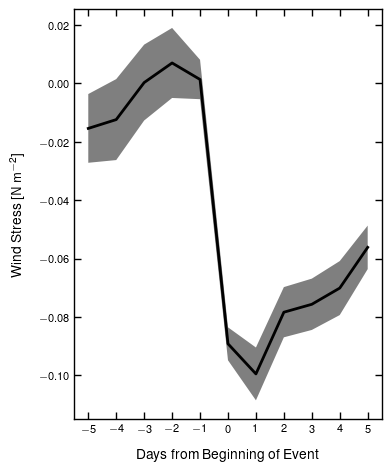

In [ ]:
fig, axs = plt.subplots()

axs.plot(days, composite_stress["mean"], color="black", label="Median")
axs.fill_between(
    days,
    composite_stress["mean"] - composite_stress["ci"],
    composite_stress["mean"] + composite_stress["ci"],
    ls="None",
    edgecolor="None",
    facecolor="black",
    alpha=0.5,
)
# axs.plot(days, composite_stress['mean'] - composite_stress['ci'], '--', color='black', label='95\% CI')
# axs.plot(days, composite_stress['mean'] + composite_stress['ci'], '--', color='black')

# axs.legend()

axs.set_xticks(np.arange(-5, 6))
axs.minorticks_off()
axs.set_xlabel("Days from Beginning of Event")
axs.set_ylabel("Wind Stress [$\\mathsf{N} \\; \\mathsf{m^{-2}}$]")

In [ ]:
composite_stress_monthly = composite(
    composite_wind_events, "coare_y", days, monthly=True
)

Text(0.5, 0.01, 'Days from Beginning of Upwelling Event')

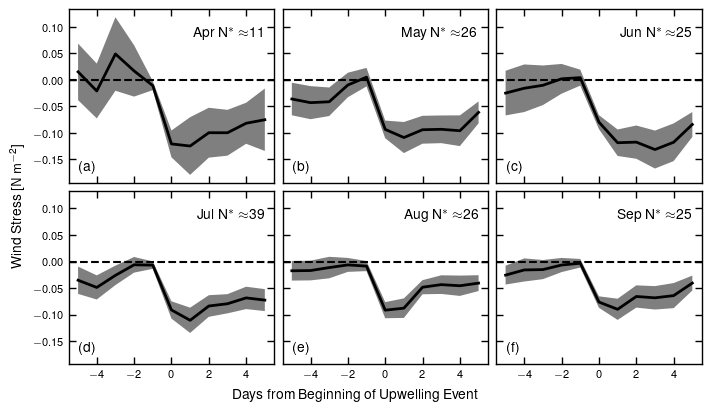

In [ ]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(7, 4))
axs = axs.flatten()
for i, m in enumerate(composite_stress_monthly["month"].sel(month=slice(4, 9))):
    data = composite_stress_monthly.sel(month=m)
    axs[i].axhline(0, color="black", lw=1.5, ls="--")
    axs[i].plot(days, data["mean"], c="k")
    axs[i].fill_between(
        days,
        data["mean"] - data["ci"],
        data["mean"] + data["ci"],
        ls="None",
        edgecolor="None",
        facecolor="black",
        alpha=0.5,
    )
    axs[i].minorticks_off()
    axs[i].annotate(
        f"{calendar.month_abbr[m.values]} N$^*\\approx${composite_stress_monthly['count'].sel(month=m).mean(dim='time'):.0f}",
        xy=(0.95, 0.9),
        xycoords="axes fraction",
        va="top",
        ha="right",
    )
    axs[i].annotate(
        f"({string.ascii_lowercase[i]})",
        xy=(0.05, 0.05),
        xycoords="axes fraction",
        va="bottom",
        ha="left",
    )
# axs[0].set_ylabel('Wind Stress [$\mathsf{N} \; \mathsf{m^{-2}}$]')
fig.supylabel("Wind Stress [$\\mathsf{N} \\; \\mathsf{m^{-2}}$]")
fig.supxlabel("Days from Beginning of Upwelling Event")
# plt.savefig(
#     "../../figs/nitrate_new_manuscript_figs/composite_wind_stress.pdf", format="pdf"
# )

In [ ]:
composite_vel_monthly_cs = composite(composite_vel_events, "cs", days, monthly=True)

Text(0.5, 0.98, 'Cross-shelf velocity')

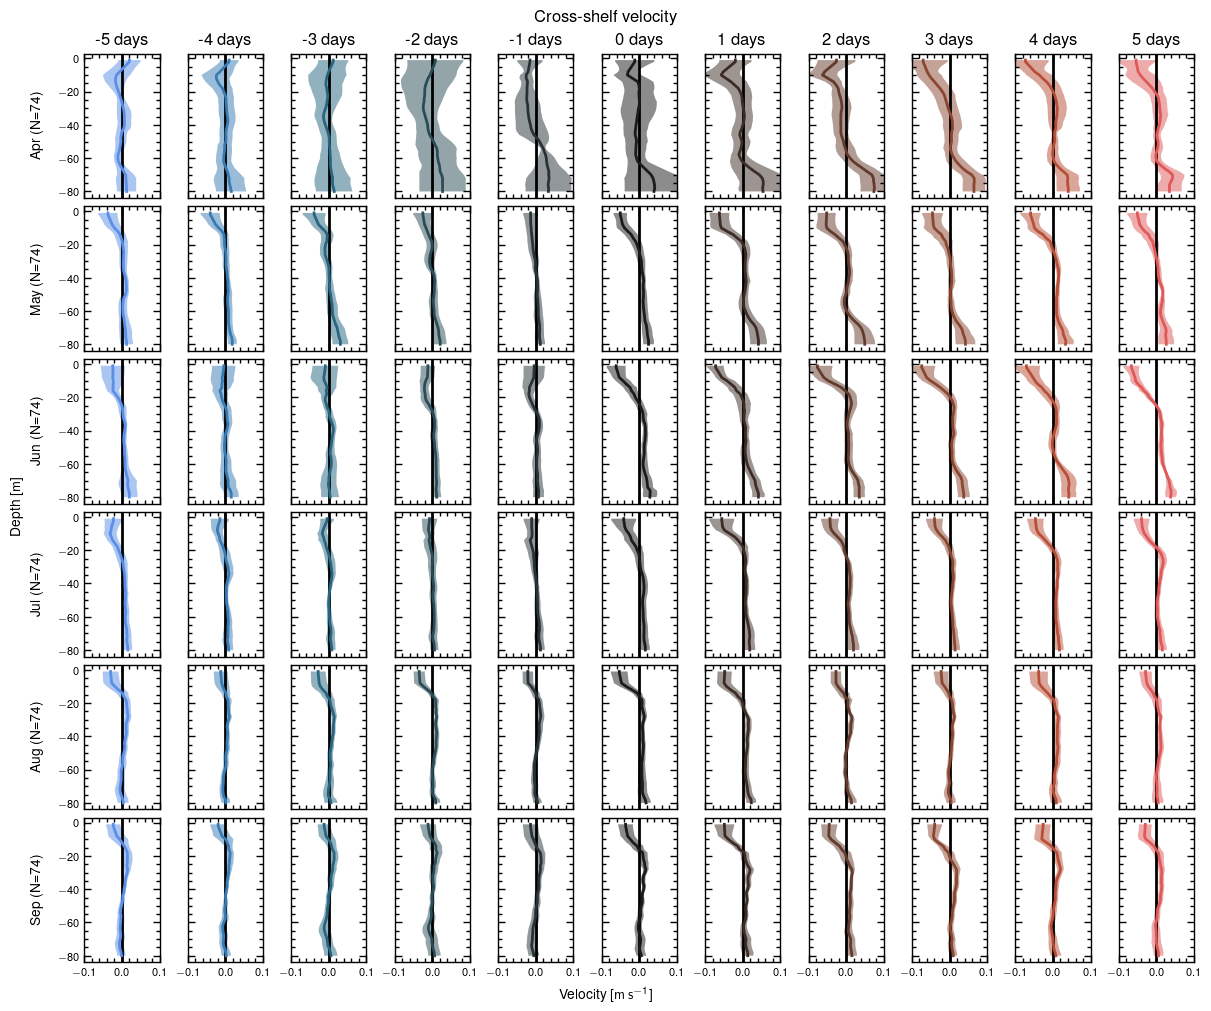

In [ ]:
fig, axs = plt.subplots(nrows=6, ncols=11, sharex=True, sharey=True, figsize=(12, 10))
for i, d in enumerate(composite_vel_monthly_cs["month"].sel(month=slice(4, 9))):
    for j, day in enumerate(days):
        data = composite_vel_monthly_cs.sel(month=d, time=day)
        axs[i][j].axvline(0, color="black")
        axs[i][j].plot(data["mean"], -data["depth"], c=cmap(j / 11))
        axs[i][j].fill_betweenx(
            -data["depth"],
            data["mean"] - data["ci"],
            data["mean"] + data["ci"],
            ls="None",
            edgecolor="None",
            facecolor=cmap(j / 11),
            alpha=0.5,
        )
        # axs[i][j].plot(data['mean'] + data['ci'], -data['depth'], '--', c=cmap(j/11))
        # axs[i][j].plot(data['mean'] - data['ci'], -data['depth'], '--', c=cmap(j/11))
        axs[i][j].set_xlim([-0.1, 0.1])
        if j == 0:
            axs[i][j].set_ylabel(
                calendar.month_abbr[data["month"].values] + f" (N={np.nanmean(n):.0f})"
            )
        if i == 0:
            axs[i][j].set_title(f"{day} days")
fig.supxlabel("Velocity [$\\mathsf{m \\; s^{-1}}$]")
fig.supylabel("Depth [$\\mathsf{m}$]")
fig.suptitle("Cross-shelf velocity")

Text(0.02, 0.5, 'Depth [$\\mathsf{m}$]')

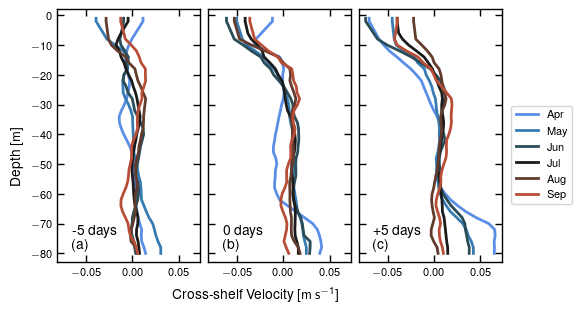

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(5, 3))
composite_vel_monthly_cs_slice = composite_vel_monthly_cs.sel(
    time=slice(-3, 3, 3), month=slice(4, 9)
)


for i, v in enumerate(composite_vel_monthly_cs_slice["time"]):
    for j, m in enumerate(composite_vel_monthly_cs_slice.sel(time=v)["month"]):
        data = composite_vel_monthly_cs_slice.sel(time=v, month=m)
        axs[i].plot(
            data["mean"],
            -data["depth"],
            label=calendar.month_abbr[m.values],
            c=cmap(j / 6),
        )
        axs[i].minorticks_off()
        axs[i].set_ylim([-83, 2])

axs[0].annotate("-5 days\n(a)", xy=(0.10, 0.05), xycoords="axes fraction", fontsize=10)
axs[1].annotate("0 days\n(b)", xy=(0.10, 0.05), xycoords="axes fraction", fontsize=10)
axs[2].annotate("+5 days\n(c)", xy=(0.10, 0.05), xycoords="axes fraction", fontsize=10)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1.0, 0.5))

# axs[0].annotate('-5 days', xy=(0.95, 0.9), xycoords='axes fraction', fontsize=10, ha='right')
# axs[1].annotate('0 days', xy=(0.95, 0.9), xycoords='axes fraction', fontsize=10, ha='right')
# axs[2].annotate('+5 days', xy=(0.95, 0.9), xycoords='axes fraction', fontsize=10, ha='right')

fig.supxlabel("Cross-shelf Velocity [$\\mathsf{m \\; s^{-1}}$]")
fig.supylabel("Depth [$\\mathsf{m}$]")
# plt.savefig(
#     "../../figs/nitrate_new_manuscript_figs/composite_cs_velocity.pdf",
#     format="pdf",
#     bbox_inches="tight",
# )

In [ ]:
composite_vel_monthly_as = composite(composite_vel_events, "as", days, monthly=True)

Text(0.5, 0.98, 'Along-shelf velocity')

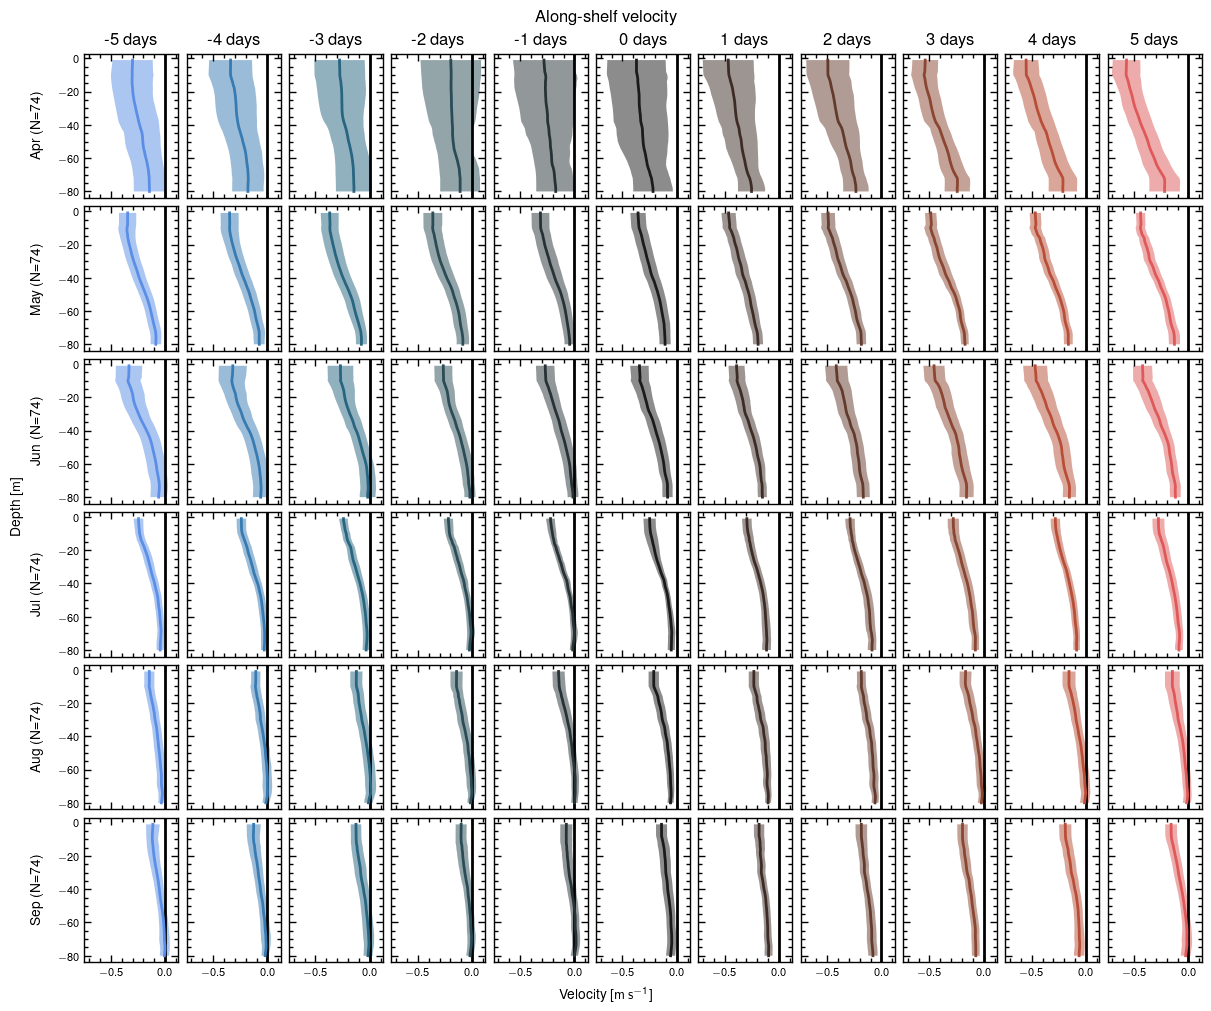

In [ ]:
fig, axs = plt.subplots(nrows=6, ncols=11, sharex=True, sharey=True, figsize=(12, 10))
for i, d in enumerate(composite_vel_monthly_as["month"].sel(month=slice(4, 9))):
    for j, day in enumerate(days):
        data = composite_vel_monthly_as.sel(month=d, time=day)
        axs[i][j].axvline(0, color="black")
        axs[i][j].plot(data["mean"], -data["depth"], c=cmap(j / 11))
        axs[i][j].fill_betweenx(
            -data["depth"],
            data["mean"] - data["ci"],
            data["mean"] + data["ci"],
            ls="None",
            edgecolor="None",
            facecolor=cmap(j / 11),
            alpha=0.5,
        )
        # axs[i][j].plot(data['mean'] + data['ci'], -data['depth'], '--', c=cmap(j/11))
        # axs[i][j].plot(data['mean'] - data['ci'], -data['depth'], '--', c=cmap(j/11))
        # axs[i][j].set_xlim([-0.1, 0.1])
        if j == 0:
            axs[i][j].set_ylabel(
                calendar.month_abbr[data["month"].values] + f" (N={np.nanmean(n):.0f})"
            )
        if i == 0:
            axs[i][j].set_title(f"{day} days")
fig.supxlabel("Velocity [$\\mathsf{m \\; s^{-1}}$]")
fig.supylabel("Depth [$\\mathsf{m}$]")
fig.suptitle("Along-shelf velocity")

Text(0.02, 0.5, 'Depth [$\\mathsf{m}$]')

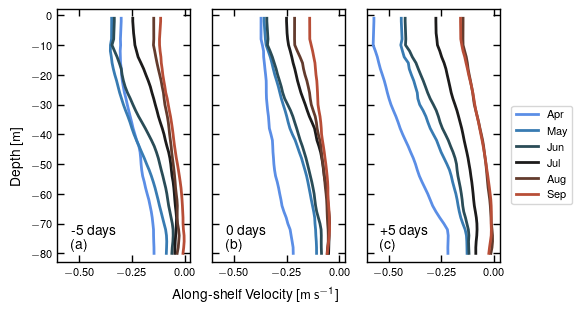

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(5, 3))
composite_vel_monthly_as_slice = composite_vel_monthly_as.sel(
    time=slice(-5, 5, 5), month=slice(4, 9)
)

for i, v in enumerate(composite_vel_monthly_as_slice["time"]):
    for j, m in enumerate(composite_vel_monthly_as_slice.sel(time=v)["month"]):
        data = composite_vel_monthly_as_slice.sel(time=v, month=m)
        axs[i].plot(
            data["mean"],
            -data["depth"],
            label=calendar.month_abbr[m.values],
            c=cmap(j / 6),
        )
        axs[i].minorticks_off()
        axs[i].set_ylim([-83, 2])

axs[0].annotate("-5 days\n(a)", xy=(0.10, 0.05), xycoords="axes fraction", fontsize=10)
axs[1].annotate("0 days\n(b)", xy=(0.10, 0.05), xycoords="axes fraction", fontsize=10)
axs[2].annotate("+5 days\n(c)", xy=(0.10, 0.05), xycoords="axes fraction", fontsize=10)
# axs[0].annotate('-5 days', xy=(0.95, 0.9), xycoords='axes fraction', fontsize=10, ha='right')
# axs[1].annotate('0 days', xy=(0.95, 0.9), xycoords='axes fraction', fontsize=10, ha='right')
# axs[2].annotate('+5 days', xy=(0.95, 0.9), xycoords='axes fraction', fontsize=10, ha='right')

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1.0, 0.5))

fig.supxlabel("Along-shelf Velocity [$\\mathsf{m \\; s^{-1}}$]")
fig.supylabel("Depth [$\\mathsf{m}$]")
# plt.savefig(
#     "../../figs/nitrate_new_manuscript_figs/composite_as_velocity.pdf",
#     format="pdf",
#     bbox_inches="tight",
# )

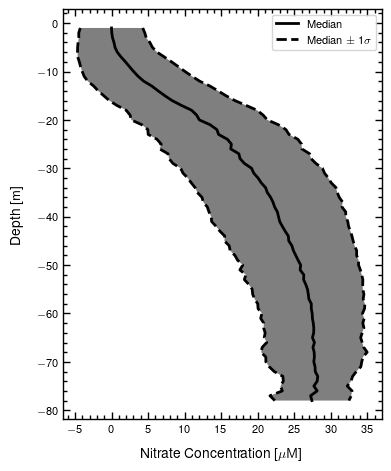

In [ ]:
midshelf_nitrate_med = midshelf_nitrate.where(midshelf_nitrate.depth < 79).median(
    dim="time"
)
midshelf_nitrate_std = midshelf_nitrate.where(midshelf_nitrate.depth < 79).std(
    dim="time"
)
plt.plot(
    midshelf_nitrate_med.nitrate,
    -midshelf_nitrate_med.depth,
    color="black",
    label="Median",
)
plt.fill_betweenx(
    -midshelf_nitrate_med.depth,
    midshelf_nitrate_med.nitrate - midshelf_nitrate_std.nitrate,
    midshelf_nitrate_med.nitrate + midshelf_nitrate_std.nitrate,
    ls="None",
    edgecolor="None",
    facecolor="black",
    alpha=0.5,
)
plt.plot(
    midshelf_nitrate_med.nitrate - midshelf_nitrate_std.nitrate,
    -midshelf_nitrate_med.depth,
    "--",
    color="black",
    label=r"Median $\pm$ 1$\sigma$",
)
plt.plot(
    midshelf_nitrate_med.nitrate + midshelf_nitrate_std.nitrate,
    -midshelf_nitrate_med.depth,
    "--",
    color="black",
)
plt.xlabel(r"Nitrate Concentration [$\mu \mathsf{M}$]")
plt.ylabel(r"Depth [$\mathsf{m}$]")
plt.legend()

In [ ]:
midshelf_nitrate_monthly = xr.Dataset(
    {
        "mean": midshelf_nitrate.groupby("time.month").mean(dim="time", skipna=True)[
            "nitrate"
        ],
        "std": midshelf_nitrate.groupby("time.month").std(dim="time", skipna=True)[
            "nitrate"
        ],
        "count": midshelf_nitrate.groupby("time.month").count(dim="time")["nitrate"],
    }
)
midshelf_nitrate_monthly["ci"] = (
    midshelf_nitrate_monthly["std"] / np.sqrt(5) * distributions.t(5 - 1).isf(0.025)
)

Text(0.02, 0.5, 'Depth [$\\mathsf{m}$]')

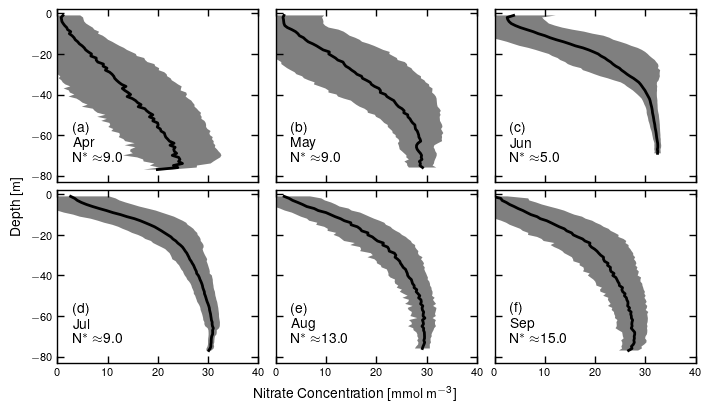

In [ ]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(7, 4))
axs = axs.flatten()
for i, m in enumerate(midshelf_nitrate_monthly.sel(month=slice(4, 9))["month"]):
    monthly_data = midshelf_nitrate_monthly.sel(month=m)
    monthly_data = monthly_data.where(monthly_data["count"] > 5, drop=True)
    axs[i].plot(monthly_data["mean"], -monthly_data["depth"], color="black")
    axs[i].fill_betweenx(
        -monthly_data["depth"],
        monthly_data["mean"] - monthly_data["ci"],
        monthly_data["mean"] + monthly_data["ci"],
        ls="None",
        edgecolor="None",
        facecolor="black",
        alpha=0.5,
    )
    # axs[i].plot(monthly_data['mean'] + monthly_data['ci'], -monthly_data['depth'], color='black', ls='--', label=f'NEff$\\approx${np.ceil(monthly_data['count'].mean()/7)}')
    # axs[i].plot(monthly_data['mean'] + monthly_data['ci'], -monthly_data['depth'], color='black', ls='--')
    axs[i].annotate(
        f"({string.ascii_lowercase[i]})\n{calendar.month_abbr[m.values]}\nN$^*\\approx${np.ceil(monthly_data['count'].mean().values / 7)}",
        xy=(0.075, 0.1),
        xycoords="axes fraction",
        fontsize=10,
        ha="left",
        va="bottom",
    )

    # axs[i].set_title(calendar.month_abbr[m.values])
    axs[i].set_xlim(0, 40)
    axs[i].set_ylim(-83, 2)
    axs[i].minorticks_off()

    # ax.legend()
fig.supxlabel("Nitrate Concentration [$\\mathsf{m mol \\; m^{-3}}$]")
fig.supylabel("Depth [$\\mathsf{m}$]")
# plt.savefig(
#     "../../figs/nitrate_new_manuscript_figs/monthly_midshelf_nitrate.pdf",
#     format="pdf",
#     bbox_inches="tight",
# )

In [ ]:
composite_midshelf_nitrate_flux_monthly = (
    midshelf_nitrate_monthly * composite_vel_monthly_cs
)
midshelf_velocity_nitrate_cov = xr.cov(
    midshelf_nitrate["nitrate"], velocity_nh10["cs"], ["time"]
)
composite_midshelf_nitrate_flux_monthly["std"] = np.sqrt(
    (midshelf_nitrate_monthly["mean"] * composite_vel_monthly_cs["std"]) ** 2
    + (composite_vel_monthly_cs["mean"] * midshelf_nitrate_monthly["std"]) ** 2
    + 2
    * midshelf_nitrate_monthly["mean"]
    * composite_vel_monthly_cs["mean"]
    * midshelf_velocity_nitrate_cov
)
composite_midshelf_nitrate_flux_monthly["count"] = composite_vel_monthly_cs["count"]
composite_midshelf_nitrate_flux_monthly = (
    composite_midshelf_nitrate_flux_monthly.transpose(
        *composite_vel_monthly_cs["count"].dims
    )
)
composite_midshelf_nitrate_flux_monthly["ci"] = (
    composite_midshelf_nitrate_flux_monthly["std"]
    / np.sqrt(composite_midshelf_nitrate_flux_monthly["count"])
    * distributions.t(composite_midshelf_nitrate_flux_monthly["count"] - 1).isf(0.025)
)

c:\Users\asche\Desktop\po_code\shelf-nitrate-response-to-upwelling\.venv\Lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


Text(0.5, 0.98, 'Cross-shelf Nitrate Flux')

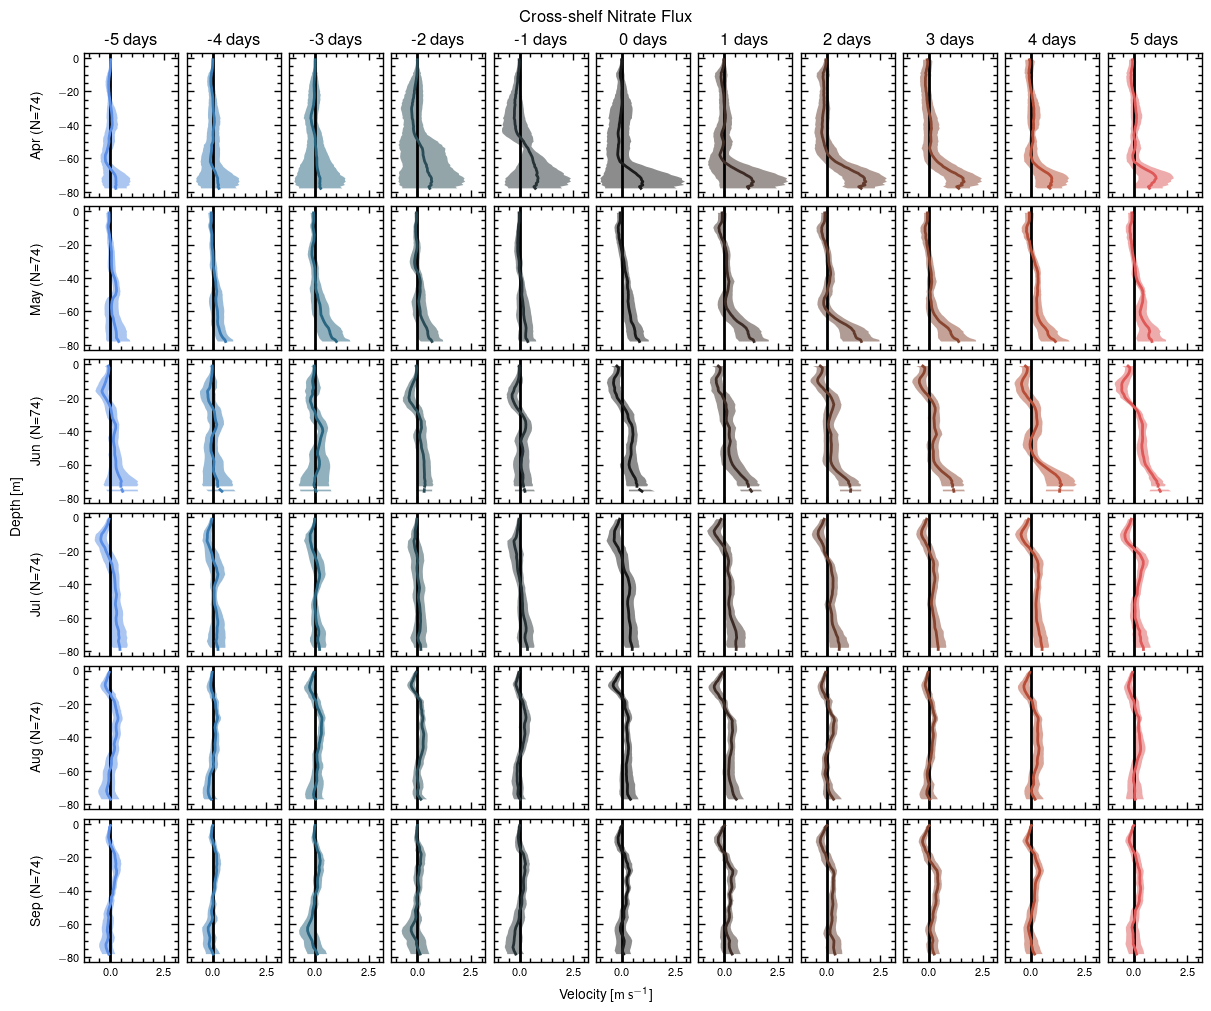

In [ ]:
fig, axs = plt.subplots(nrows=6, ncols=11, sharex=True, sharey=True, figsize=(12, 10))
for i, d in enumerate(
    composite_midshelf_nitrate_flux_monthly["month"].sel(month=slice(4, 9))
):
    for j, day in enumerate(days):
        data = composite_midshelf_nitrate_flux_monthly.sel(month=d, time=day)
        axs[i][j].axvline(0, color="black")
        axs[i][j].plot(data["mean"], -data["depth"], c=cmap(j / 11))
        axs[i][j].fill_betweenx(
            -data["depth"],
            data["mean"] - data["ci"],
            data["mean"] + data["ci"],
            ls="None",
            edgecolor="None",
            facecolor=cmap(j / 11),
            alpha=0.5,
        )
        # axs[i][j].plot(data['mean'] + data['ci'], -data['depth'], '--', c=cmap(j/11))
        # axs[i][j].plot(data['mean'] - data['ci'], -data['depth'], '--', c=cmap(j/11))
        # axs[i][j].set_xlim([-0.1, 0.1])
        if j == 0:
            axs[i][j].set_ylabel(
                calendar.month_abbr[data["month"].values] + f" (N={np.nanmean(n):.0f})"
            )
        if i == 0:
            axs[i][j].set_title(f"{day} days")
fig.supxlabel("Velocity [$\\mathsf{m \\; s^{-1}}$]")
fig.supylabel("Depth [$\\mathsf{m}$]")
fig.suptitle("Cross-shelf Nitrate Flux")

Text(0.02, 0.5, 'Depth [$\\mathsf{m}$]')

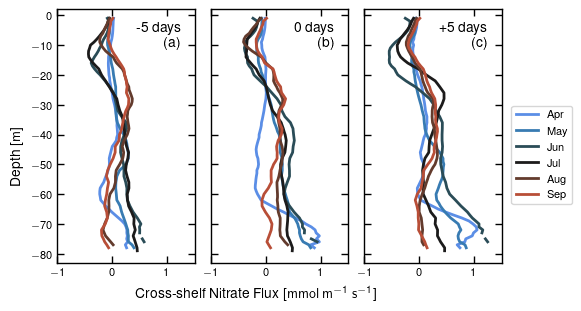

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(5, 3))
composite_midshelf_nitrate_flux_monthly_slice = (
    composite_midshelf_nitrate_flux_monthly.sel(time=slice(-5, 5, 5), month=slice(4, 9))
)

for i, v in enumerate(composite_midshelf_nitrate_flux_monthly_slice["time"]):
    for j, m in enumerate(
        composite_midshelf_nitrate_flux_monthly_slice.sel(time=v)["month"]
    ):
        data = composite_midshelf_nitrate_flux_monthly_slice.sel(time=v, month=m)
        axs[i].plot(
            data["mean"],
            -data["depth"],
            label=calendar.month_abbr[m.values],
            c=cmap(j / 6),
        )
        axs[i].minorticks_off()
        axs[i].set_xlim([-1, 1.5])
        axs[i].set_ylim([-83, 2])

axs[0].annotate(
    "-5 days\n(a)",
    xy=(0.9, 0.95),
    xycoords="axes fraction",
    fontsize=10,
    ha="right",
    va="top",
)
axs[1].annotate(
    "0 days\n(b)",
    xy=(0.9, 0.95),
    xycoords="axes fraction",
    fontsize=10,
    ha="right",
    va="top",
)
axs[2].annotate(
    "+5 days\n(c)",
    xy=(0.9, 0.95),
    xycoords="axes fraction",
    fontsize=10,
    ha="right",
    va="top",
)
# axs[0].annotate('-5 days', xy=(0.50, 0.02), xycoords='axes fraction', fontsize=10, ha='center')
# axs[1].annotate('0 days', xy=(0.50, 0.02), xycoords='axes fraction', fontsize=10, ha='center')
# axs[2].annotate('+5 days', xy=(0.50, 0.02), xycoords='axes fraction', fontsize=10, ha='center')
""
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1.0, 0.5))

fig.supxlabel("Cross-shelf Nitrate Flux [$\\mathsf{m mol \\; m^{-1} \\; s^{-1}}$]")
fig.supylabel("Depth [$\\mathsf{m}$]")
# plt.savefig(
#     "../../figs/nitrate_new_manuscript_figs/composite_cs_nflux.pdf",
#     format="pdf",
#     bbox_inches="tight",
# )

In [ ]:
flux_60_80 = np.full(
    (
        len(composite_midshelf_nitrate_flux_monthly["month"]),
        len(composite_midshelf_nitrate_flux_monthly["time"]),
    ),
    np.nan,
)
flux_20_60 = np.full(
    (
        len(composite_midshelf_nitrate_flux_monthly["month"]),
        len(composite_midshelf_nitrate_flux_monthly["time"]),
    ),
    np.nan,
)
flux_full = np.full(
    (
        len(composite_midshelf_nitrate_flux_monthly["month"]),
        len(composite_midshelf_nitrate_flux_monthly["time"]),
    ),
    np.nan,
)
for i, m in enumerate(composite_midshelf_nitrate_flux_monthly["month"]):
    for j, t in enumerate(composite_midshelf_nitrate_flux_monthly["time"]):
        # 60 m to 80 m flux
        data = composite_midshelf_nitrate_flux_monthly.sel(
            month=m, time=t, depth=slice(60, 80)
        )
        mask = ~np.isnan(data["mean"])
        data = data.isel(depth=mask)
        if len(data["depth"]) > 0:
            flux_60_80[i, j] = np.trapezoid(data["mean"], data["depth"])

        # 20 m to 40 m flux
        data = composite_midshelf_nitrate_flux_monthly.sel(
            month=m, time=t, depth=slice(20, 60)
        )
        mask = ~np.isnan(data["mean"])
        data = data.isel(depth=mask)
        if len(data["depth"]) > 0:
            flux_20_60[i, j] = np.trapezoid(data["mean"], data["depth"])

        # full flux
        data = composite_midshelf_nitrate_flux_monthly.sel(month=m, time=t)
        mask = ~np.isnan(data["mean"])
        data = data.isel(depth=mask)
        if len(data["depth"]) > 0:
            flux_full[i, j] = np.trapezoid(data["mean"], data["depth"])

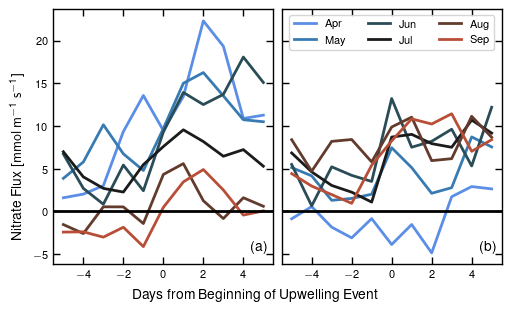

In [ ]:
# c = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377']
# cmap = cmo.tools.crop_by_percent(cmo.thermal, 30, which='both')
# cmap = cmap.from_list('cmap', cmap(np.linspace(0, 1, 11)), 11)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(5, 3))
for i, m in enumerate(
    composite_midshelf_nitrate_flux_monthly.sel(month=slice(4, 9))["month"]
):
    # data = composite_midshelf_nitrate_flux_monthly.sel(month=m)
    axs[0].plot(
        days, flux_60_80[m - 1], color=cmap(i / 6), label=calendar.month_abbr[m.values]
    )
    axs[1].plot(
        days, flux_20_60[m - 1], color=cmap(i / 6), label=calendar.month_abbr[m.values]
    )

axs[0].minorticks_off()
axs[1].minorticks_off()
axs[0].axhline(0, color="black")
axs[1].axhline(0, color="black")
axs[1].legend(loc="upper center", ncol=3)
# axs[0].set_title('Bottom Layer Nitrate Flux')
# axs[1].set_title('Intermediate Layer Nitrate Flux')
# axs[0].legend(loc='upper left')
# handles, labels = axs[1].get_legend_handles_labels()
# fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
fig.supylabel("Nitrate Flux [$\\mathsf{mmol \\; m^{-1} \\; s^{-1}}$]")
# axs[0].set_title('Mean Nitrate flux below 60 m')
# axs[1].set_title('Mean Nitrate flux from 20 m to 40 m')
fig.supxlabel("Days from Beginning of Upwelling Event")
axs[0].annotate("(a)", xy=(0.9, 0.05), xycoords="axes fraction", fontsize=10)
axs[1].annotate("(b)", xy=(0.9, 0.05), xycoords="axes fraction", fontsize=10)

# reset cmap
cmap = cmo.tools.crop_by_percent(cmo.balance_i, 30, which="both")
cmap = cmap.from_list("cmap", cmap(np.linspace(0, 1, 11)), 11)
# plt.savefig(
#     "../../figs/nitrate_new_manuscript_figs/layer_cs_nflux.pdf",
#     format="pdf",
#     bbox_inches="tight",
# )

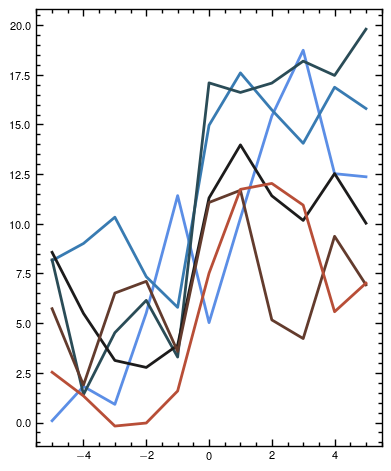

In [ ]:
# fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 4))
for i, m in enumerate(
    composite_midshelf_nitrate_flux_monthly.sel(month=slice(4, 9))["month"]
):
    data = composite_midshelf_nitrate_flux_monthly.sel(month=m)
    plt.plot(
        np.arange(-5, 6),
        flux_full[m - 1],
        color=cmap(i / 6),
        label=calendar.month_abbr[m.values],
    )

In [ ]:
# use monthly N profiles to calculate nitrate flux for correlation
velocity_nh10_flux = []
for i, month in enumerate(range(4, 10)):
    velocity_nh10_flux.append(
        velocity_nh10.where(velocity_nh10["time.month"] == month, drop=True).cs
        * midshelf_nitrate_monthly["mean"].sel(month=month)
    )
velocity_nh10_flux = xr.merge(
    [v.to_dataset(name="nitrate_flux").drop_vars("month") for v in velocity_nh10_flux]
)

In [ ]:
velocity_nh10_flux["nitrate_flux_depth_integrated"] = (
    ["time"],
    xr.apply_ufunc(
        lambda x, y: np.array(
            [
                np.trapezoid(yi[~np.isnan(yi)], x[~np.isnan(yi)])
                if len(yi[~np.isnan(yi)]) > 10
                else np.nan
                for yi in y
            ]
        ),
        velocity_nh10_flux.depth.values,
        velocity_nh10_flux.nitrate_flux.values,
    ),
)

In [ ]:
def lagged_correlation(
    a: xr.DataArray, b: xr.DataArray, lags: NDArray
) -> tuple[NDArray, NDArray, NDArray]:
    """Positive lags for b leading a, negative lags for a leading b.

    :param a: time series
    :type a: xr.DataArray
    :param b: time series
    :type b: xr.DataArray
    :param lags: lags to calculate cross correlation
    :type lags: np.ndarray
    :return: tuple of correlation and number of data points used
    :rtype: tuple[np.ndarray, np.ndarray]
    """
    corr = np.full(lags.size, np.nan)
    confint = np.full((lags.size, 2), np.nan)
    n = np.full(lags.size, np.nan)
    for i, t in enumerate(lags):
        b_shift = b.shift(time=t)
        a_shift, b_shift = xr.align(a, b_shift)
        mask = ~np.isnan(a_shift) & ~np.isnan(b_shift)
        ccf = sm.tsa.ccf(
            a_shift[mask], b_shift[mask], adjusted=True, nlags=1, alpha=0.05
        )
        corr[i] = ccf[0][0]
        confint[i] = ccf[1]
        n[i] = np.sum(mask)
    return corr, confint, n

np.float64(-0.585614612994839)

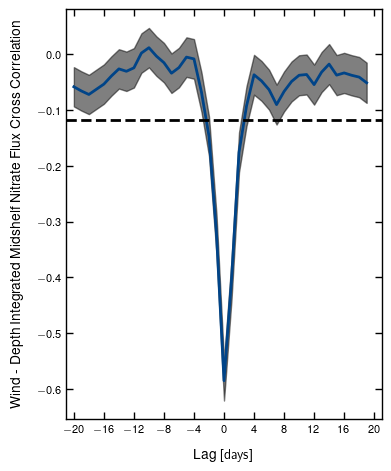

In [ ]:
tdelay = np.arange(-20, 20)
flux_wind_lag_correlation, confint, n = lagged_correlation(
    velocity_nh10_flux.nitrate_flux_depth_integrated,
    wind.coare_y,
    tdelay,
)

n_eff = np.nanmean(n) / 11
alpha = 0.05
rho_crit = np.sqrt(
    distributions.f.isf(alpha, 1, n_eff - 2)
    / (n_eff - 2 + distributions.f.isf(alpha, 1, n_eff - 2))
)

plt.plot(tdelay, flux_wind_lag_correlation)
plt.fill_between(tdelay, confint[:, 0], confint[:, 1], color="black", alpha=0.5)
plt.xlabel("Lag [$\\mathsf{days}$]")
plt.ylabel("Wind - Depth Integrated Midshelf Nitrate Flux Cross Correlation")
plt.axhline(-rho_crit, color="k", ls="--")
# plt.fill_between(np.arange(-5, tdelay+5), -rho_crit, rho_crit, color='k', alpha=0.5)
plt.xlim(-21, 21)
# plt.ylim(-0.55, 0.05)
plt.xticks(np.arange(-20, 21, 4))
plt.minorticks_off()
flux_wind_lag_correlation.min()

np.float64(-0.49247172789419813)

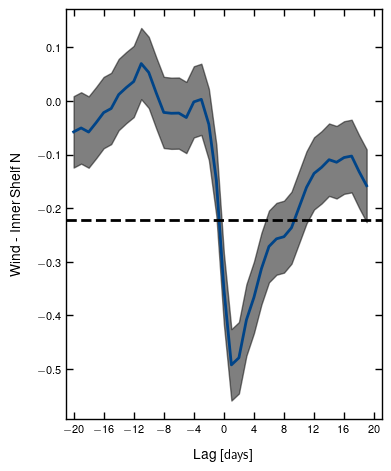

In [ ]:
tdelay = np.arange(-20, 20)
flux_wind_lag_correlation, confint, n = lagged_correlation(
    nitrate.depth_integrated_nitrate,
    wind.coare_y,
    tdelay,
)

n_eff = np.nanmean(n) / 11
alpha = 0.05
rho_crit = np.sqrt(
    distributions.f.isf(alpha, 1, n_eff - 2)
    / (n_eff - 2 + distributions.f.isf(alpha, 1, n_eff - 2))
)

plt.plot(tdelay, flux_wind_lag_correlation)
plt.fill_between(tdelay, confint[:, 0], confint[:, 1], color="black", alpha=0.5)
plt.xlabel("Lag [$\\mathsf{days}$]")
plt.ylabel("Wind - Inner Shelf N")
plt.axhline(-rho_crit, color="k", ls="--")
# plt.fill_between(np.arange(-5, tdelay+5), -rho_crit, rho_crit, color='k', alpha=0.5)
plt.xlim(-21, 21)
# plt.ylim(-0.55, 0.05)
plt.xticks(np.arange(-20, 21, 4))
plt.minorticks_off()
flux_wind_lag_correlation.min()

np.float64(-0.574081571428175)

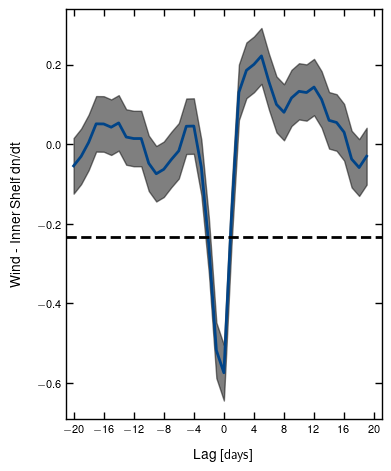

In [ ]:
tdelay = np.arange(-20, 20)
flux_wind_lag_correlation, confint, n = lagged_correlation(
    nitrate.dndt,
    wind.coare_y,
    tdelay,
)

n_eff = np.nanmean(n) / 11
alpha = 0.05
rho_crit = np.sqrt(
    distributions.f.isf(alpha, 1, n_eff - 2)
    / (n_eff - 2 + distributions.f.isf(alpha, 1, n_eff - 2))
)

plt.plot(tdelay, flux_wind_lag_correlation)
plt.fill_between(tdelay, confint[:, 0], confint[:, 1], color="black", alpha=0.5)
plt.xlabel("Lag [$\\mathsf{days}$]")
plt.ylabel("Wind - Inner Shelf dn/dt")
plt.axhline(-rho_crit, color="k", ls="--")
# plt.fill_between(np.arange(-5, tdelay+5), -rho_crit, rho_crit, color='k', alpha=0.5)
plt.xlim(-21, 21)
# plt.ylim(-0.55, 0.05)
plt.xticks(np.arange(-20, 21, 4))
plt.minorticks_off()
flux_wind_lag_correlation.min()

In [ ]:
tdelay = np.arange(-20, 20)
flux_wind_lag_correlation, confint, n = lagged_correlation(
    midshelf_nitrate.dndt,
    wind.coare_y,
    tdelay,
)

n_eff = np.nanmean(n) / 11
alpha = 0.05
rho_crit = np.sqrt(
    distributions.f.isf(alpha, 1, n_eff - 2)
    / (n_eff - 2 + distributions.f.isf(alpha, 1, n_eff - 2))
)

plt.plot(tdelay, flux_wind_lag_correlation)
plt.fill_between(tdelay, confint[:, 0], confint[:, 1], color="black", alpha=0.5)
plt.xlabel("Lag [$\\mathsf{days}$]")
plt.ylabel("Wind - Midshelf Shelf dn/dt")
plt.axhline(-rho_crit, color="k", ls="--")
# plt.fill_between(np.arange(-5, tdelay+5), -rho_crit, rho_crit, color='k', alpha=0.5)
plt.xlim(-21, 21)
# plt.ylim(-0.55, 0.05)
plt.xticks(np.arange(-20, 21, 4))
plt.minorticks_off()
flux_wind_lag_correlation.min()

IndexError: 2-dimensional boolean indexing is not supported. 

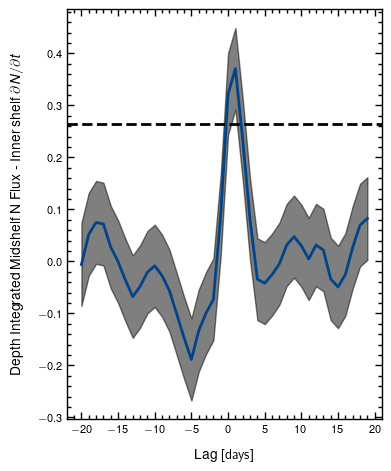

In [ ]:
temp_flux, temp_inner, temp_mid = xr.align(
    velocity_nh10_flux.nitrate_flux_depth_integrated,
    nitrate.dropna("depth", how="all"),
    midshelf_nitrate.dropna("depth", how="all"),
)

flux_nitrate_lag_correlation, confint, n = lagged_correlation(
    temp_flux, (temp_inner.dndt * 7000 / 2), tdelay
)

n_eff = np.mean(n) / 11
alpha = 0.05
rho_crit = np.sqrt(
    distributions.f.isf(alpha, 1, n_eff - 2)
    / (n_eff - 2 + distributions.f.isf(alpha, 1, n_eff - 2))
)

plt.plot(tdelay, flux_nitrate_lag_correlation)
plt.fill_between(tdelay, confint[:, 0], confint[:, 1], color="black", alpha=0.5)
plt.xlabel("Lag [$\\mathsf{days}$]")
plt.ylabel("Depth Integrated Midshelf N Flux - Inner shelf $\\partial N/\\partial t$")
plt.axhline(rho_crit, color="k", ls="--")

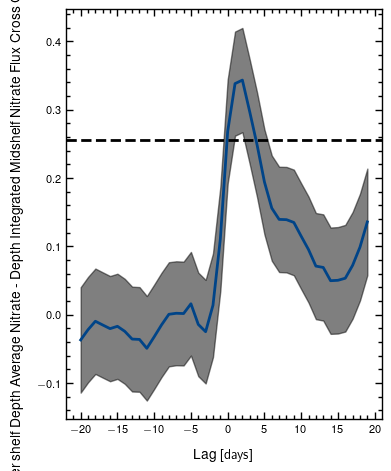

In [ ]:
flux_nitrate_lag_correlation, confint, n = lagged_correlation(
    nitrate.mean(dim="depth").nitrate,
    velocity_nh10_flux.nitrate_flux_depth_integrated,
    tdelay,
)

n_eff = np.mean(n) / 11
alpha = 0.05
rho_crit = np.sqrt(
    distributions.f.isf(alpha, 1, n_eff - 2)
    / (n_eff - 2 + distributions.f.isf(alpha, 1, n_eff - 2))
)

plt.plot(tdelay, flux_nitrate_lag_correlation)
plt.fill_between(tdelay, confint[:, 0], confint[:, 1], color="black", alpha=0.5)
plt.xlabel("Lag [$\\mathsf{days}$]")
plt.ylabel(
    "Inner shelf Depth Average Nitrate - Depth Integrated Midshelf Nitrate Flux Cross Correlation"
)
plt.axhline(rho_crit, color="k", ls="--")

np.float64(0.13775965925012448)

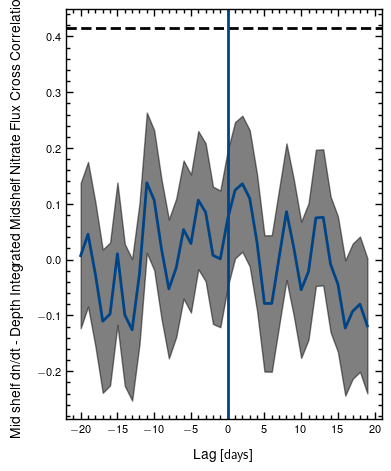

In [ ]:
tdelay = np.arange(-20, 20)
flux_dndt_lag_correlation, confint, n = lagged_correlation(
    midshelf_nitrate.dndt, velocity_nh10_flux.nitrate_flux_depth_integrated, tdelay
)

n_eff = np.mean(n) / 11
alpha = 0.05
rho_crit = np.sqrt(
    distributions.f.isf(alpha, 1, n_eff - 2)
    / (n_eff - 2 + distributions.f.isf(alpha, 1, n_eff - 2))
)

plt.plot(tdelay, flux_dndt_lag_correlation)
plt.fill_between(tdelay, confint[:, 0], confint[:, 1], color="black", alpha=0.5)
plt.xlabel("Lag [$\\mathsf{days}$]")
plt.ylabel("Mid shelf dn/dt - Depth Integrated Midshelf Nitrate Flux Cross Correlation")
plt.axhline(rho_crit, color="k", ls="--")
plt.axvline(0)
flux_dndt_lag_correlation.max()

In [ ]:
# calculate midshelf flux by interpolating nan and filling ends with constant extrapolation, only for profiles with more than 40 depth points
midshelf_nitrate_interp = xr.concat(
    [
        yi.interpolate_na(
            "depth", fill_value=[yi.dropna("depth")[0], yi.dropna("depth")[-1]]
        )
        for yi in midshelf_nitrate.nitrate
        if yi.dropna("depth").size > 40
    ],
    "time",
)
cs_al_midnitr, midnitr_al_cs = xr.align(
    velocity_nh10.cs.dropna("time", how="all"), midshelf_nitrate_interp
)
midshelf_nitrate_flux_depth_integrated = xr.apply_ufunc(
    lambda x, y: np.array(
        [np.trapezoid(yi[~np.isnan(yi)], x[~np.isnan(yi)]) for yi in y]
    ),
    cs_al_midnitr.depth.values,
    (cs_al_midnitr * midnitr_al_cs).values,
)
midshelf_nitrate_flux_depth_integrated = xr.DataArray(
    midshelf_nitrate_flux_depth_integrated, {"time": cs_al_midnitr.time}
)

In [ ]:
midshelf_nitrate_flux_depth_integrated = (
    midshelf_nitrate_flux_depth_integrated.resample(time="1D").mean()
)

In [ ]:
temp_flux, temp_monthly_flux = xr.align(
    velocity_nh10_flux.nitrate_flux_depth_integrated,
    midshelf_nitrate_flux_depth_integrated,
)
mask = ~np.isnan(temp_flux) & ~np.isnan(temp_monthly_flux)
np.corrcoef(temp_flux[mask], temp_monthly_flux[mask])

array([[1.        , 0.90076823],
       [0.90076823, 1.        ]])

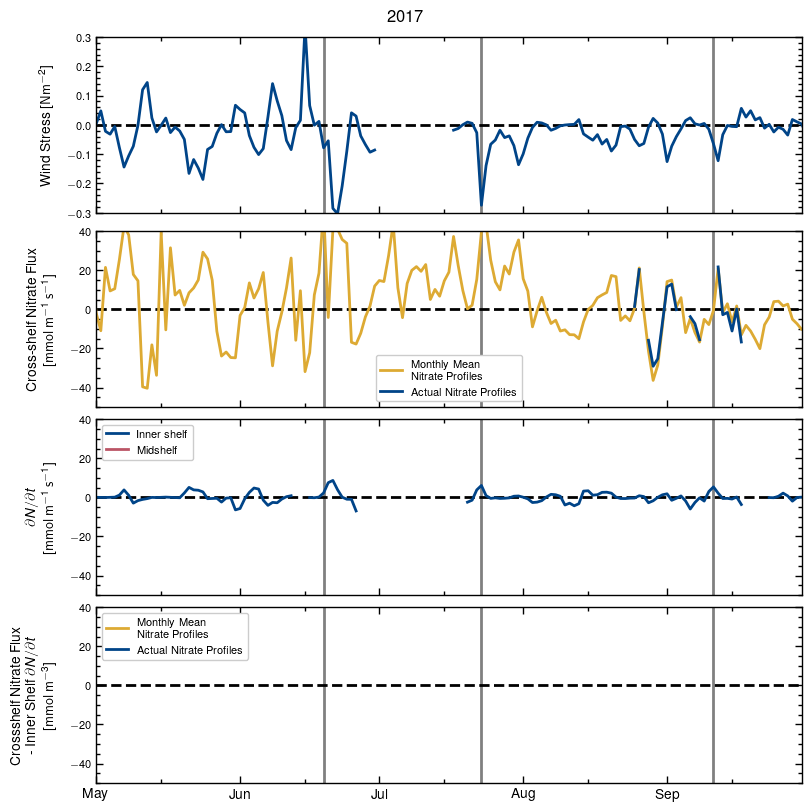

In [ ]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(8, 8))
fig.suptitle("2017")
axs[0].set_xlim(np.datetime64("2017-05-01"), np.datetime64("2017-09-30"))

[axs[0].axvline(cw.time.values[5], color="gray") for cw in composite_wind_events]
[axs[1].axvline(cw.time.values[5], color="gray") for cw in composite_wind_events]
[axs[2].axvline(cw.time.values[5], color="gray") for cw in composite_wind_events]
[axs[3].axvline(cw.time.values[5], color="gray") for cw in composite_wind_events]


axs[0].axhline(0, ls="--", color="black")
axs[0].plot(wind.time, wind.coare_y)
axs[0].set_ylim(-0.3, 0.3)
axs[0].set_ylabel("Wind Stress [$\\mathsf{Nm^{-2}}$]")


axs[1].axhline(0, ls="--", color="black")
axs[1].plot(
    velocity_nh10_flux.time,
    velocity_nh10_flux.nitrate_flux_depth_integrated,
    label="Monthly Mean\nNitrate Profiles",
    color="#DDAA33",
)
axs[1].plot(
    midshelf_nitrate_flux_depth_integrated.time,
    midshelf_nitrate_flux_depth_integrated,
    label="Actual Nitrate Profiles",
    color="#004488",
)
axs[1].set_ylim(-50, 40)
axs[1].set_ylabel("Cross-shelf Nitrate Flux\n[$\\mathsf{mmol \\; m^{-1} \\; s^{-1}}$]")
axs[1].legend(facecolor="white", frameon=True, framealpha=1)


axs[2].axhline(0, ls="--", color="black")
axs[2].plot(nitrate.time, nitrate.dndt * 7000 / 2, label="Inner shelf")
axs[2].plot(
    midshelf_nitrate.time, midshelf_nitrate.dndt * 13000, c="#BB5566", label="Midshelf"
)
axs[2].set_ylim(-50, 40)
axs[2].set_ylabel("$\\partial N/\\partial t$\n[$\\mathsf{mmol \\; m^{-1} \\; s^{-1}}$]")
axs[2].legend(facecolor="white", frameon=True, framealpha=1)


axs[3].axhline(0, ls="--", color="black")
temp_flux, temp_inner, temp_mid = xr.align(
    velocity_nh10_flux.nitrate_flux_depth_integrated,
    nitrate.dropna("depth", how="all"),
    midshelf_nitrate.dropna("depth", how="all"),
)
axs[3].plot(
    temp_flux.time,
    temp_flux - temp_inner.dndt * 7000 / 2 - temp_mid.dndt,
    "-",
    label="Monthly Mean\nNitrate Profiles",
    color="#DDAA33",
)
temp_flux, temp_inner, temp_mid = xr.align(
    midshelf_nitrate_flux_depth_integrated,
    nitrate.dropna("depth", how="all"),
    midshelf_nitrate.dropna("depth", how="all"),
)
axs[3].plot(
    temp_flux.time,
    temp_flux - temp_inner.dndt * 7000 / 2 - temp_mid.dndt,
    "-",
    label="Actual Nitrate Profiles",
    color="#004488",
)
axs[3].set_ylim(-50, 40)
axs[3].set_ylabel(
    "Crossshelf Nitrate Flux\n- Inner Shelf  $\\partial N/\\partial t$\n[$\\mathsf{mmol \\; m^{-3}}$]"
)
axs[3].legend(facecolor="white", frameon=True, framealpha=1)
axs[3].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
axs[3].xaxis.set_major_locator(mdates.MonthLocator())
axs[3].xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
axs[3].tick_params(axis="x", which="major", labelsize=10)

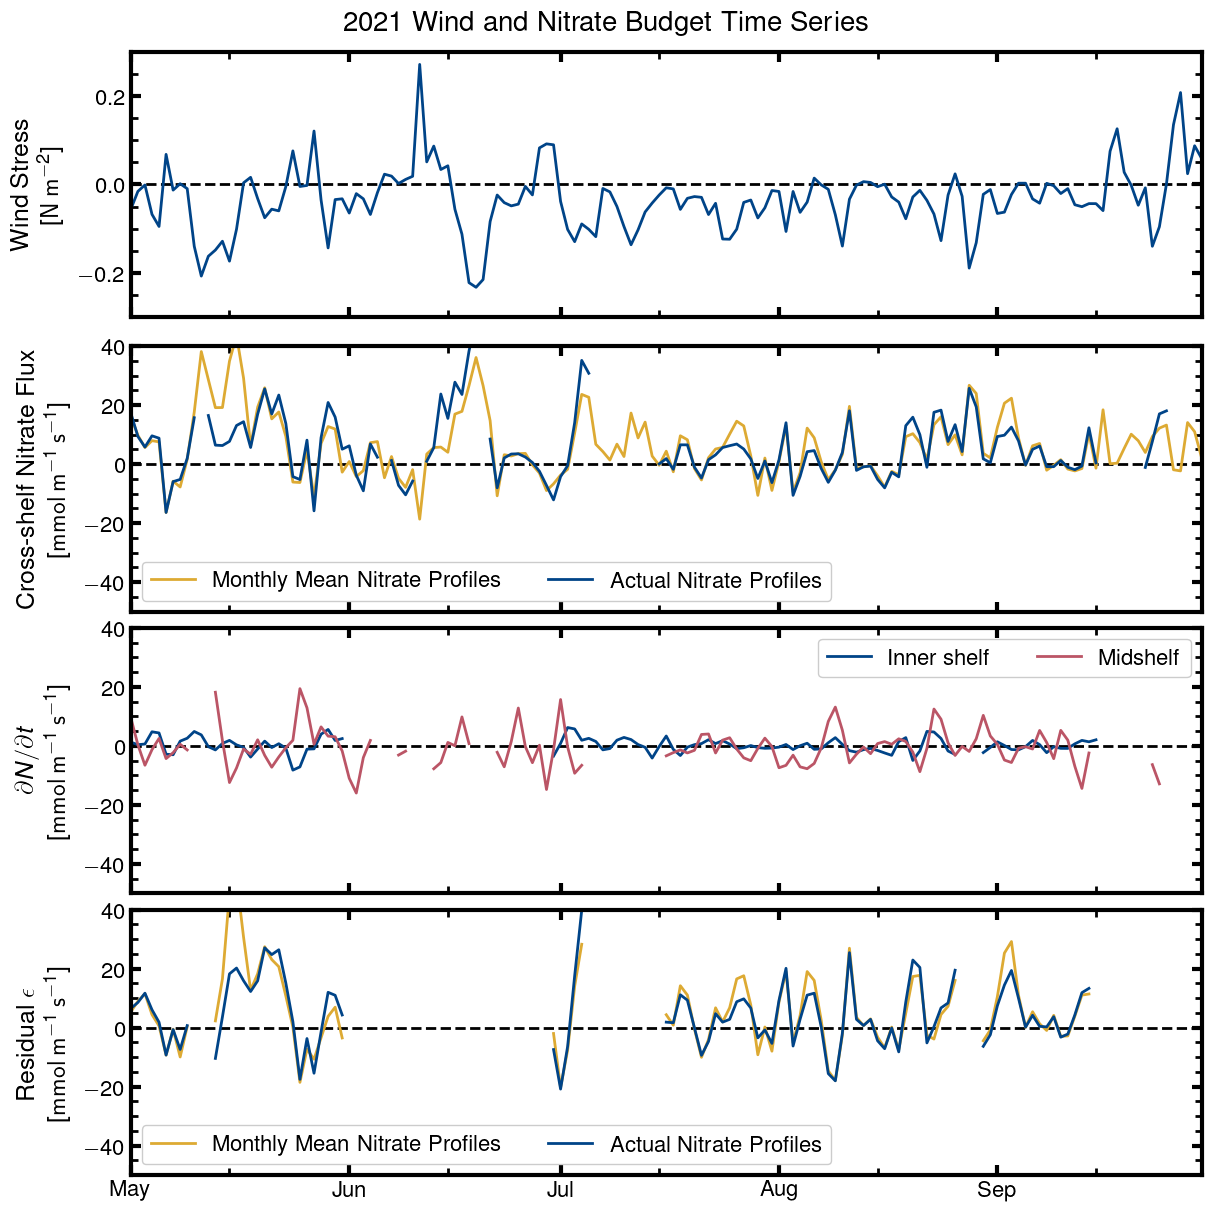

In [ ]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(12, 12))
fig.suptitle("2021 Wind and Nitrate Budget Time Series", fontsize=20)
axs[0].set_xlim(np.datetime64("2021-05-01"), np.datetime64("2021-09-30"))

# [axs[0].axvline(cw.time.values[5], color='gray') for cw in composite_wind_events]
# [axs[1].axvline(cw.time.values[5], color='gray') for cw in composite_wind_events]
# [axs[2].axvline(cw.time.values[5], color='gray') for cw in composite_wind_events]
# [axs[3].axvline(cw.time.values[5], color='gray') for cw in composite_wind_events]
[ax.tick_params(axis="both", width=3, size=7, labelsize=16) for ax in axs]
[ax.tick_params(axis="both", which="minor", width=2, size=5) for ax in axs]

for axis in ["top", "bottom", "left", "right"]:
    [ax.spines[axis].set_linewidth(3) for ax in axs]

# [ax.minorticks_off() for ax in axs]

axs[0].axhline(0, ls="--", color="black")
axs[0].plot(wind.time, wind.coare_y)
axs[0].set_ylim(-0.3, 0.3)
axs[0].set_ylabel("Wind Stress\n[$\\mathsf{N \\; m^{-2}}$]", fontsize=18)


axs[1].axhline(0, ls="--", color="black")
axs[1].plot(
    velocity_nh10_flux.time,
    velocity_nh10_flux.nitrate_flux_depth_integrated,
    label="Monthly Mean Nitrate Profiles",
    color="#DDAA33",
)
axs[1].plot(
    midshelf_nitrate_flux_depth_integrated.time,
    midshelf_nitrate_flux_depth_integrated,
    label="Actual Nitrate Profiles",
    color="#004488",
)
axs[1].set_ylim(-50, 40)
axs[1].set_ylabel(
    "Cross-shelf Nitrate Flux\n[$\\mathsf{mmol \\; m^{-1} \\; s^{-1}}$]", fontsize=18
)
axs[1].legend(facecolor="white", frameon=True, framealpha=1, ncols=2, fontsize=16)


axs[2].axhline(0, ls="--", color="black")
axs[2].plot(nitrate.time, nitrate.dndt * 7000 / 2, label="Inner shelf")
axs[2].plot(
    midshelf_nitrate.time,
    midshelf_nitrate.dndt * 13000 / 2,
    c="#BB5566",
    label="Midshelf",
)
axs[2].set_ylim(-50, 40)
axs[2].set_ylabel(
    "$\\partial N/\\partial t$\n[$\\mathsf{mmol \\; m^{-1} \\; s^{-1}}$]", fontsize=18
)
axs[2].legend(facecolor="white", frameon=True, framealpha=1, ncols=2, fontsize=16)


axs[3].axhline(0, ls="--", color="black")
temp_flux, temp_inner, temp_mid = xr.align(
    velocity_nh10_flux.nitrate_flux_depth_integrated,
    nitrate.dropna("depth", how="all"),
    midshelf_nitrate.dropna("depth", how="all"),
)
axs[3].plot(
    temp_flux.time,
    (temp_flux - temp_inner.dndt * 7000 / 2 - temp_mid.dndt * 13000 / 2),
    "-",
    label="Monthly Mean Nitrate Profiles",
    color="#DDAA33",
)
temp_flux, temp_inner, temp_mid = xr.align(
    midshelf_nitrate_flux_depth_integrated,
    nitrate.dropna("depth", how="all"),
    midshelf_nitrate.dropna("depth", how="all"),
)
axs[3].plot(
    temp_flux.time,
    (temp_flux - temp_inner.dndt * 7000 / 2 - temp_mid.dndt * 13000 / 2),
    "-",
    label="Actual Nitrate Profiles",
    color="#004488",
)
axs[3].set_ylim(-50, 40)
axs[3].set_ylabel(
    "Residual $\\epsilon$\n[$\\mathsf{mmol \\; m^{-1} \\; s^{-1}}$]", fontsize=18
)
axs[3].legend(facecolor="white", frameon=True, framealpha=1, ncols=2, fontsize=16)
axs[3].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
axs[3].xaxis.set_major_locator(mdates.MonthLocator())
axs[3].xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
# axs[3].tick_params(axis='x', which='major', labelsize=10)

# plt.savefig('c:\\Users\\asche\\Desktop\\po-code\\figs\\agu24\\2021_nbudget.svg')

In [ ]:
temp_mid.dndt

<xarray.DataArray 'dndt' (time: 709)> Size: 6kB
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
...
        2.41804573e-03, -5.82729209e-05, -1.42624718e-03, -1.01073486e-03,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan, -5.17557687e-04,
       -3.49815885e-04, -2.08334795e-04, -3.66830139e-04, -2.30577833e-04,
        5.96306136e-04,  6.21240731e-04, -3.69771339e-04,  3.00662993e-04,
        4.26029624e-04, -1.61918903e-04, -6.22972310e-04, -7.71022108e-04,
       -1.30701557e-04,  4.04757300e-04, -3.47739325e-05, -1.13991928e-03,
       -1.01292793e-03, -4.82855581e-04, -1.09245347e-03, -1.18890024e-03,
       -9.14935494e-04, -1.04308524e-04,  1.27675595e-03,  2.02416224e-03,
        8.15530998e-04, -8.86700499e-04, -4.33036863e-04, -5.86957317e-05,
       -4.04267371e-04,  1.22636651e-04,  2.24526318e-04,  8.33064313e-05,
        3.70404554e-04,  2.30558786e-04, -3.23125063e-04, -1.34158890e-03,
       -1.28616536e-04,  1.92263433e-03,  1.39233321e-03,  1.60183325e-04,
       -4.95893191e-04, -2.48632229e-05,  3.73310592e-04,  1.59250599e-03,
        5.20085048e-04,  8.36826738e-05, -7.36927897e-04, -8.66205691e-04,
       -1.22371131e-04, -4.05783378e-05, -1.62540321e-04,  8.06271649e-04,
        1.78072942e-04, -6.64072270e-04,  8.09876775e-04,  3.00006706e-04,
       -1.06590597e-03, -2.21663141e-03, -3.69574014e-04,             nan,
        1.03316176e-03])
Coordinates:
  * time     (time) datetime64[ns] 6kB 2015-06-23 2015-06-24 ... 2021-09-16

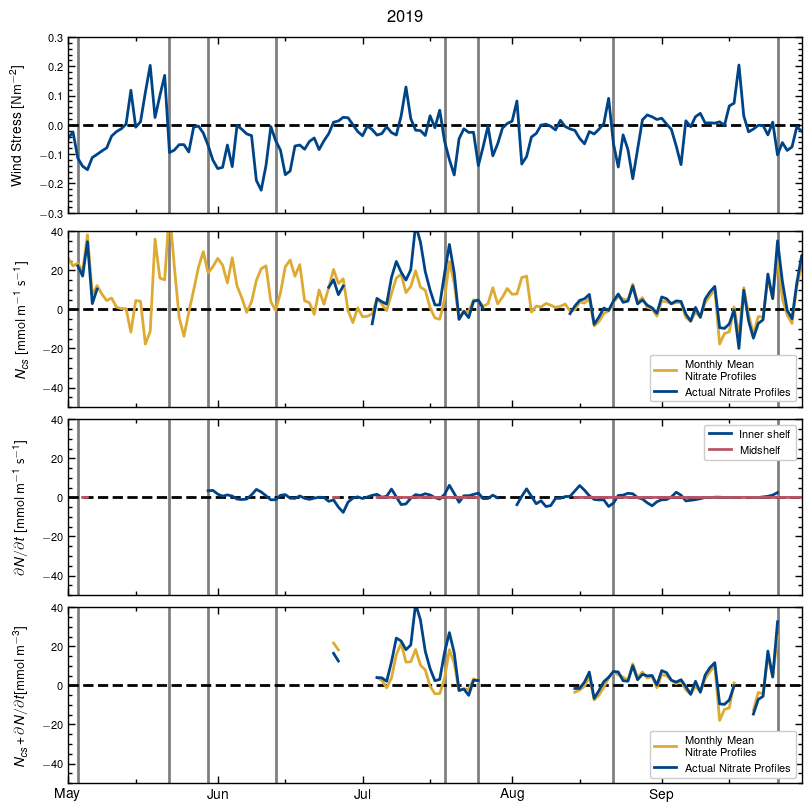

In [ ]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(8, 8))
fig.suptitle("2019")
axs[0].set_xlim(np.datetime64("2019-05-01"), np.datetime64("2019-09-30"))

[axs[0].axvline(cw.time.values[5], color="gray") for cw in composite_wind_events]
[axs[1].axvline(cw.time.values[5], color="gray") for cw in composite_wind_events]
[axs[2].axvline(cw.time.values[5], color="gray") for cw in composite_wind_events]
[axs[3].axvline(cw.time.values[5], color="gray") for cw in composite_wind_events]


axs[0].axhline(0, ls="--", color="black")
axs[0].plot(wind.time, wind.coare_y)
axs[0].set_ylim(-0.3, 0.3)
axs[0].set_ylabel(r"Wind Stress [$\mathsf{Nm^{-2}}$]")


axs[1].axhline(0, ls="--", color="black")
axs[1].plot(
    velocity_nh10_flux.time,
    velocity_nh10_flux.nitrate_flux_depth_integrated,
    label="Monthly Mean\nNitrate Profiles",
    color="#DDAA33",
)
axs[1].plot(
    midshelf_nitrate_flux_depth_integrated.time,
    midshelf_nitrate_flux_depth_integrated,
    label="Actual Nitrate Profiles",
    color="#004488",
)
axs[1].set_ylim(-50, 40)
axs[1].set_ylabel("$N_{cs}$ [$\\mathsf{mmol \\; m^{-1} \\; s^{-1}}$]")
axs[1].legend(facecolor="white", frameon=True, framealpha=1)


axs[2].axhline(0, ls="--", color="black")
axs[2].plot(nitrate.time, nitrate.dndt * 7000 / 2, label="Inner shelf")
axs[2].plot(midshelf_nitrate.time, midshelf_nitrate.dndt, c="#BB5566", label="Midshelf")
axs[2].set_ylim(-50, 40)
axs[2].set_ylabel("$\\partial N/\\partial t$ [$\\mathsf{mmol \\; m^{-1} \\; s^{-1}}$]")
axs[2].legend(facecolor="white", frameon=True, framealpha=1)


axs[3].axhline(0, ls="--", color="black")
temp_flux, temp_inner, temp_mid = xr.align(
    velocity_nh10_flux.nitrate_flux_depth_integrated,
    nitrate.dropna("depth", how="all"),
    midshelf_nitrate.dropna("depth", how="all"),
)
axs[3].plot(
    temp_flux.time,
    temp_flux - temp_inner.dndt * 7000 / 2 - temp_mid.dndt,
    "-",
    label="Monthly Mean\nNitrate Profiles",
    color="#DDAA33",
)
temp_flux, temp_inner, temp_mid = xr.align(
    midshelf_nitrate_flux_depth_integrated,
    nitrate.dropna("depth", how="all"),
    midshelf_nitrate.dropna("depth", how="all"),
)
axs[3].plot(
    temp_flux.time,
    temp_flux - temp_inner.dndt * 7000 / 2 - temp_mid.dndt,
    "-",
    label="Actual Nitrate Profiles",
    color="#004488",
)
axs[3].set_ylim(-50, 40)
axs[3].set_ylabel("$N_{cs} + \\partial N/\\partial t$[$\\mathsf{mmol \\; m^{-3}}$]")
axs[3].legend(facecolor="white", frameon=True, framealpha=1)
axs[3].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
axs[3].xaxis.set_major_locator(mdates.MonthLocator())
axs[3].xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
axs[3].tick_params(axis="x", which="major", labelsize=10)

# plt.savefig('c:\\Users\\asche\\Desktop\\po-code\\figs\\nitrate_new_manuscript_figs\\2019_nbudget.pdf')

In [ ]:
np.nanmedian(temp_flux - temp_inner.dndt * 7000 / 2 - temp_mid.dndt)

np.float64(3.1819124205216758)

## Nitrate Budget Estimate

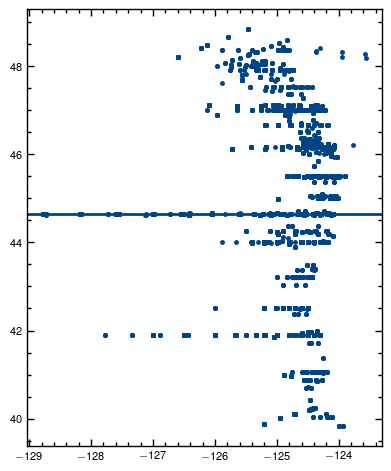

In [ ]:
broadscale = pd.read_csv(
    "../../datasets/broadscale/Nitrate_AllProjects.csv",
    header=0,
    index_col=False,
    names=[
        "id",
        "code",
        "date",
        "transect",
        "station",
        "lat",
        "lon",
        "depth",
        "no2",
        "no3",
        "no2+no3",
        "comments",
    ],
)
broadscale = broadscale.loc[broadscale.lon < 0]
nhl_lat = broadscale.loc[broadscale["transect"] == "Newport Hydrographic"].lat.median()
broadscale = broadscale.loc[(np.abs(broadscale["lat"] - nhl_lat) < 5)]
broadscale["time"] = pd.to_datetime(broadscale.date)
broadscale.set_index("time", inplace=True)
broadscale = broadscale.to_xarray()
plt.plot(broadscale.lon, broadscale.lat, ".")
plt.axhline(nhl_lat)
broadscale["transect_abbr"] = xr.DataArray(
    xr.apply_ufunc(
        lambda d: [re.split("(\\d+)", str(s))[0] for s in d], broadscale.station.values
    ),
    dims="time",
)

In [ ]:
broadscale.where(broadscale.depth < 100).no3.max()

<xarray.DataArray 'no3' ()> Size: 8B
array(39.34120178)

In [ ]:
def bin_profiles(d, z):
    types = [d[i].dtype for i in d]
    var_names = list(d.keys())
    exclude = []
    for i, t in enumerate(types):
        if not (np.issubdtype(t, np.number)):
            exclude.append(var_names[i])
    d = d.drop_vars(exclude)
    out = xarray_reduce(
        d,
        d["time"],
        d["depth"],
        func="nanmean",
        expected_groups=(None, z),
        isbin=[False, True],
        method="map-reduce",
        skipna=True,
    )
    depth = np.array([x.mid for x in out.depth_bins.values])
    out["depth"] = (["depth" + "_bins"], depth)
    out = out.swap_dims({"depth" + "_bins": "depth"})
    return out

In [ ]:
transect_station = np.array(
    [broadscale.transect_abbr.values, broadscale.transect.values]
).T.astype(str)
transect_station = np.unique(transect_station, axis=0)
exclude_transect = transect_station[transect_station[:, 1] == "nan"].T[0]
transect_station = transect_station[
    (transect_station[:, 1] != "nan") & (transect_station[:, 0] != "nan")
]
transect_station = dict(transect_station)
transect_lats = dict(
    zip(
        transect_station.keys(),
        np.array(
            [
                broadscale.where(broadscale.transect_abbr == ta, drop=True)
                .lat.median()
                .values
                for ta in transect_station.keys()
            ]
        ),
    )
)

In [ ]:
stations = np.array(
    [t for t in dict(zip(broadscale.station.values, broadscale.transect.values)).keys()]
)
nhl_lat = (
    broadscale.where(broadscale.transect == "Newport Hydrographic", drop=True)
    .lat.median()
    .data
)
t = "Newport Hydrographic"
broadscale_binned = []
depth = np.concatenate(
    [np.arange(0, 300, 10), np.arange(300, 500, 50), np.arange(500, 4000, 100)]
)
for s in tq(stations):
    if s != "nan" and re.split("(\\d+)", s)[0] not in exclude_transect:
        transect = transect_station[re.split("(\\d+)", s)[0]]
        transect_lat = transect_lats[re.split("(\\d+)", s)[0]]
        lat = (
            broadscale.where(broadscale.transect == transect, drop=True)
            .lat.median()
            .values
        )
        temp = broadscale.where(broadscale.station == s, drop=True)
        temp = bin_profiles(temp, depth)
        lon = temp.lon.median().values
        temp = temp.expand_dims({"station": [s]}).drop_vars("lat")
        temp["lat"] = (["station"], [lat])
        temp["lon"] = (["station"], [lon])
        temp = temp.where(np.abs(temp.lat - transect_lat) < 0.025, drop=True)
        broadscale_binned.append(temp)

broadscale_binned
broadscale_binned = xr.concat(broadscale_binned, dim="station")

# temp

100%|██████████| 408/408 [00:38<00:00, 10.65it/s] 


In [ ]:
len(
    xr.apply_ufunc(
        lambda d: [re.split(r"(\d+)", str(s))[0] for s in d],
        broadscale_binned.station.values,
    )
)

326

In [ ]:
broadscale_binned["transect_abbr"] = xr.DataArray(
    xr.apply_ufunc(
        lambda d: [re.split(r"(\d+)", str(s))[0] for s in d],
        broadscale_binned.station.values,
    ),
    dims="station",
)

In [ ]:
lats = []
for t in transect_station.values():
    lat = broadscale.where(broadscale.transect == t, drop=True).lat.median().values
    lats.append(lat)
lats = np.array(lats)
transect_station = dict(
    np.array(list(transect_station.items()))[np.argsort(lats)][::-1]
)
lats = np.sort(lats)[::-1]
lats

array([48.41999817, 48.37133408, 48.12226486, 48.07925034, 48.03609848,
       47.91999817, 47.68016815, 47.53133392, 47.46666718, 47.37266541,
       47.2763176 , 47.00273514, 46.91608047, 46.67016602, 46.49891663,
       46.49891663, 46.25      , 46.21099854, 46.19966507, 46.15999985,
       46.05466843, 46.03878402, 46.00808334, 45.49750137, 45.37320328,
       45.        , 44.65169907, 44.3719902 , 44.25      , 44.20013428,
       44.        , 43.90000153, 43.40304947, 43.21659851, 43.21659851,
       43.03858566, 42.5       , 42.37389755, 41.90000153, 41.70681763,
       41.37323761, 41.05833054, 40.87039948, 40.7060318 , 40.10978317,
       40.03839874, 39.84120178])

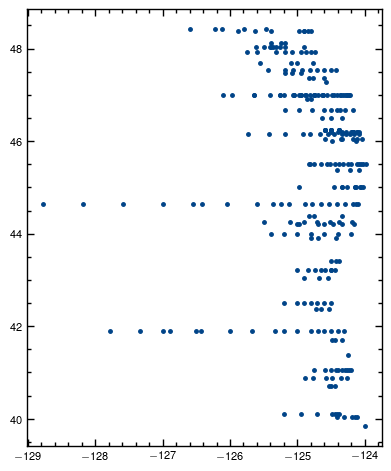

In [ ]:
plt.plot(broadscale_binned.lon, broadscale_binned.lat, ".")

In [ ]:
broadscale_binned.sel(
    station=[s.startswith("NH") for s in broadscale_binned.station.values]
)

<xarray.Dataset> Size: 31MB
Dimensions:        (station: 22, time: 870, depth: 68)
Coordinates:
  * depth          (depth) float64 544B 5.0 15.0 25.0 ... 3.75e+03 3.85e+03
  * time           (time) datetime64[ns] 7kB 1997-03-21 ... 2022-09-26
  * station        (station) object 176B 'NH05' 'NH15' 'NH10' ... 'NH50' 'NH30'
    depth_bins     (depth) object 544B (0, 10] (10, 20] ... (3800, 3900]
Data variables:
    lon            (station) float64 176B -124.2 -124.4 -124.3 ... -125.2 -124.8
    no2            (station, time, depth) float64 10MB nan nan nan ... nan nan
    no3            (station, time, depth) float64 10MB nan nan nan ... nan nan
    no2+no3        (station, time, depth) float64 10MB nan nan nan ... nan nan
    lat            (station) float64 176B 44.65 44.65 44.65 ... 44.65 44.65
    transect_abbr  (station) <U3 264B 'NH' 'NH' 'NH' 'NH' ... 'NH' 'NH' 'NH'

In [ ]:
def reshape_plots(fig, axs, r, c):
    gs = gridspec.GridSpec(r, c, fig)
    for i, (ax, g) in enumerate(zip(axs, gs)):
        ax.set_subplotspec(g)

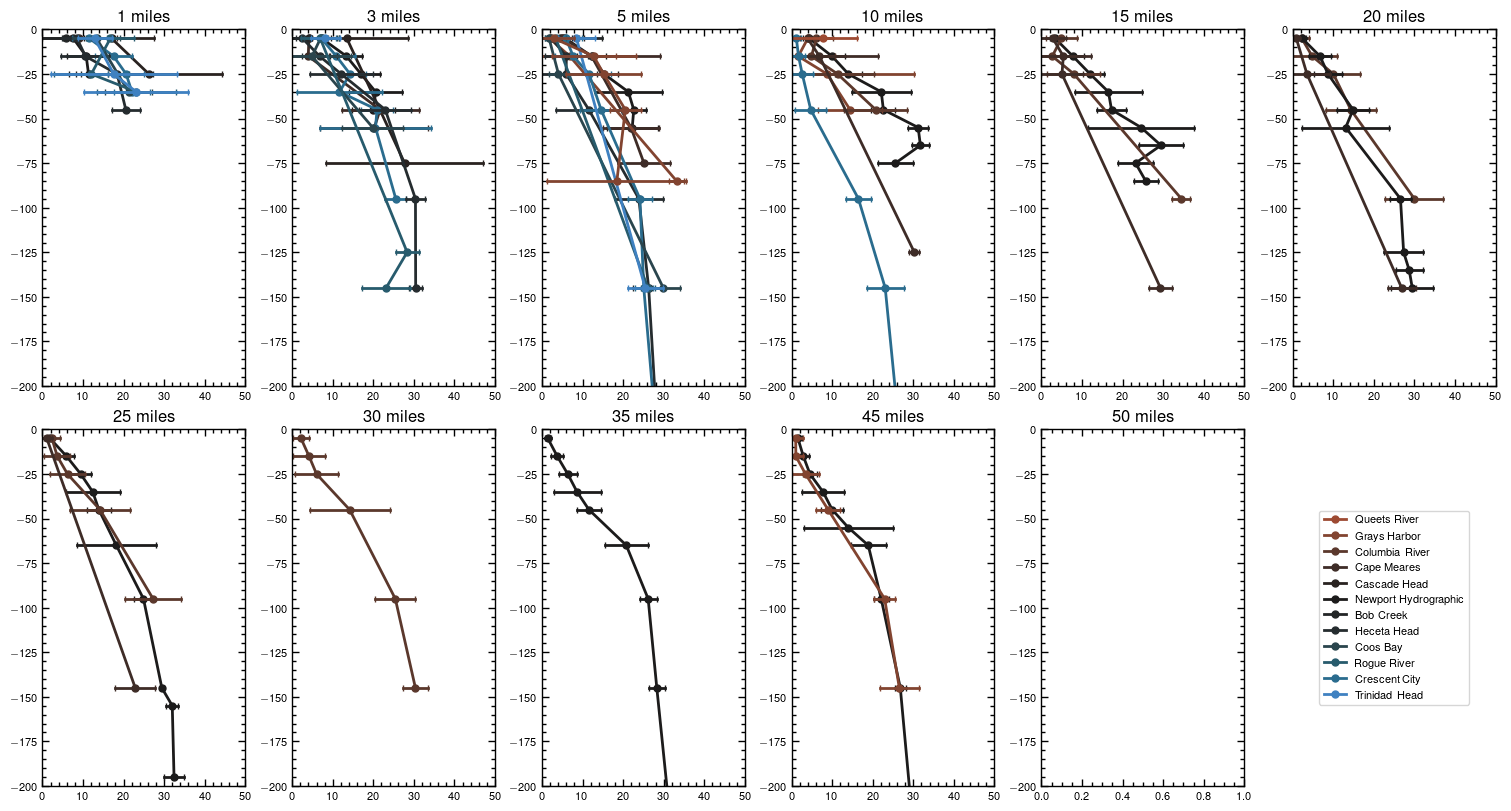

In [ ]:
cc = cycler(marker=["o", "X", "+", "*", "o", "X", "+", "*", "o", "X", "+"]) + cycler(
    color=[
        "#4477AA",
        "#EE6677",
        "#228833",
        "#CCBB44",
        "#66CCEE",
        "#AA3377",
        "#BBBBBB",
        "#4477AA",
        "#EE6677",
        "#228833",
        "#CCBB44",
    ]
)
cc = cycler(
    color=[
        "#CC6677",
        "#332288",
        "#DDCC77",
        "#117733",
        "#88CCEE",
        "#882255",
        "#44AA99",
        "#999933",
        "#AA4499",
        "#DDDDDD",
        "#000000",
    ]
) * cycler(marker=["o"])
cc = list(cc)

cmap = cmo.tools.crop_by_percent(cmo.balance_i, 20, which="both")
lats_reldiff = 0.5 * (lats - nhl_lat) / np.abs((lats - nhl_lat)[-1]) + 0.5

min_count = 3
station_miles = np.array([1, 3, 5, 10, 15, 20, 25, 30, 35, 45, 50])
fig, axs = plt.subplots(1, len(station_miles) + 1, figsize=(15, 8))
handles, labels = [], []
for i, mile in enumerate(station_miles):
    # axs[i].set_prop_cycle(cc)
    axs[i].set_title(f"{mile} miles")
    temp = broadscale_binned.station.values

    for stat in broadscale_binned.station.values:
        temp = broadscale_binned.sel(station=stat)
        if int(re.split("(\\d+)", stat)[1]) == mile:
            broadscale_depth = temp.depth.values
            broadscale_mean = temp.no3.mean(dim="time").values
            broadscale_std = temp.no3.std(dim="time").values
            broadscale_count = temp.no3.count(dim="time").values
            broadscale_depth = broadscale_depth[broadscale_count > min_count]
            broadscale_mean = broadscale_mean[broadscale_count > min_count]
            broadscale_std = broadscale_std[broadscale_count > min_count]
            broadscale_count = broadscale_count[broadscale_count > min_count]
            broadscale_ci = np.array(
                [
                    std / np.sqrt(n) * distributions.t(n - 1).isf(0.025)
                    for std, n in zip(broadscale_std, broadscale_count)
                ]
            )
            cc_idx = list(transect_station.keys()).index(re.split("(\\d+)", stat)[0])
            if len(broadscale_mean) > 0:
                axs[i].plot(
                    broadscale_mean,
                    -broadscale_depth,
                    marker="o",
                    color=cmap(lats_reldiff)[cc_idx],
                    label=transect_station[re.split("(\\d+)", stat)[0]],
                )
                axs[i].plot(
                    np.stack(
                        [
                            broadscale_mean - broadscale_ci,
                            broadscale_mean + broadscale_ci,
                        ]
                    ),
                    np.stack([-broadscale_depth, -broadscale_depth]),
                    marker="|",
                    color=cmap(lats_reldiff)[cc_idx],
                )
                # axs[i].plot(broadscale_count, -broadscale_depth, marker='o', color=cmap(lats_reldiff[cc_idx]))
                axs[i].set_xlim(0, 50)
    hand, lab = axs[i].get_legend_handles_labels()
    handles.append(hand)
    labels.append(lab)

axs[-1].set_axis_off()
reshape_plots(fig, axs, 2, 6)
handles = [hj for hi in handles for hj in hi]
labels = [lj for li in labels for lj in li]
labels, handles = np.array(
    [(hand, lab) for hand, lab in dict(zip(labels, handles)).items()]
).T
handles = handles[
    np.argsort(
        np.array(
            [
                transect_lats[
                    list(transect_station.keys())[
                        list(transect_station.values()).index(lab)
                    ]
                ]
                for lab in labels
            ]
        )
    )[::-1]
]
labels = labels[
    np.argsort(
        np.array(
            [
                transect_lats[
                    list(transect_station.keys())[
                        list(transect_station.values()).index(lab)
                    ]
                ]
                for lab in labels
            ]
        )
    )[::-1]
]
axs[-1].legend(handles, labels, loc="center", bbox_to_anchor=(0.5, 0.5))
[ax.set_ylim(-200, 0) for ax in axs]
pass

[(-200.0, 0.0), (-200.0, 0.0), (-200.0, 0.0), (-200.0, 0.0), (-200.0, 0.0)]

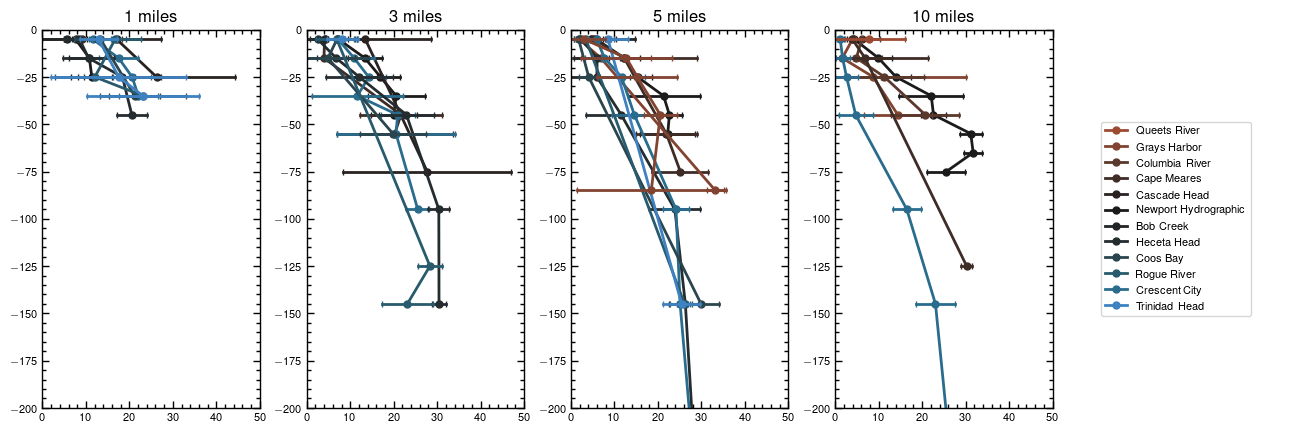

In [ ]:
cc = cycler(marker=["o", "X", "+", "*", "o", "X", "+", "*", "o", "X", "+"]) + cycler(
    color=[
        "#4477AA",
        "#EE6677",
        "#228833",
        "#CCBB44",
        "#66CCEE",
        "#AA3377",
        "#BBBBBB",
        "#4477AA",
        "#EE6677",
        "#228833",
        "#CCBB44",
    ]
)
cc = cycler(
    color=[
        "#CC6677",
        "#332288",
        "#DDCC77",
        "#117733",
        "#88CCEE",
        "#882255",
        "#44AA99",
        "#999933",
        "#AA4499",
        "#DDDDDD",
        "#000000",
    ]
) * cycler(marker=["o"])
cc = list(cc)

cmap = cmo.tools.crop_by_percent(cmo.balance_i, 20, which="both")
lats_reldiff = 0.5 * (lats - nhl_lat) / np.abs((lats - nhl_lat)[-1]) + 0.5

min_count = 3
station_miles = np.array([1, 3, 5, 10])
fig, axs = plt.subplots(1, len(station_miles) + 1, figsize=(15, 8))
handles, labels = [], []
for i, mile in enumerate(station_miles):
    # axs[i].set_prop_cycle(cc)
    axs[i].set_title(f"{mile} miles")
    temp = broadscale_binned.station.values

    for stat in broadscale_binned.station.values:
        temp = broadscale_binned.sel(station=stat)
        if int(re.split("(\\d+)", stat)[1]) == mile:
            broadscale_depth = temp.depth.values
            broadscale_mean = temp.no3.mean(dim="time").values
            broadscale_std = temp.no3.std(dim="time").values
            broadscale_count = temp.no3.count(dim="time").values
            broadscale_depth = broadscale_depth[broadscale_count > min_count]
            broadscale_mean = broadscale_mean[broadscale_count > min_count]
            broadscale_std = broadscale_std[broadscale_count > min_count]
            broadscale_count = broadscale_count[broadscale_count > min_count]
            broadscale_ci = np.array(
                [
                    std / np.sqrt(n) * distributions.t(n - 1).isf(0.025)
                    for std, n in zip(broadscale_std, broadscale_count)
                ]
            )
            cc_idx = list(transect_station.keys()).index(re.split("(\\d+)", stat)[0])
            if len(broadscale_mean) > 0:
                axs[i].plot(
                    broadscale_mean,
                    -broadscale_depth,
                    marker="o",
                    color=cmap(lats_reldiff)[cc_idx],
                    label=transect_station[re.split("(\\d+)", stat)[0]],
                )
                axs[i].plot(
                    np.stack(
                        [
                            broadscale_mean - broadscale_ci,
                            broadscale_mean + broadscale_ci,
                        ]
                    ),
                    np.stack([-broadscale_depth, -broadscale_depth]),
                    marker="|",
                    color=cmap(lats_reldiff)[cc_idx],
                )
                # axs[i].plot(broadscale_count, -broadscale_depth, marker='o', color=cmap(lats_reldiff[cc_idx]))
                axs[i].set_xlim(0, 50)
    hand, lab = axs[i].get_legend_handles_labels()
    handles.append(hand)
    labels.append(lab)

axs[-1].set_axis_off()
reshape_plots(fig, axs, 2, 6)
handles = [hj for hi in handles for hj in hi]
labels = [lj for li in labels for lj in li]
labels, handles = np.array(
    [(hand, lab) for hand, lab in dict(zip(labels, handles)).items()]
).T
handles = handles[
    np.argsort(
        np.array(
            [
                transect_lats[
                    list(transect_station.keys())[
                        list(transect_station.values()).index(lab)
                    ]
                ]
                for lab in labels
            ]
        )
    )[::-1]
]
labels = labels[
    np.argsort(
        np.array(
            [
                transect_lats[
                    list(transect_station.keys())[
                        list(transect_station.values()).index(lab)
                    ]
                ]
                for lab in labels
            ]
        )
    )[::-1]
]
axs[-1].legend(handles, labels, loc="center", bbox_to_anchor=(0.5, 0.5))
[ax.set_ylim(-200, 0) for ax in axs]

In [ ]:
(
    broadscale_binned.sel(
        station=[s.startswith("GH") for s in broadscale_binned.station.values]
    ).lat.mean()
    - broadscale_binned.sel(
        station=[s.startswith("NH") for s in broadscale_binned.station.values]
    ).lat.mean()
)

<xarray.DataArray 'lat' ()> Size: 8B
array(2.35103607)

In [ ]:
(
    broadscale_binned.sel(
        station=[s.startswith("NH") for s in broadscale_binned.station.values]
    ).lat.mean()
    - broadscale_binned.sel(
        station=[s.startswith("TH") for s in broadscale_binned.station.values]
    ).lat.mean()
)

<xarray.DataArray 'lat' ()> Size: 8B
array(3.59336853)

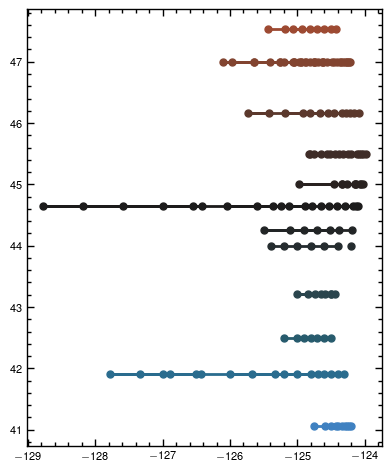

In [ ]:
for (stat, trans), lat_rel in zip(transect_station.items(), lats_reldiff):
    if trans in labels:
        temp = broadscale_binned.where(
            broadscale_binned.transect_abbr == stat, drop=True
        )
        plt.plot(temp.lon, temp.lat, "-o", color=cmap(lat_rel), label=trans)

## 2 Layer Model Computation

Computes the simple model for nearshore nitrate based on a piecewise function utilizing the Sympy library and then integrates over the depth to get a mean depth averaged nitrate predicted by the model.

In [ ]:
bathymetry = xr.open_mfdataset(
    os.path.join(
        notebook_dir,
        "../data/GEBCO/*.nc",
    )
)
bathymetry = bathymetry.isel(
    dict(lat=util.find_nearest(bathymetry["lat"].values, 44.66))
)
bathymetry = bathymetry.interp(dict(lon=np.linspace(-130, -123, int(1e6))))
topo = bathymetry["elevation"].squeeze().values
coast = bathymetry.isel(dict(lon=np.argmin(np.abs(topo))))


bathymetry = bathymetry.interp(dict(lon=np.linspace(-130, -123, int(1e4))))
topo = bathymetry["elevation"].squeeze().values
long = bathymetry.lon.values
lat = bathymetry.lat.values

meters = np.nan * np.zeros(len(long))
for i, lo in enumerate(long):
    meters[i] = util.haversine(long[0], lat, long[i], lat) - util.haversine(
        long[0], lat, coast.lon.values, lat
    )

long = long[meters > -100]
topo = topo[meters > -100]
meters = meters[meters > -100]

delta = 0.01  # nitracline width in meters
step = 0.1
r = 43
h = 125
Nm = 35
zf = np.arange(-100, 100, 0.5)
x0 = 3  # meters[np.argmin(np.abs(long + 124.095))]
bot_depth = topo[np.argmin(np.abs(long + 124.095))]

mod_nit = np.nan * np.zeros((len(nitrate.depth.values), len(zf)))
mod_nda = np.nan * np.zeros(len(zf))

z = symbols("z")
for i in tq(range(len(zf))):
    dn = util.pycno(x0, zf[i], r, h)
    # n_profile = Piecewise(
    #     (0, z > dn + delta/2),
    #     (-Nm/delta*z + Nm*(dn/delta + 1/2), z > dn - delta/2),
    #     (Nm, z < dn - delta/2)
    # )
    n_profile = Piecewise(
        (0, z > dn),
        (Nm, z < dn),
    )
    mod_nit[:, i] = [n_profile.subs(z, val) for val in -nitrate.depth.values]
    mod_nda[i] = integrate(n_profile, (z, bot_depth, 0)) / np.abs(bot_depth)

100%|██████████| 400/400 [00:05<00:00, 74.89it/s]


## NHL Fits

Determines the depth of the 25.8 $\sigma_\theta$ isopycnal as a function of cross-shelf distance for the gridded NHL data. Then fits NHL cross-shelf 25.8 $\sigma_\theta$ transects with a best fit exponential of the form $H - (Z_f-H)exp(-x/R_0)$. Also discards fits with unreasonably large R, H, or Zf.

In [ ]:
# load NHL transects and compute distance from coastline in meters
nhl_grid = xr.load_dataset(
    "../../datasets/ship/Newport_Hydrographic_Line_Data_1997_2021/data_files/newport_hydrographic_line_gridded_sections.nc"
)
nhl_grid = nhl_grid.squeeze()
nhl_grid = nhl_grid.where(nhl_grid.pressure > 10)
nhl_grid["meters"] = -util.haversine(
    nhl_grid["longitude"], nhl_grid["latitude"], -124.0590, nhl_grid["latitude"]
)
print(f"Total number of NHL transects: {len(nhl_grid.time)}")
nhl_grid = nhl_grid.where(
    ((nhl_grid["time.month"] > 3) & (nhl_grid["time.month"] < 11)), drop=True
)
print(f"Total number of summertime NHL transects: {len(nhl_grid.time)}")
# linearly interpolate to find 25.8 isopycnal depth
pycno_depth = np.nan * np.zeros((len(nhl_grid["meters"]), len(nhl_grid["time"])))
for i, x in enumerate(tq(nhl_grid["meters"])):
    for j, t in enumerate(nhl_grid["time"]):
        mask = ~np.isnan(nhl_grid["potential_density"][i, :, j])
        temp = nhl_grid["potential_density"][i, :, j][mask]
        if len(temp > 0):
            try:
                inter = interp1d(
                    nhl_grid["potential_density"][i, :, j][mask],
                    nhl_grid["pressure"][mask],
                )
                pycno_depth[i][j] = inter(25.8)
            except ValueError:
                pycno_depth[i][j] = np.nan
                pass
nhl_grid["pycno_depth"] = (["longitude", "time"], -pycno_depth)
# nhl_grid = nhl_grid.where(nhl_grid.pycno_depth < -10)

# free H code
R = np.nan * np.zeros(len(pycno_depth.T))
R_err = np.nan * np.zeros(len(pycno_depth.T))
Zf = np.nan * np.zeros(len(pycno_depth.T))
Zf_err = np.nan * np.zeros(len(pycno_depth.T))
H = np.nan * np.zeros(len(pycno_depth.T))
H_err = np.nan * np.zeros(len(pycno_depth.T))

nhl_grid["meters"] = -util.haversine(
    nhl_grid["longitude"], nhl_grid["latitude"], -124.0590, nhl_grid["latitude"]
)

for i, d in enumerate(tq(-pycno_depth.T)):
    mask = ~np.isnan(d)
    if len(d[mask]) > 20:
        (Zf[i], R[i], H[i]), cov = curve_fit(
            util.pycno, nhl_grid["meters"][mask], d[mask], p0=[0, 50, 125]
        )  # , bounds=([-np.inf, 0, 0], [np.inf, 1000, 2000])
        (Zf_err[i], R_err[i], H_err[i]) = np.sqrt(np.diagonal(cov))

nhl_grid["R"] = (["time"], R)
nhl_grid["Zf"] = (["time"], Zf)
nhl_grid["H"] = (["time"], H)
nhl_grid["Zf_err"] = (["time"], Zf_err)

nhl_grid = nhl_grid.resample(time="1D").median()
nhl_grid["meters"] = -util.haversine(
    nhl_grid["longitude"], nhl_grid["latitude"], -124.0590, nhl_grid["latitude"]
)

mask = (~np.isnan(nhl_grid.H)) & (~np.isnan(nhl_grid.R)) & (~np.isnan(nhl_grid.Zf))
mask = xr.DataArray(mask, dims=["time"], coords=dict(time=nhl_grid.time.values))
nhl_grid = nhl_grid.where(mask, drop=True)
print(f"Total number of reasonable fits: {len(nhl_grid.time)}")

nhl_grid["meters"] = -util.haversine(
    nhl_grid["longitude"], nhl_grid["latitude"], -124.0590, nhl_grid["latitude"]
)

fit_rmse = np.nan * np.empty(len(nhl_grid.time))
for i, t in enumerate(nhl_grid.time):
    temp = nhl_grid.sel(time=t)
    residuals = temp.pycno_depth - util.pycno(
        temp.meters.values, temp.Zf.values, temp.R.values, temp.H.values
    )
    fit_rmse[i] = ((np.sum(residuals**2) / (residuals.size - 2)) ** 0.5).values

mask = (~np.isnan(nhl_grid.H)) & (~np.isnan(nhl_grid.R)) & (~np.isnan(nhl_grid.Zf))
mask = xr.DataArray(mask, dims=["time"], coords=dict(time=nhl_grid.time.values))
nhl_grid = nhl_grid.where(mask, drop=True)
print(f"Total number of reasonable fits: {len(nhl_grid.time)}")

# # for removing fits with huge R, H
# mask = ((~np.isnan(nhl_grid.H)) & (~np.isnan(nhl_grid.R)) & (~np.isnan(nhl_grid.Zf)))
# mask = xr.DataArray(mask, dims=['time'], coords=dict(time=nhl_grid.time.values))
# nhl_grid = nhl_grid.where(mask, drop=True)
# print(f'Total number of reasonable fits: {len(nhl_grid.time)}')

fit_rmse = np.nan * np.empty(len(nhl_grid.time))
for i, t in enumerate(nhl_grid.time):
    temp = nhl_grid.sel(time=t)
    residuals = temp.pycno_depth - util.pycno(
        temp.meters.values, temp.Zf.values, temp.R.values, temp.H.values
    )
    fit_rmse[i] = ((np.sum(residuals**2) / (residuals.size - 2)) ** 0.5).values

Total number of NHL transects: 556
Total number of summertime NHL transects: 396


100%|██████████| 396/396 [00:09<00:00, 40.13it/s]


Total number of reasonable fits: 320
Total number of reasonable fits: 320


100%|██████████| 5/5 [00:12<00:00,  2.42s/it]


163

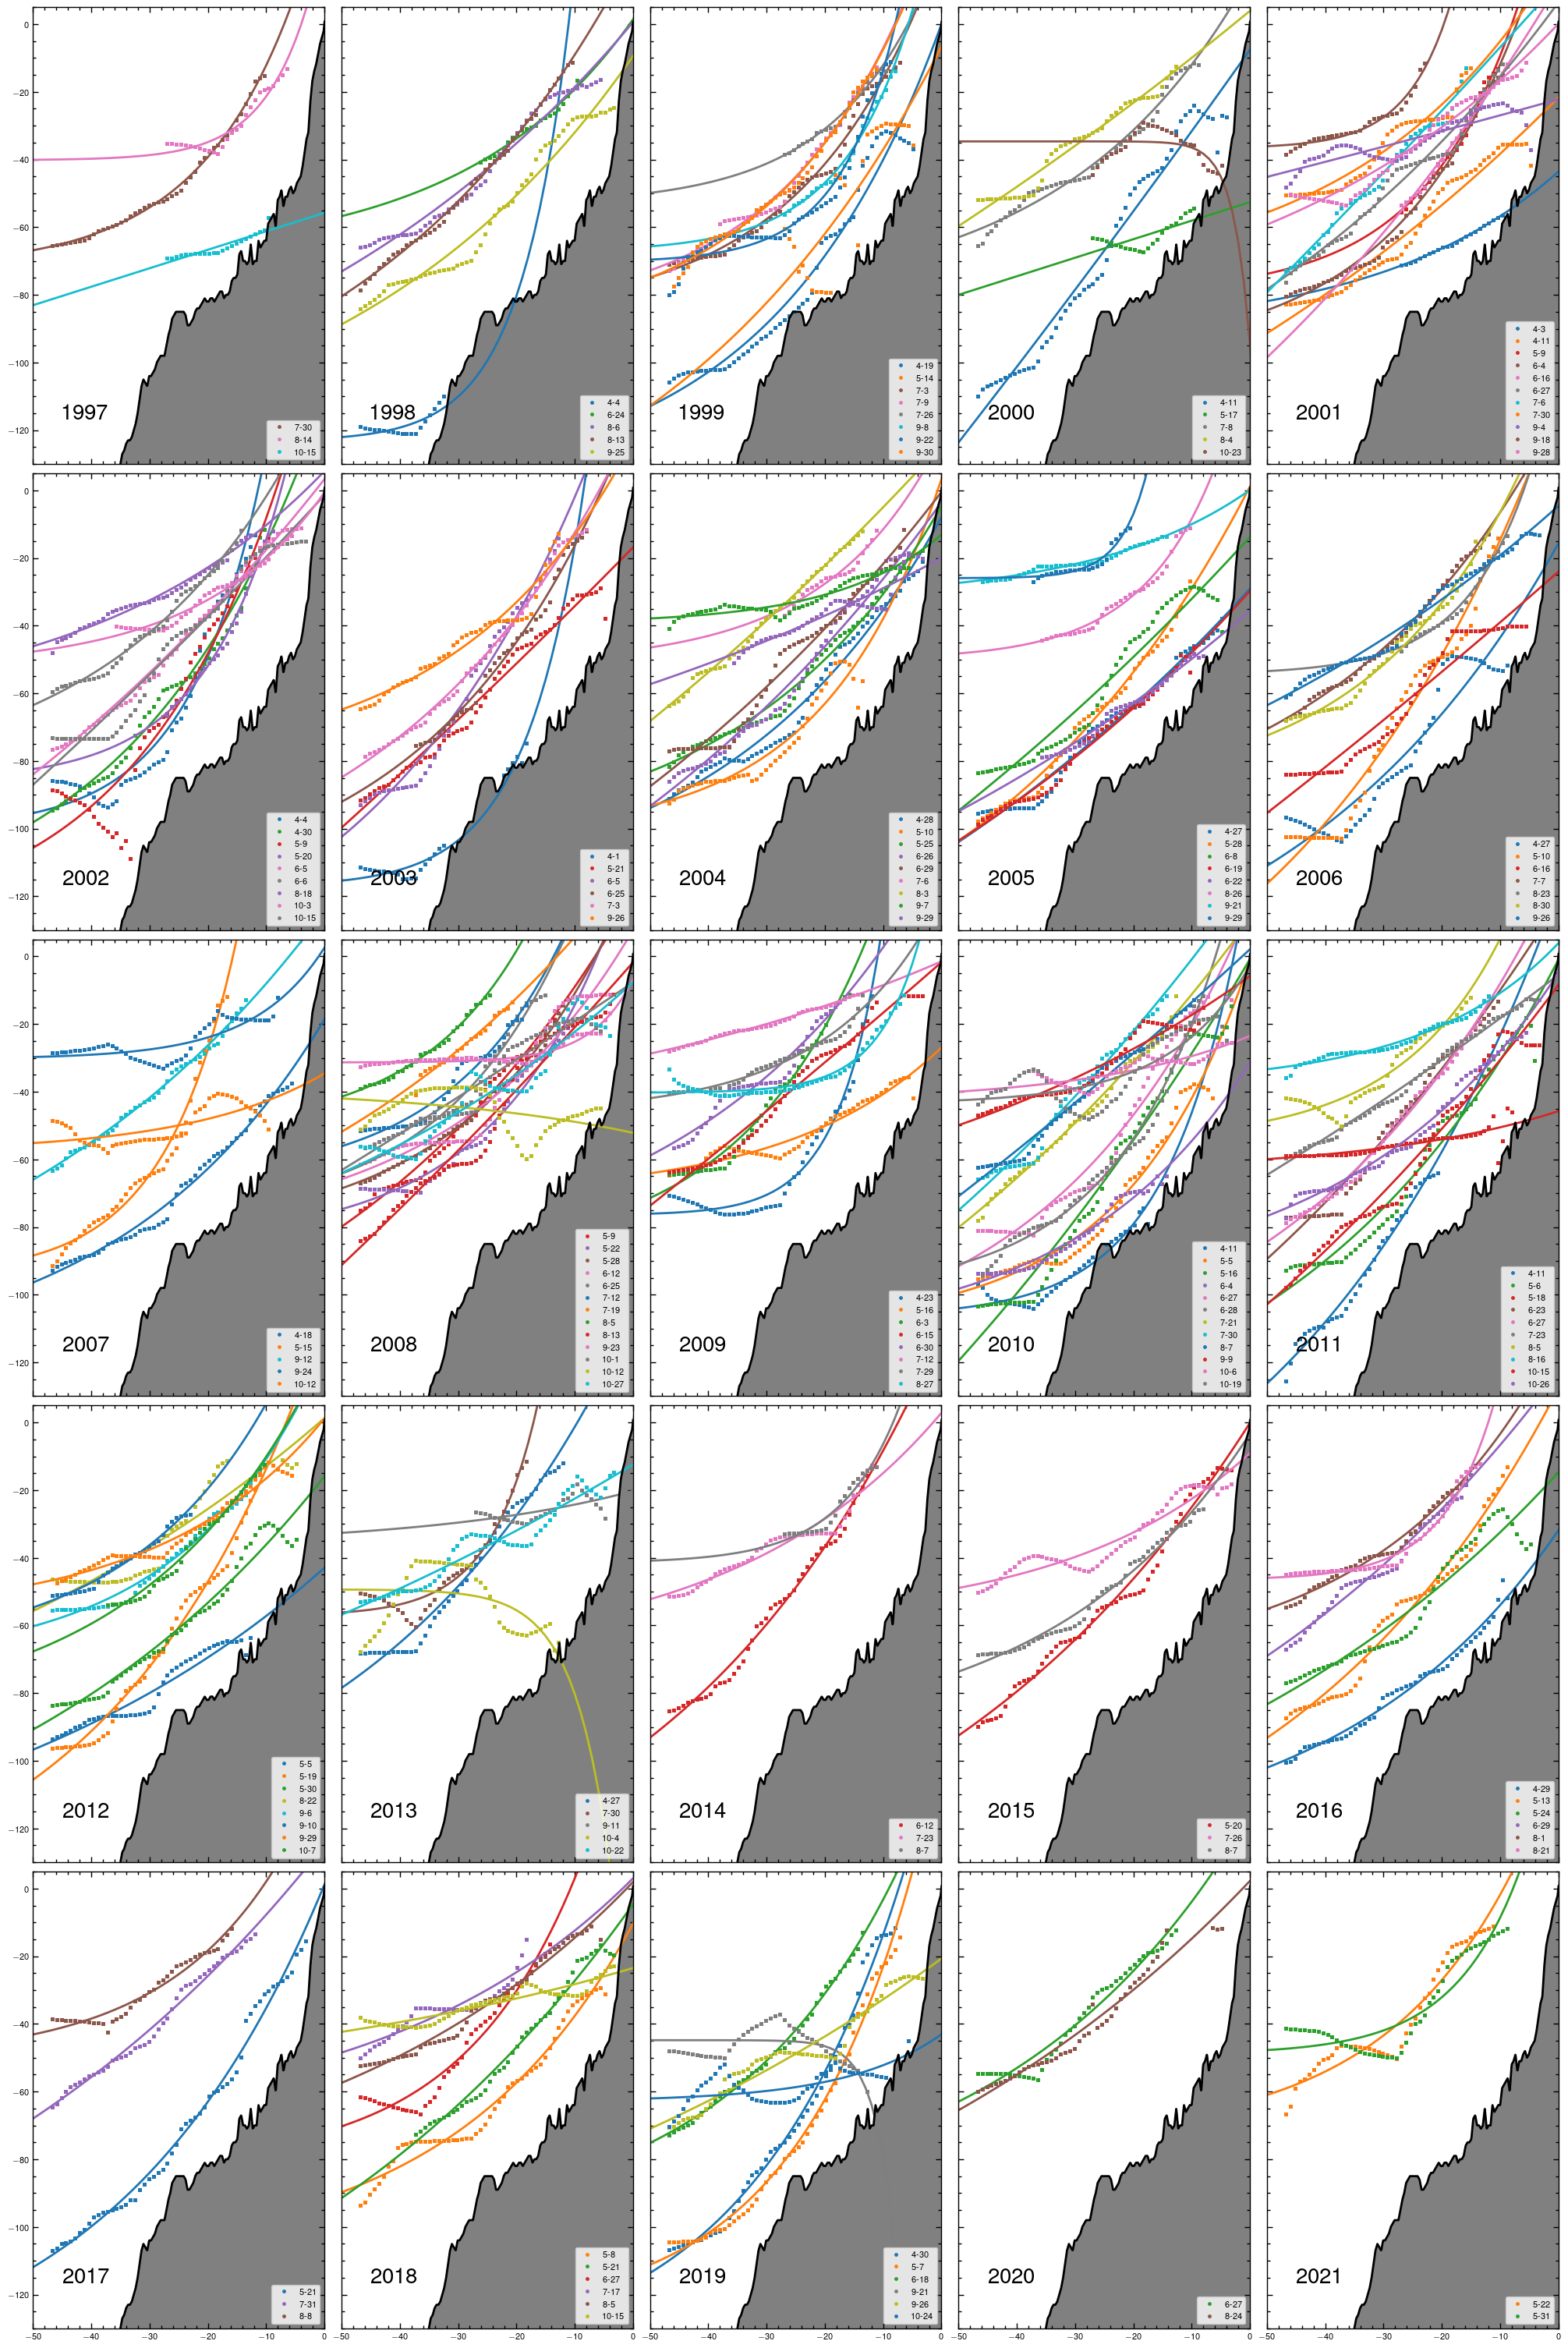

In [ ]:
# plot transects and fits
col = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]
trange = np.arange(
    np.datetime64("1997"),
    np.datetime64("2022"),
    np.timedelta64(1, "Y"),
    dtype="datetime64[Y]",
)
tdelta = np.timedelta64(1, "Y")
rows = 5
cols = 5
N = 0
fig, axs = plt.subplots(5, 5, figsize=(20, 30), sharex=True, sharey=True)
for r in tq(range(rows)):
    for c in range(cols):
        mask = (nhl_grid["time"] >= trange[5 * r + c % 5]) & (
            nhl_grid["time"] < trange[5 * r + c % 5] + tdelta
        )
        for i, (t, d, Zf, R, H) in enumerate(
            zip(
                nhl_grid["time"][mask].values,
                nhl_grid["pycno_depth"][mask].values,
                nhl_grid["Zf"][mask].values,
                nhl_grid["R"][mask].values,
                nhl_grid["H"][mask].values,
            )
        ):
            mask = ~np.isnan(d) & (nhl_grid.meters.T[0] < -10)
            ymd = util.dt2cal(t)[0:3]
            if len(d[mask]) > 15:
                if R < 999:
                    axs[r][c].plot(
                        nhl_grid["meters"],
                        d,
                        ".",
                        label=f"{ymd[1]}-{ymd[2]}",
                        c=col[i % len(col)],
                    )
                    axs[r][c].plot(
                        np.arange(-50, 5),
                        util.pycno(np.arange(-50, 5), Zf, R, H),
                        c=col[i % len(col)],
                    )
                    N += 1
        axs[r][c].annotate(ymd[0], xy=(0.1, 0.1), xycoords="axes fraction", fontsize=20)
        axs[r][c].fill_between(meters, -1000, topo, color="grey")
        axs[r][c].plot(meters, topo, color="black")
        handles, labels = axs[r][c].get_legend_handles_labels()
        by_label = dict(
            zip(labels, handles)
        )  # dicts can't have duplicate keys, avoids duplicate legend entries
        axs[r][c].legend(by_label.values(), by_label.keys(), loc="lower right")
        axs[r][c].set_ylim([-130, 5])
        axs[r][c].set_xlim([-50, 0])
N

## Zf, R, H Time Series

R median: 31.31
H median: 92.30


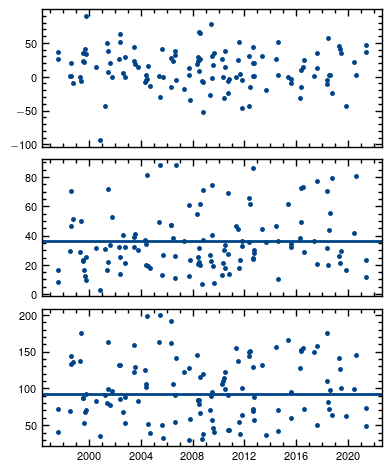

In [ ]:
fig, axs = plt.subplots(3, 1, sharex=True)
mask = (
    (nhl_grid.Zf < 100)
    & (nhl_grid.Zf > -100)
    & (nhl_grid.R < 100)
    & (nhl_grid.R > -100)
    & (nhl_grid.H < 200)
)
axs[0].plot(nhl_grid.time[mask], nhl_grid.Zf[mask], ".")
# axs[0].plot(nhl_grid.time, nhl_grid.Zf, '.')
# axs[0].set_ylim(-75, 125)
axs[1].plot(nhl_grid.time[mask], nhl_grid.R[mask], ".")
# axs[1].plot(nhl_grid.time, nhl_grid.R, '.')
# axs[1].set_ylim(-10, 200)
# axs[1].set_yscale('log')
axs[1].axhline(np.nanmean(nhl_grid.R[mask]))
# axs[1].axhline(np.nanmedian(nhl_grid.R))
axs[2].plot(nhl_grid.time[mask], nhl_grid.H[mask], ".")
# axs[2].plot(nhl_grid.time, nhl_grid.H, '.')
# axs[2].set_ylim(1, 2100)
# axs[2].set_yscale('log')
axs[2].axhline(np.nanmedian(nhl_grid.H[mask]))
# axs[2].axhline(np.nanmedian(nhl_grid.H))
print(f"R median: {np.nanmedian(nhl_grid.R[mask]):.2f}")
# print(f'R mean: {np.nanmedian(nhl_grid.R):.2f}')
print(f"H median: {np.nanmedian(nhl_grid.H[mask]):.2f}")
# print(f'H mean: {np.nanmedian(nhl_grid.H):.2f}')

## 25.8 Fit

Text(0.07, 0.63, '25.8 $\\sigma_{\\theta}$ Gridded\nTransect Data')

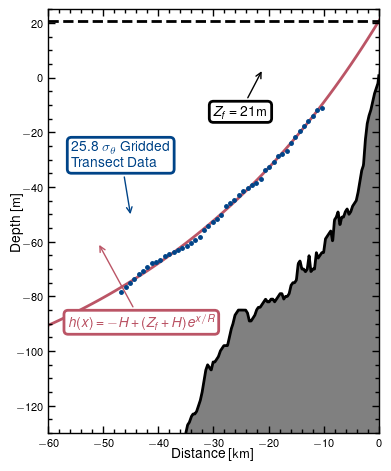

In [ ]:
fig, axs = plt.subplots()
d = nhl_grid.isel(time=15)
mask = ~np.isnan(d)
axs.plot(d["meters"], d["pycno_depth"], ".")
axs.plot(
    np.arange(-60, 5),
    util.pycno(np.arange(-60, 5), d.Zf.values, d.R.values, d.H.values),
    zorder=1,
    c="#BB5566",
)
axs.fill_between(meters, -1000, topo, color="grey")
axs.plot(meters, topo, color="black")
axs.set_ylim([-130, 25])
axs.set_xlim([-60, 0])
axs.set_xlabel("Distance [$\\mathsf{km}$]", labelpad=0)
axs.set_ylabel("Depth [$\\mathsf{m}$]", labelpad=-5)
bbox = dict(boxstyle="round", fc="w", ec="#BB5566", lw=2)
axs.annotate(
    "$h(x)=-H+(Z_f+H)e^{x/R}$",
    xy=(0.15, 0.45),
    xytext=(0.06, 0.25),
    xycoords="axes fraction",
    fontsize=10,
    bbox=bbox,
    arrowprops=dict(arrowstyle="->", color="#BB5566"),
    color="#BB5566",
)
axs.axhline(d.Zf, ls="--", color="k")
bbox = dict(boxstyle="round", fc="w", ec="k", lw=2)
axs.annotate(
    f"$Z_f={d.Zf.values:.0f} \\mathsf{{m}}$",
    xy=(0.65, 0.86),
    xytext=(0.5, 0.75),
    xycoords="axes fraction",
    fontsize=10,
    bbox=bbox,
    arrowprops=dict(arrowstyle="->", color="k"),
    color="k",
)
bbox = dict(boxstyle="round", fc="w", ec="#004488", lw=2)
axs.annotate(
    "25.8 $\\sigma_{\\theta}$ Gridded\nTransect Data",
    xy=(0.25, 0.51),
    xytext=(0.07, 0.63),
    xycoords="axes fraction",
    fontsize=10,
    bbox=bbox,
    arrowprops=dict(arrowstyle="->", color="#004488"),
    color="#004488",
)
# if savefigs:
#     plt.savefig("../../figs/pycno_fit.png", dpi=600)

## Zf-Wind Fit

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.513
Model:                            WLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     275.7
Date:                Thu, 06 Mar 2025   Prob (F-statistic):           8.66e-43
Time:                        18:28:44   Log-Likelihood:                -1188.2
No. Observations:                 264   AIC:                             2380.
Df Residuals:                     262   BIC:                             2388.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -18.0970      0.779    -23.240      0.000     -19.630     -16.564
x1          -400.9433     24.149    -16.603      0.000    -448.494    -353.392
==============================================================================
Omnibus:                       72.734   Durbin-Watson:                   1.216
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              156.146
Skew:                          -1.352   Prob(JB):                     1.24e-34
Kurtosis:                       5.623   Cond. No.                         32.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

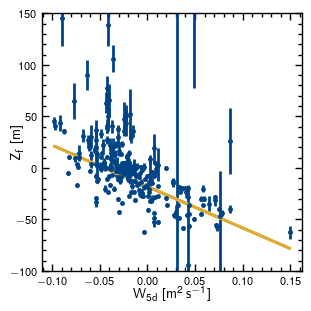

In [ ]:
wind_use = "w5d"
wind_al_nhl, nhl_al_wind = xr.align(wind, nhl_grid)
m = util.dt2cal(nhl_al_wind["time"].values).T[1]
mask = (~np.isnan(nhl_al_wind.Zf)) & (~np.isnan(wind_al_nhl[wind_use]))
wls_fit = sm.WLS(
    nhl_al_wind["Zf"][mask].values,
    sm.add_constant(wind_al_nhl[wind_use][mask].values),
    1 / (nhl_al_wind["Zf_err"][mask].values ** 2),
).fit()
fit = wls_fit.params[::-1]
r_squared = wls_fit.rsquared

fig, ax = plt.subplots(figsize=(3, 3))
ax.errorbar(
    wind_al_nhl[wind_use][mask],
    nhl_al_wind["Zf"][mask],
    nhl_al_wind["Zf_err"][mask],
    linestyle="",
    marker=".",
    elinewidth=2,
)
ax.plot(
    wind_al_nhl[wind_use][mask],
    wind_al_nhl[wind_use][mask] * fit[0] + fit[1],
    label=f"$\\beta_0$={fit[1]:.2f}\n$\\beta_1$={fit[0]:.2f}",
)
ax.set_ylim(-100, 150)
ax.set_xlabel("$\\mathsf{W_{5d}}$ [$\\mathsf{m^2 \\; s^{-1}}$]", labelpad=0)
ax.set_ylabel("$\\mathsf{Z_f}$ [$\\mathsf{m}$]", labelpad=-10)
bbox = dict(boxstyle="round", fc="w")
# ax.annotate(
#     f'$\\beta_0={fit[1]:.2f}$ $\\mathsf{{m}}$\n$\\beta_1={fit[0]:.2f}$ $\\mathsf{{s/m}}$\n${{R^2={r_squared:.2f}}}$',
#     xy=(0.95, 0.95),
#     xycoords='axes fraction',
#     bbox=bbox,
#     fontsize=10,
#     ha='right',
#     va='top'
# )
wls_fit.summary()

Text(0.85, 0.05, '(c)')

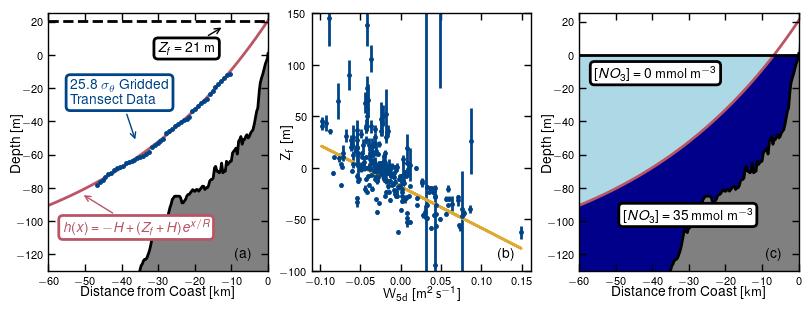

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(8, 3))


d = nhl_grid.isel(time=15)
mask = ~np.isnan(d)
axs[0].plot(d["meters"], d["pycno_depth"], ".")
axs[0].plot(
    np.arange(-60, 5),
    util.pycno(np.arange(-60, 5), d.Zf.values, d.R.values, d.H.values),
    zorder=1,
    c="#BB5566",
)
axs[0].fill_between(meters, -1000, topo, color="grey")
axs[0].plot(meters, topo, color="black")
axs[0].set_ylim([-130, 25])
axs[0].set_xlim([-60, 0])
axs[0].set_xlabel("Distance from Coast [$\\mathsf{km}$]", labelpad=0)
axs[0].set_ylabel("Depth [$\\mathsf{m}$]", labelpad=-5)
axs[0].minorticks_off()
bbox = dict(boxstyle="round", fc="w", ec="#BB5566", lw=2)
axs[0].annotate(
    "$h(x)=-H+(Z_f+H)e^{x/R}$",
    xy=(0.15, 0.3),
    xytext=(0.4, 0.15),
    xycoords="axes fraction",
    fontsize=10,
    bbox=bbox,
    arrowprops=dict(arrowstyle="->", color="#BB5566"),
    color="#BB5566",
    ha="center",
)
axs[0].axhline(d.Zf, ls="--", color="k")
bbox = dict(boxstyle="round", fc="w", ec="k", lw=2)
axs[0].annotate(
    f"$Z_f={d.Zf.values:.0f} \\; \\mathsf{{m}}$",
    xy=(0.8, 0.95),
    xytext=(0.5, 0.85),
    xycoords="axes fraction",
    fontsize=10,
    bbox=bbox,
    arrowprops=dict(arrowstyle="->", color="k"),
    color="k",
)
bbox = dict(boxstyle="round", fc="w", ec="#004488", lw=2)
axs[0].annotate(
    "25.8 $\\sigma_{\\theta}$ Gridded\nTransect Data",
    xy=(0.4, 0.5),
    xytext=(0.1, 0.65),
    xycoords="axes fraction",
    fontsize=10,
    bbox=bbox,
    arrowprops=dict(arrowstyle="->", color="#004488"),
    color="#004488",
)


# compare results below for rough estimates from AB 2002: a~=-0.85,b~=-23
mask = (~np.isnan(nhl_al_wind.Zf)) & (~np.isnan(wind_al_nhl[wind_use]))
axs[1].errorbar(
    wind_al_nhl[wind_use][mask],
    nhl_al_wind["Zf"][mask],
    nhl_al_wind["Zf_err"][mask],
    linestyle="",
    marker=".",
    elinewidth=2,
)
axs[1].plot(
    wind_al_nhl[wind_use][mask],
    wind_al_nhl[wind_use][mask] * fit[0] + fit[1],
    label=f"$\\beta_0$={fit[1]:.2f}\n$\\beta_1$={fit[0]:.2f}",
)
axs[1].set_ylim(-100, 150)
axs[1].set_xlabel("$\\mathsf{W_{5d}}$ [$\\mathsf{m^2 \\; s^{-1}}$]", labelpad=0)
axs[1].set_ylabel("$\\mathsf{Z_f}$ [$\\mathsf{m}$]", labelpad=-10)
axs[1].minorticks_off()
bbox = dict(boxstyle="round", fc="w")
# axs[1].annotate(f'$\\beta_0={fit[1]:.2f}$ $\\mathsf{{m}}$\n$\\beta_1={fit[0]:.2f}$ $\\mathsf{{s/m}}$\n${{R^2={r_squared:.2f}}}$', xy=(0.95, 0.95), xycoords='axes fraction', bbox=bbox, fontsize=10, ha='right', va='top')


d = nhl_grid.isel(time=15)
mask = ~np.isnan(d)
axs[2].fill_between(
    np.arange(-60, 5)[
        util.pycno(np.arange(-60, 5), d.Zf.values, d.R.values, d.H.values) < 0
    ],
    util.pycno(np.arange(-60, 5), d.Zf.values, d.R.values, d.H.values)[
        util.pycno(np.arange(-60, 5), d.Zf.values, d.R.values, d.H.values) < 0
    ],
    0,
    color="lightblue",
)
axs[2].fill_between(
    np.arange(-60, 5)[
        util.pycno(np.arange(-60, 5), d.Zf.values, d.R.values, d.H.values) < 0
    ],
    -1000,
    util.pycno(np.arange(-60, 5), d.Zf.values, d.R.values, d.H.values)[
        util.pycno(np.arange(-60, 5), d.Zf.values, d.R.values, d.H.values) < 0
    ],
    color="darkblue",
)
axs[2].fill_between(
    np.arange(-60, 5)[
        util.pycno(np.arange(-60, 5), d.Zf.values, d.R.values, d.H.values) >= -1
    ],
    -1000,
    0,
    color="darkblue",
)
axs[2].plot(
    np.arange(-60, 5),
    util.pycno(np.arange(-60, 5), d.Zf.values, d.R.values, d.H.values),
    zorder=1,
    c="#BB5566",
)
axs[2].fill_between(meters, -1000, topo, color="grey")
axs[2].plot(meters, topo, color="black")
axs[2].axhline(0, c="k")
axs[2].set_ylim([-130, 25])
axs[2].set_xlim([-60, 0])
axs[2].set_xlabel("Distance from Coast [$\\mathsf{km}$]", labelpad=0)
axs[2].set_ylabel("Depth [$\\mathsf{m}$]", labelpad=-5)
axs[2].minorticks_off()
bbox = dict(boxstyle="round", fc="w", ec="k", lw=2)
axs[2].annotate(
    "$[NO_3]=0 \\; \\mathsf{mmol \\; m^{-3}}$",
    xy=(0.07, 0.75),
    xytext=(0.07, 0.75),
    xycoords="axes fraction",
    fontsize=10,
    bbox=bbox,
    arrowprops=dict(arrowstyle="->", color="k"),
    color="k",
)
bbox = dict(boxstyle="round", fc="w", ec="k", lw=2)
axs[2].annotate(
    "$[NO_3]=35 \\; \\mathsf{mmol \\; m^{-3}}$",
    xy=(0.2, 0.2),
    xytext=(0.2, 0.2),
    xycoords="axes fraction",
    fontsize=10,
    bbox=bbox,
    arrowprops=dict(arrowstyle="->", color="k"),
    color="k",
)


axs[0].annotate("(a)", xy=(0.85, 0.05), xycoords="axes fraction", fontsize=10)
axs[1].annotate("(b)", xy=(0.85, 0.05), xycoords="axes fraction", fontsize=10)
axs[2].annotate("(c)", xy=(0.85, 0.05), xycoords="axes fraction", fontsize=10)


# if savefigs:
# plt.savefig('../../figs/pycno_fit.png', dpi=600)
# plt.savefig('../../figs/nitrate_new_manuscript_figs/simple_model.pdf')

## Nitrate-Density

Mean N below 25.8 sigma: 6.761072682611403
Mean N above 25.8 sigma: 25.888516655563475


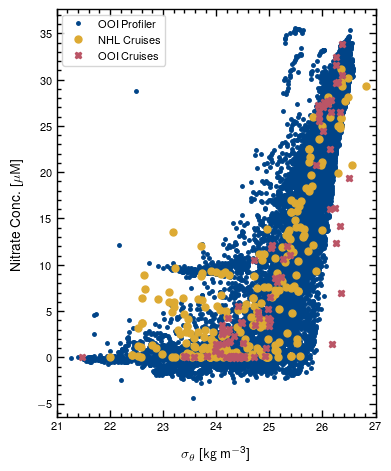

In [ ]:
fig, ax = plt.subplots()
ax.plot(nitrate.density, nitrate.nitrate, ".", color="#004488", label="OOI Profiler")
ax.plot(
    nhl_crse.potential_density,
    nhl_crse.nitrate,
    "o",
    color="#DDAA33",
    label="NHL Cruises",
)
ax.plot(
    ooi_crse.pot_density_anom,
    ooi_crse.nitrate,
    "X",
    color="#BB5566",
    label="OOI Cruises",
)
ax.set_xlim(21, 27)
ax.set_xlabel("$\\sigma_{\\theta}$ [$\\mathsf{kg \\; m^{-3}}$]")
ax.set_ylabel("Nitrate Conc. [$\\mathsf{\\mu M}$]")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(
    zip(labels, handles)
)  # dicts can't have duplicate keys, avoids duplicate legend entries
ax.legend(by_label.values(), by_label.keys())
# if savefigs:
#     plt.savefig('../../figs/nitrate-denisty.png', dpi=600)
print(
    f"Mean N below 25.8 sigma: {np.nanmean(nitrate.where(nitrate.density < 25.8).nitrate)}"
)
print(
    f"Mean N above 25.8 sigma: {np.nanmean(nitrate.where(nitrate.density > 25.8).nitrate)}"
)
pass

## Nitrate and Wind Time Series

Text(0.02, 0.95, 'Downwelling\nFavorable')

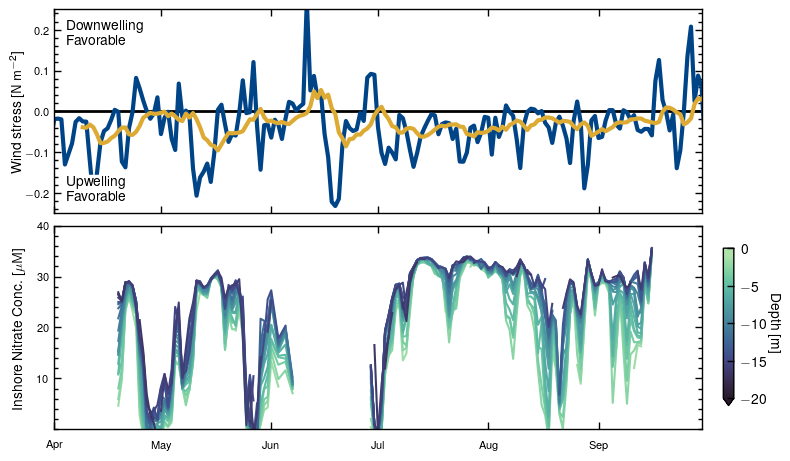

In [ ]:
# single year time series
# plt.
fig, axs = plt.subplots(2, 1, figsize=(7, 4.5), sharex=True, layout="constrained")
temp = wind.where(wind["time.year"] == 2021, drop=True)
(ln1,) = axs[0].plot(temp.time, temp.coare_y, label="Stress", lw=3, zorder=1.8)
(ln2,) = axs[0].plot(
    temp.time, temp.w5d, color="#DDAA33", label="$W_{5d}$", lw=3, zorder=1.8
)
axs[0].axhline(0, ls="-", lw=2, color="black", zorder=1.5)
axs[0].set_ylim(-0.25, 0.25)
# axs2.set_yticks([-50, 0, 100, 200])
# axs2.tick_params(axis='y', which='minor', left=False, top=False)
# axs[0].tick_params(axis='y', which='minor', left=False, top=False)
# fig.tight_layout(pad=0)

axs[0].set_xlim(np.datetime64("2021-04-01"), np.datetime64("2021-09-30"))
axs[0].tick_params(axis="x", which="minor", bottom=False, top=False)


# axs[0].set_zorder(1)  # default zorder is 0 for ax1 and ax2
# axs[0].patch.set_visible(False)  # prevents ax1 from hiding ax2

deployment = np.arange(15, 20, 1)
temp = nitrate.where(nitrate["time.year"] == 2021, drop=True)

cmap = cmo.tools.crop_by_percent(
    cmo.deep, 10, which="min", N=len(temp.depth.where(temp.depth < 21.5, drop=True))
)
cdict = cmo.tools.get_dict(cmap, N=len(temp.depth.where(temp.depth < 21.5, drop=True)))
deep = LinearSegmentedColormap("cmap", cdict)

for i, d in enumerate(temp.depth):
    for j, dep in enumerate(deployment):
        temp_dep = temp.where(temp.deployment == dep).where(temp.nitrate < 38)
        if (len(temp_dep.time) > 0) & (~np.all(np.isnan(temp.sel(depth=d).nitrate))):
            axs[1].plot(
                temp_dep.sel(depth=d).time,
                temp_dep.sel(depth=d).nitrate,
                color=deep((i + 1) / len(nitrate.depth)),
                lw=1.5,
            )

axs[1].tick_params(axis="x", which="major", bottom=True, top=True, pad=8)
myFmt = mdates.DateFormatter("%b")
axs[1].xaxis.set_major_formatter(myFmt)
axs[0].set_ylabel("Wind stress [$\\mathsf{N \\; m^{-2}}$]", labelpad=0)

# axs[1].set_xlim(temp.time[0], temp.time[-1])
axs[1].tick_params(axis="x", which="minor", bottom=False, top=False)
axs[1].set_ylim(0, 40)
axs[1].set_yticks([10, 20, 30, 40])
axs[1].set_ylabel("Inshore Nitrate Conc. [$\\mathsf{\\mu M}$]", labelpad=0)
fig.align_ylabels(axs)


# plt.tight_layout()
deep_r = cmo.tools.crop_by_percent(
    cmo.deep_r, 10, which="max", N=len(temp.depth.where(temp.depth < 21.5, drop=True))
)
cax = fig.add_axes(
    rect=(
        axs[1].get_position().x0 + 0.9,
        axs[1].get_position().y0,
        0.015,
        axs[1].get_position().height,
    )
)
scm = plt.cm.ScalarMappable(cmap=deep_r, norm=plt.Normalize(vmin=-20, vmax=0))
cbar = fig.colorbar(scm, cax=cax, ax=axs, fraction=0.01, extend="min")
cbar.ax.tick_params(labelsize=10, pad=5)
cbar.ax.minorticks_off()
# cbar.ax.get_yaxis().set_ticks([0, -5, -10, -15, -20])
# cbar.ax.get_yaxis().set_ticklabels([0, '', '10', '', '20'])
cbar.set_label("Depth [m]", labelpad=10, rotation=270)
# cbar.ax.tick_params(labelsize=40)

axs[0].text(
    0.02,
    0.05,
    "Upwelling\nFavorable",
    bbox=dict(facecolor="white", alpha=1, edgecolor="white", boxstyle="round,pad=0."),
    transform=axs[0].transAxes,
    va="bottom",
    ha="left",
    zorder=2,
)
axs[0].text(
    0.02,
    0.95,
    "Downwelling\nFavorable",
    bbox=dict(facecolor="white", alpha=1, edgecolor="white", boxstyle="round,pad=0."),
    transform=axs[0].transAxes,
    va="top",
    ha="left",
    zorder=2,
)


# if savefigs:
#     plt.savefig(
#         "../../figs/nitrate-wind_manuscript_figs/wind-nitrate_time_series_w8d.png",
#         dpi=600,
#     )

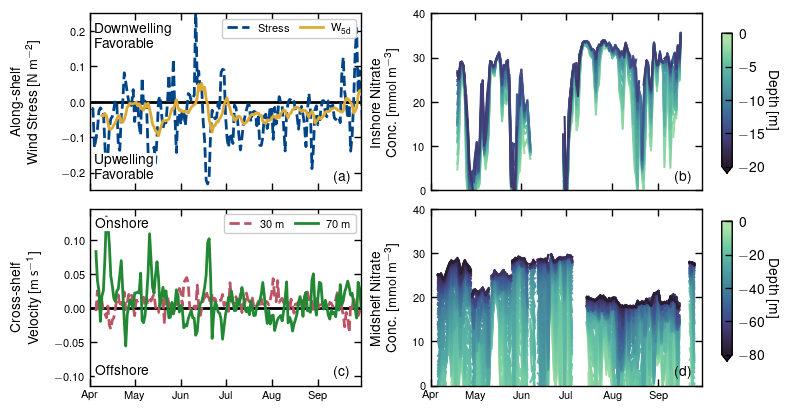

In [ ]:
# single year time series
fig, axs = plt.subplots(2, 2, figsize=(7, 4), sharex=True, layout="constrained")

temp = wind.where(wind["time.year"] == 2021, drop=True)
fig.align_ylabels(axs)
axs[0, 0].plot(temp.time, temp.coare_y, "--", label="Stress", zorder=1.8)
axs[0, 0].plot(
    temp.time, temp.w5d, color="#DDAA33", label=r"$\mathrm{W_{5d}}$", zorder=1.8
)
axs[0, 0].axhline(0, ls="-", lw=2, color="black", zorder=1.5)
axs[0, 0].set_ylim(-0.25, 0.25)
axs[0, 0].set_xlim(np.datetime64("2021-04-01"), np.datetime64("2021-09-30"))
axs[0, 0].tick_params(axis="x", which="minor", bottom=False, top=False)
axs[0, 0].text(
    0.02,
    0.05,
    "Upwelling\nFavorable",
    bbox=dict(facecolor="white", alpha=1, edgecolor="white", boxstyle="round,pad=0."),
    transform=axs[0, 0].transAxes,
    va="bottom",
    ha="left",
    zorder=2,
)
axs[0, 0].text(
    0.02,
    0.95,
    "Downwelling\nFavorable",
    bbox=dict(facecolor="white", alpha=1, edgecolor="white", boxstyle="round,pad=0."),
    transform=axs[0, 0].transAxes,
    va="top",
    ha="left",
    zorder=2,
)
axs[0, 0].set_ylabel("Along-shelf\nWind Stress [$\\mathsf{N\\;m^{-2}}$]")
axs[0, 0].legend(
    ncols=2, loc="upper right", frameon=True, framealpha=1, columnspacing=1
)


axs[1, 0].axhline(0, zorder=1.5, color="k")
axs[1, 0].plot(
    velocity_nh10.where(velocity_nh10["time.year"] == 2021, drop=True).time,
    velocity_nh10.where(velocity_nh10["time.year"] == 2021, drop=True).sel(depth=30).cs,
    "--",
    label="30 m",
    color="#BB5566",
)
axs[1, 0].plot(
    velocity_nh10.where(velocity_nh10["time.year"] == 2021, drop=True).time,
    velocity_nh10.where(velocity_nh10["time.year"] == 2021, drop=True).sel(depth=70).cs,
    label="70 m",
    color="#228833",
)
axs[1, 0].set_ylabel("Cross-shelf\nVelocity [$\\mathsf{m \\; s^{-1}}$]")
axs[1, 0].legend(
    ncols=2, loc="upper right", frameon=True, framealpha=1, columnspacing=1
)
axs[1, 0].text(
    0.02,
    0.05,
    "Offshore",
    bbox=dict(facecolor="white", alpha=1, edgecolor="white", boxstyle="round,pad=0."),
    transform=axs[1, 0].transAxes,
    va="bottom",
    ha="left",
    zorder=2,
)
axs[1, 0].text(
    0.02,
    0.95,
    "Onshore",
    bbox=dict(facecolor="white", alpha=1, edgecolor="white", boxstyle="round,pad=0."),
    transform=axs[1, 0].transAxes,
    va="top",
    ha="left",
    zorder=2,
)


deployment = np.arange(15, 20, 1)
temp = nitrate.where(nitrate["time.year"] == 2021, drop=True)
cmap = cmo.tools.crop_by_percent(
    cmo.deep, 10, which="min", N=len(temp.depth.where(temp.depth < 21.5, drop=True))
)
cdict = cmo.tools.get_dict(cmap, N=len(temp.depth.where(temp.depth < 21.5, drop=True)))
deep = LinearSegmentedColormap("cmap", cdict)
for i, d in enumerate(temp.depth):
    for j, dep in enumerate(deployment):
        temp_dep = temp.where(temp.deployment == dep).where(temp.nitrate < 38)
        if (len(temp_dep.time) > 0) & (~np.all(np.isnan(temp.sel(depth=d).nitrate))):
            axs[0, 1].plot(
                temp_dep.sel(depth=d).time,
                temp_dep.sel(depth=d).nitrate,
                color=deep((i + 1) / len(nitrate.depth)),
                lw=1.5,
            )

myFmt = mdates.DateFormatter("%b")
axs[0, 1].xaxis.set_major_formatter(myFmt)
axs[0, 1].set_ylim(0, 40)
axs[0, 1].set_yticks([0, 10, 20, 30, 40])
axs[0, 1].set_ylabel("Inshore Nitrate\nConc. [$\\mathsf{mmol \\; m^{-3}}$]")
# fig.align_ylabels(axs)
deep_r = cmo.tools.crop_by_percent(
    cmo.deep_r, 10, which="max", N=len(temp.depth.where(temp.depth < 21.5, drop=True))
)
cax = fig.add_axes(
    rect=(
        axs[0, 1].get_position().x0 + 0.475,
        axs[0, 1].get_position().y0 + 0.05,
        0.015,
        axs[0, 1].get_position().height,
    )
)
scm = plt.cm.ScalarMappable(cmap=deep_r, norm=plt.Normalize(vmin=-20, vmax=0))
cbar = fig.colorbar(scm, cax=cax, fraction=0.01, extend="min")
cbar.ax.tick_params(labelsize=10, pad=5)
cbar.ax.minorticks_off()
cbar.ax.get_yaxis().set_ticks([0, -5, -10, -15, -20])
cbar.set_label("Depth [m]", labelpad=10, rotation=270)
# cbar.ax.tick_params(labelsize=40)


deployment = np.unique(midshelf_nitrate.deployment)
temp = midshelf_nitrate.where(midshelf_nitrate["time.year"] == 2021, drop=True)
cmap = cmo.tools.crop_by_percent(
    cmo.deep, 10, which="min", N=len(temp.depth.where(temp.depth < 21.5, drop=True))
)
cdict = cmo.tools.get_dict(cmap, N=len(temp.depth.where(temp.depth < 21.5, drop=True)))
deep = LinearSegmentedColormap("cmap", cdict)
for i, d in enumerate(temp.depth):
    for j, dep in enumerate(deployment):
        temp_dep = temp.where(temp.deployment == dep)
        if (len(temp_dep.time) > 0) & (~np.all(np.isnan(temp.sel(depth=d).nitrate))):
            axs[1, 1].plot(
                temp_dep.sel(depth=d).time,
                temp_dep.sel(depth=d).nitrate,
                color=deep((i + 1) / len(midshelf_nitrate.depth)),
                lw=1.5,
            )
myFmt = mdates.DateFormatter("%b")
axs[1, 1].xaxis.set_major_formatter(myFmt)
axs[1, 1].set_ylim(0, 40)
axs[1, 1].set_yticks([0, 10, 20, 30, 40])
axs[1, 1].set_ylabel("Midshelf Nitrate\nConc. [$\\mathsf{mmol \\; m^{-3}}$]")
deep_r = cmo.tools.crop_by_percent(
    cmo.deep_r, 10, which="max", N=len(temp.depth.where(temp.depth < 21.5, drop=True))
)
cax = fig.add_axes(
    rect=(
        axs[1, 1].get_position().x0 + 0.475,
        axs[1, 1].get_position().y0,
        0.015,
        axs[1, 1].get_position().height,
    )
)
scm = plt.cm.ScalarMappable(cmap=deep_r, norm=plt.Normalize(vmin=-80, vmax=0))
cbar = fig.colorbar(scm, cax=cax, fraction=0.01, extend="min")
cbar.ax.tick_params(labelsize=10, pad=5)
cbar.ax.minorticks_off()
cbar.ax.get_yaxis().set_ticks([0, -20, -40, -60, -80])
cbar.set_label("Depth [m]", labelpad=10, rotation=270)


axs[0, 0].annotate("(a)", xy=(0.9, 0.05), xycoords="axes fraction", fontsize=10)
axs[0, 1].annotate("(b)", xy=(0.9, 0.05), xycoords="axes fraction", fontsize=10)
axs[1, 0].annotate("(c)", xy=(0.9, 0.05), xycoords="axes fraction", fontsize=10)
axs[1, 1].annotate("(d)", xy=(0.9, 0.05), xycoords="axes fraction", fontsize=10)
axs[0, 0].minorticks_off()
axs[0, 1].minorticks_off()
axs[1, 0].minorticks_off()
axs[1, 1].minorticks_off()

# if savefigs:
#     plt.savefig('../../figs/nitrate-wind_manuscript_figs/wind-nitrate_time_series_w8d.png', dpi=600)
# plt.savefig(
#     "../../figs/nitrate_new_manuscript_figs/wind-nitrate_time_series_w8d.pdf",
#     format="pdf",
#     bbox_inches="tight",
# )

## Wind-Nitrate Relationship

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     1160.
Date:                Thu, 06 Mar 2025   Prob (F-statistic):          3.68e-159
Time:                        18:28:58   Log-Likelihood:                -2848.3
No. Observations:                 823   AIC:                             5701.
Df Residuals:                     821   BIC:                             5710.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8439      0.464     10.446      0.000       3.934       5.754
x1             0.8172      0.024     34.052      0.000       0.770       0.864
==============================================================================
Omnibus:                        1.842   Durbin-Watson:                   0.576
Prob(Omnibus):                  0.398   Jarque-Bera (JB):                1.920
Skew:                           0.106   Prob(JB):                        0.383
Kurtosis:                       2.893   Cond. No.                         33.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

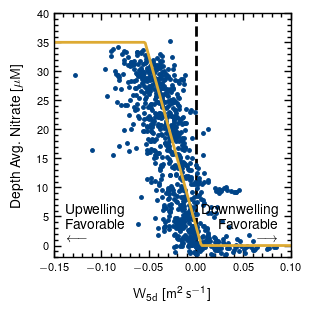

In [ ]:
wind_al_nitrate, nitrate_al_wind = xr.align(wind, nitrate)
# fit[1] = -400
slope = 1 / (fit[0])
intercept = -(-30) * slope

fig, ax = plt.subplots(figsize=(3, 3))
ax.axvline(0, ls="--", color="black")
ax.plot(
    wind_al_nitrate[wind_use],
    nitrate_al_wind["nitrate"].mean(dim="depth", skipna=True),
    ".",
)
ax.set_xlim([-0.15, 0.1])
ax.set_ylim([-2, 40])
ax.set_xlabel("$\\mathsf{W_{5d}}$ [$\\mathsf{m^2 \\; s^{-1}}$]")
ax.set_ylabel("Depth Avg. Nitrate $[\\mathsf{\\mu M}]$")
ax.plot(slope * zf + intercept, mod_nda)
ax.text(
    0.05,
    0.06,
    "Upwelling\nFavorable\n$\\longleftarrow$",
    transform=ax.transAxes,
    fontsize=10,
)
ax.text(
    0.95,
    0.06,
    "Downwelling\nFavorable\n$\\longrightarrow$",
    transform=ax.transAxes,
    fontsize=10,
    ha="right",
)
# plt.savefig('./figs/wind-nitrate2.svg', format='svg', dpi=600)
# R value for wind nitrate relationship
# savefigs = True
# if savefigs:
#     plt.savefig(f'../../figs/nitrate-wind-{wind_use}.png', dpi=600)

# computing r^2 between fit and data
xp = slope * zf + intercept
xp_idx = xp.argsort()
xp = xp[xp_idx]
mod_nda_idx = mod_nda[xp_idx]
mod_nda_interp = np.interp(wind_al_nitrate[wind_use], xp, mod_nda_idx)
mask = ~np.isnan(mod_nda_interp) & ~np.isnan(
    nitrate_al_wind["nitrate"].median(dim="depth", skipna=True)
)
ols_fit = sm.OLS(
    mod_nda_interp[mask],
    sm.add_constant(
        (nitrate_al_wind["nitrate"].median(dim="depth", skipna=True)[mask]).values
    ),
).fit()
bbox = dict(boxstyle="round", fc="w")
# ax.annotate(f'${{R^2={ols_fit.rsquared:.2f}}}$', xy=(0.95, 0.95), xycoords='axes fraction', bbox=bbox, fontsize=10, ha='right', va='top')

# plt.savefig('../../figs/nitrate_new_manuscript_figs/wind-nitrate.pdf', format='pdf', bbox_inches='tight')
ols_fit.summary()

Text(0.95, 0.06, 'Downwelling\nFavorable\n$\\longrightarrow$')

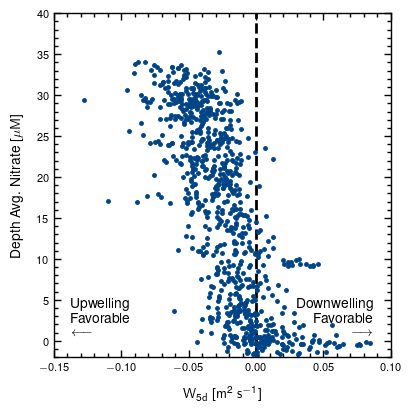

In [ ]:
wind_al_nitrate, nitrate_al_wind = xr.align(wind, nitrate)
slope = 1 / (fit[0])
intercept = -(fit[1]) * slope

fig, ax = plt.subplots(figsize=(4, 4))
ax.axvline(0, ls="--", color="black")
ax.plot(
    wind_al_nitrate[wind_use],
    nitrate_al_wind["nitrate"].median(dim="depth", skipna=True),
    ".",
)
ax.set_xlim([-0.15, 0.1])
ax.set_ylim([-2, 40])
ax.set_xlabel(r"$\mathsf{W_{5d}}$ [$\mathsf{m^2 \ s^{-1}}$]")
ax.set_ylabel(r"Depth Avg. Nitrate $[\mathsf{\mu M}]$")
ax.text(
    0.05,
    0.06,
    "Upwelling\nFavorable\n$\\longleftarrow$",
    transform=ax.transAxes,
    fontsize=10,
)
ax.text(
    0.95,
    0.06,
    "Downwelling\nFavorable\n$\\longrightarrow$",
    transform=ax.transAxes,
    fontsize=10,
    ha="right",
)
# plt.savefig('./figs/wind-nitrate2.svg', format='svg', dpi=600)
# R value for wind nitrate relationship
# savefigs = True
# if savefigs:
#     plt.savefig(f"../../figs/nitrate-wind-{wind_use}.png", dpi=600)

## Correlation between Zf/Nitrate and Wind

In [ ]:
tdelay = np.arange(1, 21)
wkd_correlation_zf = np.nan * np.zeros(tdelay.shape)
for i, t in enumerate(tq(tdelay)):
    fout = np.nan * np.zeros(len(wind["day_num"]))
    for j, f in enumerate(fout):
        temp = util.ws_integrand(
            wind["day_num"].values,
            wind["day_num"].values[j],
            wind["coare_y"].values,
            (t),
        )
        mask = ~np.isnan(temp)
        if np.any(np.isnan(wind.coare_y[j - avg_len * 5 : j])):
            continue
        fout[j] = simpson(temp[mask], x=wind["day_num"].values[: j + 1][mask])
    temp = xr.Dataset(
        data_vars=dict(wkd=(["time"], fout)), coords=dict(time=wind["time"])
    )
    temp_wind, temp_nhl = xr.align(temp, nhl_grid)
    m = util.dt2cal(temp_nhl["time"].values).T[1]
    mask = (temp_nhl["Zf"] < 100) & (temp_nhl["Zf"] > -100)
    summer = (
        (m >= 4)
        & (m <= 9)
        & (mask)
        & (~np.isnan(temp_wind.wkd))
        & (~np.isnan(temp_nhl.Zf))
    )
    wkd_correlation_zf[i] = sm.tsa.stattools.ccf(
        temp_wind["wkd"][summer].values,
        temp_nhl["Zf"][summer].values,
        adjusted=True,
        nlags=1,
    )[0]

100%|██████████| 20/20 [01:52<00:00,  5.61s/it]


In [ ]:
tdelay = np.arange(1, 21)
wkd_correlation_n = np.nan * np.zeros(tdelay.size)
for i, t in enumerate(tq(tdelay)):
    fout = np.nan * np.zeros(len(wind["day_num"]))
    for j, f in enumerate(fout):
        temp = util.ws_integrand(
            wind["day_num"].values,
            wind["day_num"].values[j],
            wind["coare_y"].values,
            (t),
        )
        mask = ~np.isnan(temp)
        if np.any(np.isnan(wind.coare_y[j - avg_len * 5 : j])):
            continue
        fout[j] = simpson(temp[mask], x=wind["day_num"].values[: j + 1][mask])
    temp = xr.Dataset(
        data_vars=dict(wkd=(["time"], fout)), coords=dict(time=wind["time"])
    )
    temp_nitrate, temp_wind = xr.align(nitrate.depth_integrated_nitrate, temp)
    temp_wind = temp_wind["wkd"]
    m = util.dt2cal(temp_wind["time"].values).T[1]
    mask = ~np.isnan(temp_nitrate) & ~np.isnan(temp_wind)
    summer = (m >= 4) & (m <= 9) & (mask)
    wkd_correlation_n[i - 1] = sm.tsa.stattools.ccf(
        temp_nitrate[summer].values, temp_wind[summer].values, adjusted=True, nlags=1
    )[0]

100%|██████████| 20/20 [01:50<00:00,  5.55s/it]


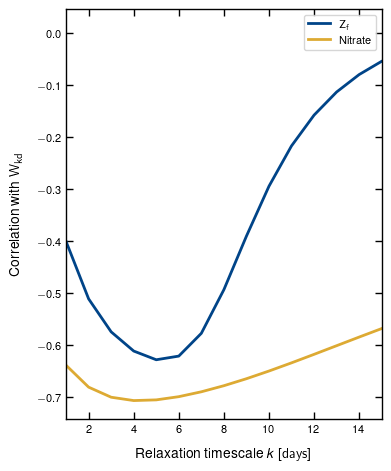

In [ ]:
fig, ax = plt.subplots()
ax.plot(tdelay, wkd_correlation_zf, label=r"$\mathsf{Z_f}$")
ax.plot(tdelay, wkd_correlation_n, label="Nitrate")
ax.set_xlabel(r"Relaxation timescale $k$ [$\mathsf{days}$]")
ax.set_ylabel(r"Correlation with $\mathsf{W_{kd}}$")
ax.legend()
ax.set_xlim([1, 15])
ax.minorticks_off()

# if savefigs:
#     plt.savefig("../../figs/correlation.png", dpi=600)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.513
Model:                            WLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     275.7
Date:                Thu, 06 Mar 2025   Prob (F-statistic):           8.66e-43
Time:                        18:32:42   Log-Likelihood:                -1188.2
No. Observations:                 264   AIC:                             2380.
Df Residuals:                     262   BIC:                             2388.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -18.0970      0.779    -23.240      0.000     -19.630     -16.564
x1          -400.9433     24.149    -16.603      0.000    -448.494    -353.392
==============================================================================
Omnibus:                       72.734   Durbin-Watson:                   1.216
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              156.146
Skew:                          -1.352   Prob(JB):                     1.24e-34
Kurtosis:                       5.623   Cond. No.                         32.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

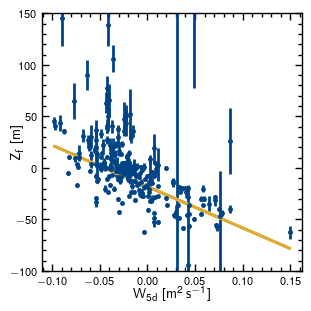

In [ ]:
wind_use = "w5d"
wind_al_nhl, nhl_al_wind = xr.align(wind, nhl_grid)
m = util.dt2cal(nhl_al_wind["time"].values).T[1]
mask = (~np.isnan(nhl_al_wind.Zf)) & (~np.isnan(wind_al_nhl[wind_use]))
wls_fit = sm.WLS(
    nhl_al_wind["Zf"][mask].values,
    sm.add_constant(wind_al_nhl[wind_use][mask].values),
    1 / (nhl_al_wind["Zf_err"][mask].values ** 2),
).fit()
fit = wls_fit.params[::-1]
r_squared = wls_fit.rsquared

fig, ax = plt.subplots(figsize=(3, 3))
ax.errorbar(
    wind_al_nhl[wind_use][mask],
    nhl_al_wind["Zf"][mask],
    nhl_al_wind["Zf_err"][mask],
    linestyle="",
    marker=".",
    elinewidth=2,
)
ax.plot(
    wind_al_nhl[wind_use][mask],
    wind_al_nhl[wind_use][mask] * fit[0] + fit[1],
    label=f"$\\beta_0$={fit[1]:.2f}\n$\\beta_1$={fit[0]:.2f}",
)
ax.set_ylim(-100, 150)
ax.set_xlabel("$\\mathsf{W_{5d}}$ [$\\mathsf{m^2 \\; s^{-1}}$]", labelpad=0)
ax.set_ylabel("$\\mathsf{Z_f}$ [$\\mathsf{m}$]", labelpad=-10)
bbox = dict(boxstyle="round", fc="w")
# ax.annotate(
#     f'$\\beta_0={fit[1]:.2f}$ $\\mathsf{{m}}$\n$\\beta_1={fit[0]:.2f}$ $\\mathsf{{s/m}}$\n${{R^2={r_squared:.2f}}}$',
#     xy=(0.95, 0.95),
#     xycoords='axes fraction',
#     bbox=bbox,
#     fontsize=10,
#     ha='right',
#     va='top'
# )
wls_fit.summary()

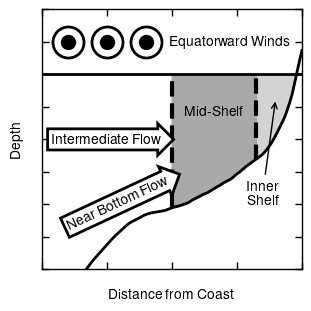

In [ ]:
topo_smoothed = savgol_filter(topo, 100, 1)
plt.figure(figsize=(3, 3))
plt.plot(meters, topo_smoothed, "-", label="s=0", c="k")
plt.xlim(-40, 0)
plt.ylim(-120, 40)
plt.minorticks_off()
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])
bbox = dict(boxstyle="rarrow,pad=0.3", fc="w", ec="k", lw=2)
plt.annotate(
    "Near Bottom Flow",
    xy=(-20, -95),
    fontsize=10,
    bbox=bbox,
    color="k",
    rotation=25,
    ha="right",
)
plt.annotate(
    "Intermediate Flow",
    xy=(-21.5, -40),
    fontsize=10,
    bbox=bbox,
    color="k",
    rotation=0,
    ha="right",
    va="center",
)
plt.annotate(
    "Inner\nShelf",
    xy=(-4, -15),
    xytext=(-6, -80),
    fontsize=10,
    bbox=None,
    color="k",
    rotation=0,
    ha="center",
    arrowprops=dict(arrowstyle="->", color="k"),
)
plt.annotate(
    "Mid-Shelf", xy=(-9, -25), fontsize=10, bbox=None, color="k", rotation=0, ha="right"
)
bbox = dict(boxstyle="larrow,pad=0.3", fc="w", ec="k", lw=2)
# plt.annotate(
#     'Ekman Transport',
#     xy=(-29.5, -12),
#     fontsize=10,
#     bbox=bbox,
#     color='k',
#     rotation=0,
#     ha='center',
# )
plt.axhline(0, color="k")
# plt.axhline(0, color='k')
# plt.axvline(-20, -color='k')
plt.fill_between(
    meters[(meters > -7) & (topo_smoothed < 0)],
    topo_smoothed[(meters > -7) & (topo_smoothed < 0)],
    0,
    color="lightgrey",
)
plt.fill_between(
    meters[(meters > -20) & (meters < -7) & (topo_smoothed < 0)],
    topo_smoothed[(meters > -20) & (meters < -7) & (topo_smoothed < 0)],
    0,
    color="darkgrey",
)
plt.xlabel("Distance from Coast")
plt.ylabel("Depth")
# plt.gca().set_aspect(1)
plt.scatter(
    [-24, -30, -36], [20, 20, 20], s=500, edgecolors="black", c="white", linewidths=2
)
plt.scatter([-24, -30, -36], [20, 20, 20], s=100, c="black")
plt.annotate(
    "Equatorward Winds",
    xy=(-11, 20),
    fontsize=10,
    color="k",
    rotation=0,
    ha="center",
    va="center",
)
plt.axvline(-7, 0.42, 0.75, c="k", ls="--", lw=3)
plt.axvline(-20, 0.24, 0.75, c="k", ls="--", lw=3)
# plt.scatter([-20], [20], s=[100])
# plt.savefig("../../figs/100324_committee_meeting/2d-upwelling-schematic.svg")

## Chlorophyll-Nitrate

In [ ]:
optaa = xr.load_dataset(
    os.path.join(notebook_dir, "../data/CE01ISSM/ce01issm_optaa_processed.nc")
)
flort = xr.load_dataset(
    os.path.join(notebook_dir, "../data/CE01ISSM/ce01issm_flort_processed.nc")
)

flort = flort.drop_dims("stats")
optaa_al, flort_al = xr.align(
    optaa.drop_duplicates("time"), flort.drop_duplicates("time")
)

Text(0.02, 0.5, 'Estimated Chlorophyll [$\\mathrm{mg \\; m^{-3} }$]')

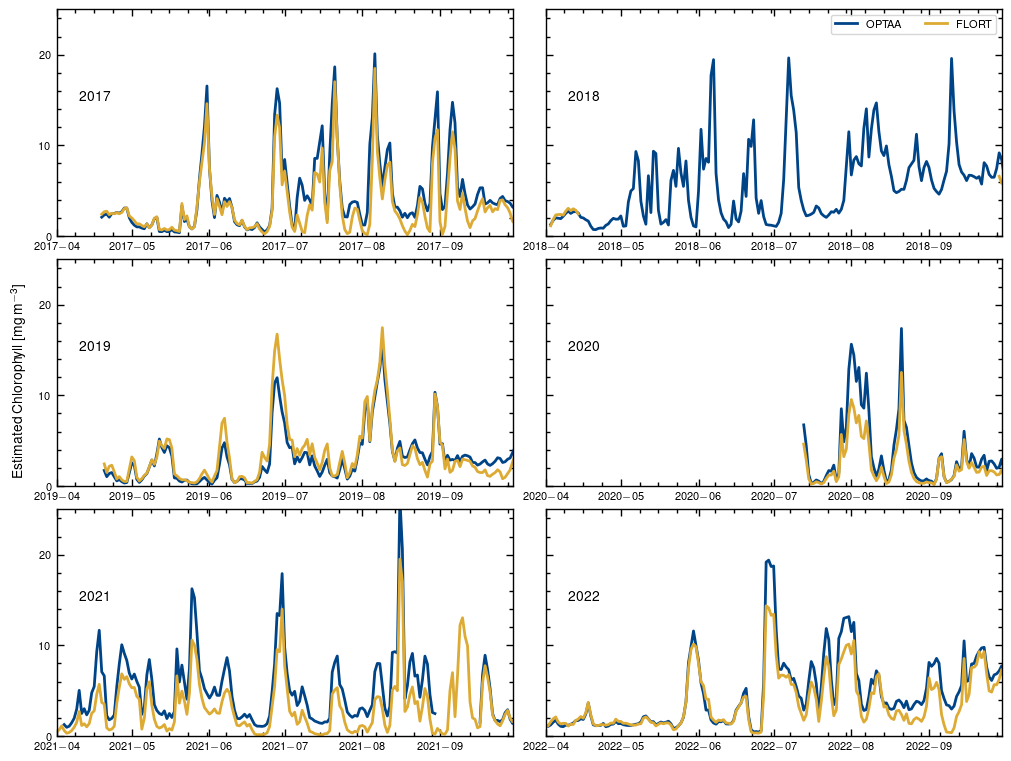

In [ ]:
years = np.arange(np.datetime64("2017"), np.datetime64("2024"), np.timedelta64(1, "Y"))
# years_str = [str(year) for year in years]
fig, axs = plt.subplots((len(years) - 1) // 2, 2, figsize=(10, 7.5), sharey=True)
for i, (ts, te, ax) in enumerate(zip(years[:-1], years[1:], axs.flatten())):
    # print(ts, te)
    temp = optaa.where((optaa.time > ts) & (optaa.time < te), drop=True)
    temp = temp.sortby("time")
    temp = temp.resample(time="1D").mean()
    ax.plot(temp.time, temp.estimated_chlorophyll, linewidth=2, label="OPTAA")

    temp = flort.where((flort.time > ts) & (flort.time < te), drop=True)
    temp = temp.sortby("time")
    temp = temp.resample(time="1D").mean()
    ax.plot(temp.time, temp.estimated_chlorophyll, linewidth=2, label="FLORT")

    ax.set_xlim(
        [
            np.datetime64(f"{years[i]!s}-04-01"),
            np.datetime64(f"{years[i]!s}-09-30"),
        ]
    )
    ax.set_ylim([0, 25])
    ax.annotate(f"{ts}", xy=(0.05, 0.6), xytext=(0.05, 0.6), xycoords="axes fraction")


[ax.set_yticks([0, 10, 20]) for ax in axs.T[0]]


axs[0][1].legend(ncols=2)
fig.supylabel("Estimated Chlorophyll [$\\mathrm{mg \\; m^{-3} }$]")

C:\Users\asche\AppData\Local\Temp\ipykernel_43644\3452499252.py:15: RuntimeWarning: Mean of empty slice
  chloro = np.nanmean(


Text(0, 0.5, '7 meter\nChlorophyll [$\\mathsf{mg \\; m^{-3}}$]')

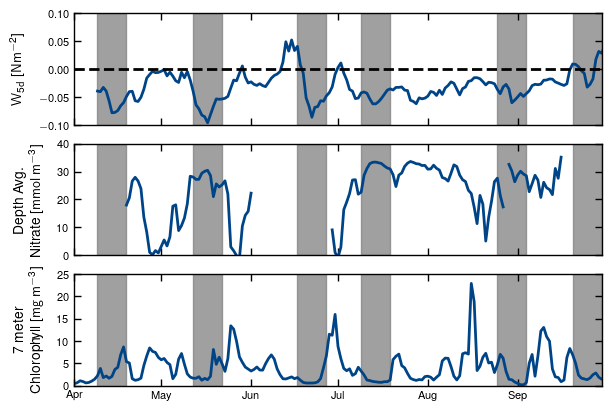

In [ ]:
ts = np.datetime64("2021")
te = np.datetime64("2022")
temp1 = (
    flort.where((flort.time > ts) & (flort.time < te))
    .sortby("time")
    .resample(time="1D")
    .mean()
)
temp2 = (
    optaa.where((optaa.time > ts) & (optaa.time < te))
    .sortby("time")
    .resample(time="1D")
    .mean()
)
chloro = np.nanmean(
    [temp1.estimated_chlorophyll.values, temp2.estimated_chlorophyll.values], axis=0
)
nitr = (
    nitrate.where((nitrate.time > ts) & (nitrate.time < te)).resample(time="1D").mean()
)
fig, axs = plt.subplots(3, 1, figsize=(6, 4), sharex=True)
# [axs[0].axvline(cw.time.values[5], color='gray') for cw in composite_wind_events]

[
    axs[0].fill_betweenx(
        [-0.1, 0.1],
        wind["w5d"].time[idx - 5].values,
        wind["w5d"].time[idx + 5].values,
        color="gray",
        alpha=0.75,
    )
    for idx in find_peaks(-wind["w5d"], height=0.01, distance=20, prominence=0.01)[0]
]
[
    axs[1].fill_betweenx(
        [0, 40],
        wind["w5d"].time[idx - 5].values,
        wind["w5d"].time[idx + 5].values,
        color="gray",
        alpha=0.75,
    )
    for idx in find_peaks(-wind["w5d"], height=0.01, distance=20, prominence=0.01)[0]
]
[
    axs[2].fill_betweenx(
        [0, 30],
        wind["w5d"].time[idx - 5].values,
        wind["w5d"].time[idx + 5].values,
        color="gray",
        alpha=0.75,
    )
    for idx in find_peaks(-wind["w5d"], height=0.01, distance=20, prominence=0.01)[0]
]
axs[0].plot(wind.time, wind["w5d"])
axs[0].set_ylim(-0.1, 0.1)
axs[0].axhline(0, color="black", ls="--")
ln2 = axs[1].plot(
    nitrate.time.resample(time="1D").mean(),
    nitrate.nitrate.mean(dim="depth").resample(time="1D").mean(),
)
ln1 = axs[2].plot(temp1.time, chloro)
axs[1].set_ylim(0, 40)
axs[2].set_ylim(0, 25)
axs[2].set_xlim(np.datetime64(f"{ts!s}-04-01"), np.datetime64(f"{ts!s}-09-30"))
myFmt = mdates.DateFormatter("%b")
axs[2].xaxis.set_major_locator(mdates.MonthLocator())
axs[2].xaxis.set_major_formatter(mdates.DateFormatter("%b"))

[ax.minorticks_off() for ax in axs]
axs[0].set_ylabel("$\\mathsf{W_{5d}}$ [$\\mathsf{N m^{-2}}$]")
axs[1].set_ylabel("Depth Avg.\nNitrate [$\\mathsf{mmol \\; m^{-3}}$]")
axs[2].set_ylabel("7 meter\nChlorophyll [$\\mathsf{mg \\; m^{-3}}$]")

C:\Users\asche\AppData\Local\Temp\ipykernel_43644\4023488902.py:15: RuntimeWarning: Mean of empty slice
  chloro = np.nanmean(


Text(0, 0.5, '7 meter\nChlorophyll [$\\mathsf{mg \\; m^{-3}}$]')

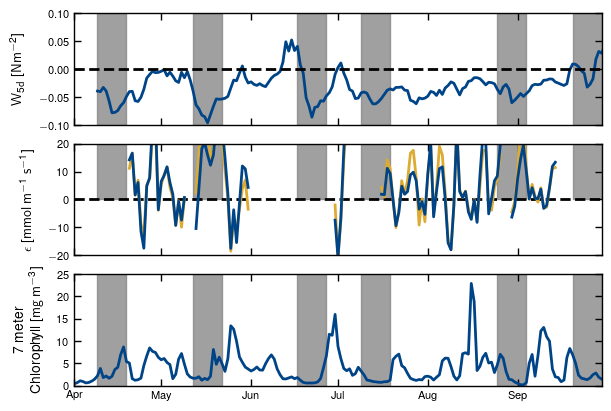

In [ ]:
ts = np.datetime64("2021")
te = np.datetime64("2022")
temp1 = (
    flort.where((flort.time > ts) & (flort.time < te))
    .sortby("time")
    .resample(time="1D")
    .mean()
)
temp2 = (
    optaa.where((optaa.time > ts) & (optaa.time < te))
    .sortby("time")
    .resample(time="1D")
    .mean()
)
chloro = np.nanmean(
    [temp1.estimated_chlorophyll.values, temp2.estimated_chlorophyll.values], axis=0
)
nitr = (
    nitrate.where((nitrate.time > ts) & (nitrate.time < te)).resample(time="1D").mean()
)
fig, axs = plt.subplots(3, 1, figsize=(6, 4), sharex=True)
# [axs[0].axvline(cw.time.values[5], color='gray') for cw in composite_wind_events]

[
    axs[0].fill_betweenx(
        [-0.1, 0.1],
        wind["w5d"].time[idx - 5].values,
        wind["w5d"].time[idx + 5].values,
        color="gray",
        alpha=0.75,
    )
    for idx in find_peaks(-wind["w5d"], height=0.01, distance=20, prominence=0.01)[0]
]
[
    axs[1].fill_betweenx(
        [0, 40],
        wind["w5d"].time[idx - 5].values,
        wind["w5d"].time[idx + 5].values,
        color="gray",
        alpha=0.75,
    )
    for idx in find_peaks(-wind["w5d"], height=0.01, distance=20, prominence=0.01)[0]
]
[
    axs[2].fill_betweenx(
        [0, 30],
        wind["w5d"].time[idx - 5].values,
        wind["w5d"].time[idx + 5].values,
        color="gray",
        alpha=0.75,
    )
    for idx in find_peaks(-wind["w5d"], height=0.01, distance=20, prominence=0.01)[0]
]
axs[0].plot(wind.time, wind["w5d"])
axs[0].set_ylim(-0.1, 0.1)
axs[0].axhline(0, color="black", ls="--")
axs[1].axhline(0, ls="--", color="black")
temp_flux, temp_inner, temp_mid = xr.align(
    velocity_nh10_flux.nitrate_flux_depth_integrated,
    nitrate.dropna("depth", how="all"),
    midshelf_nitrate.dropna("depth", how="all"),
)
axs[1].plot(
    temp_flux.time,
    (temp_flux - temp_inner.dndt * 7000 / 2 - temp_mid.dndt * 13000 / 2),
    "-",
    label="Monthly Mean Nitrate Profiles",
    color="#DDAA33",
)
temp_flux, temp_inner, temp_mid = xr.align(
    midshelf_nitrate_flux_depth_integrated,
    nitrate.dropna("depth", how="all"),
    midshelf_nitrate.dropna("depth", how="all"),
)
axs[1].plot(
    temp_flux.time,
    (temp_flux - temp_inner.dndt * 7000 / 2 - temp_mid.dndt * 13000 / 2),
    "-",
    label="Actual Nitrate Profiles",
    color="#004488",
)
ln1 = axs[2].plot(temp1.time, chloro)
axs[1].set_ylim(-20, 20)
axs[2].set_ylim(0, 25)
axs[2].set_xlim(np.datetime64(f"{ts!s}-04-01"), np.datetime64(f"{ts!s}-09-30"))
myFmt = mdates.DateFormatter("%b")
axs[2].xaxis.set_major_locator(mdates.MonthLocator())
axs[2].xaxis.set_major_formatter(mdates.DateFormatter("%b"))

[ax.minorticks_off() for ax in axs]
axs[0].set_ylabel("$\\mathsf{W_{5d}}$ [$\\mathsf{N m^{-2}}$]")
axs[1].set_ylabel("$\\epsilon$ [$\\mathsf{mmol \\; m^{-1} \\; s^{-1}}$]")
axs[2].set_ylabel("7 meter\nChlorophyll [$\\mathsf{mg \\; m^{-3}}$]")

C:\Users\asche\AppData\Local\Temp\ipykernel_43644\3119559374.py:15: RuntimeWarning: Mean of empty slice
  chloro = np.nanmean(


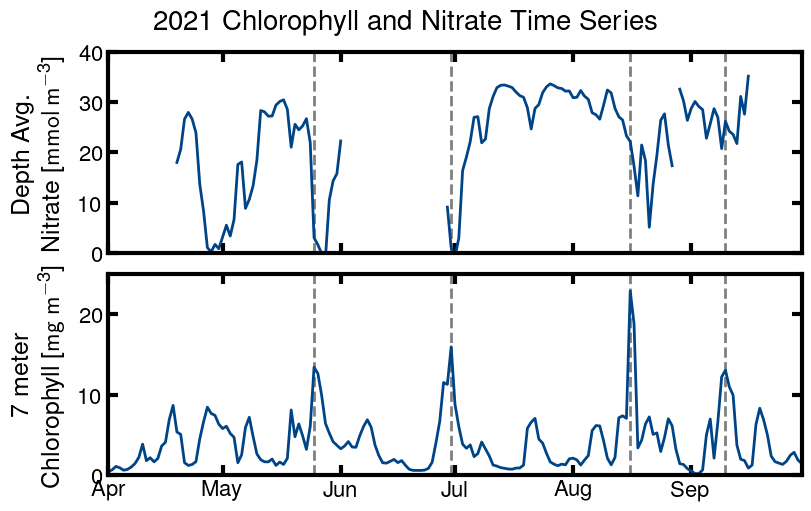

In [ ]:
ts = np.datetime64("2021")
te = np.datetime64("2022")
temp1 = (
    flort.where((flort.time > ts) & (flort.time < te))
    .sortby("time")
    .resample(time="1D")
    .mean()
)
temp2 = (
    optaa.where((optaa.time > ts) & (optaa.time < te))
    .sortby("time")
    .resample(time="1D")
    .mean()
)
chloro = np.nanmean(
    [temp1.estimated_chlorophyll.values, temp2.estimated_chlorophyll.values], axis=0
)
nitr = (
    nitrate.where((nitrate.time > ts) & (nitrate.time < te)).resample(time="1D").mean()
)
fig, axs = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
plt.suptitle("2021 Chlorophyll and Nitrate Time Series", fontsize=20)
# [axs[0].axvline(cw.time.values[5], color='gray') for cw in composite_wind_events]
[
    axs[0].axvline(x.values, c="gray", ls="--")
    for x in temp1.time[find_peaks(chloro, height=5, distance=1, prominence=10)[0]]
]
[
    axs[1].axvline(x.values, c="gray", ls="--")
    for x in temp1.time[find_peaks(chloro, height=5, distance=1, prominence=10)[0]]
]
# [axs[2].axvline(x.values, c='gray', ls='--') for x in temp1.time[find_peaks(chloro, height=5, distance=1, prominence=10)[0]]]
# [axs[0].axvline(wind['w5d'].time[idx-5].values, wind['w5d'].time[idx+5].values, color='gray', alpha=0.75) for idx in find_peaks(-wind['w5d'], height=0.01, distance=20, prominence=0.01)[0]]
# [axs[1].fill_betweenx([0, 40], wind['w5d'].time[idx-5].values, wind['w5d'].time[idx+5].values, color='gray', alpha=0.75) for idx in find_peaks(-wind['w5d'], height=0.01, distance=20, prominence=0.01)[0]]
# [axs[2].fill_betweenx([0, 30], wind['w5d'].time[idx-5].values, wind['w5d'].time[idx+5].values, color='gray', alpha=0.75) for idx in find_peaks(-wind['w5d'], height=0.01, distance=20, prominence=0.01)[0]]
# axs[0].plot(wind.time, wind['coare_y'])
# axs[0].set_ylim(-0.1, 0.1)
# axs[0].axhline(0, color='black')
ln2 = axs[0].plot(
    nitrate.time.resample(time="1D").mean(),
    nitrate.nitrate.mean(dim="depth").resample(time="1D").mean(),
)
ln1 = axs[1].plot(temp1.time, chloro)
axs[0].set_ylim(0, 40)
axs[1].set_ylim(0, 25)
axs[1].set_xlim(np.datetime64(f"{ts!s}-04-01"), np.datetime64(f"{ts!s}-09-30"))
myFmt = mdates.DateFormatter("%b")
axs[1].xaxis.set_major_locator(mdates.MonthLocator())
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%b"))

[ax.minorticks_off() for ax in axs]
# axs[0].set_ylabel('$\\mathsf{W_{5d}}$ [$\\mathsf{N m^{-2}}$]', fontsize=18)
axs[0].set_ylabel("Depth Avg.\nNitrate [$\\mathsf{mmol \\; m^{-3}}$]", fontsize=18)
axs[1].set_ylabel("7 meter\nChlorophyll [$\\mathsf{mg \\; m^{-3}}$]", fontsize=18)

[ax.tick_params(axis="both", width=3, size=7, labelsize=16) for ax in axs]
[ax.tick_params(axis="both", which="minor", width=2, size=5) for ax in axs]

for axis in ["top", "bottom", "left", "right"]:
    [ax.spines[axis].set_linewidth(3) for ax in axs]

# plt.savefig("../../figs/agu24/chloro-nitrate.svg")

Text(0, 0.5, 'Depth-Averaged Nitrate Conc. [$\\mathsf{mmol \\; m^{-3}}$]')

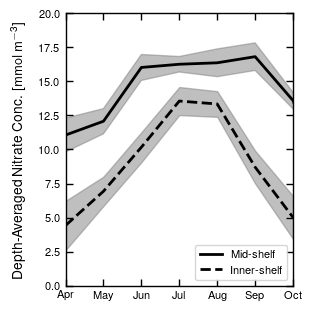

In [ ]:
midshelf_depth_integrate = midshelf_nitrate.copy()
fig, axs = plt.subplots(1, 1, figsize=(3, 3), sharex=True)
axs.plot(
    midshelf_depth_integrate["depth_integrated_nitrate"]
    .groupby("time.month")
    .mean(dim="time")
    .month,
    midshelf_depth_integrate["depth_integrated_nitrate"]
    .groupby("time.month")
    .mean(dim="time")
    / 80,
    color="black",
    label="Mid-shelf",
)
axs.fill_between(
    midshelf_depth_integrate["depth_integrated_nitrate"]
    .groupby("time.month")
    .mean(dim="time")
    .month,
    midshelf_depth_integrate["depth_integrated_nitrate"]
    .groupby("time.month")
    .mean(dim="time")
    / 80
    - (
        midshelf_depth_integrate["depth_integrated_nitrate"]
        .groupby("time.month")
        .std(dim="time")
        / np.sqrt(
            midshelf_depth_integrate["depth_integrated_nitrate"]
            .groupby("time.month")
            .count("time")
        )
        * distributions.t(
            midshelf_depth_integrate["depth_integrated_nitrate"]
            .groupby("time.month")
            .count("time")
            - 1
        ).isf(0.025)
    )
    / 80,
    midshelf_depth_integrate["depth_integrated_nitrate"]
    .groupby("time.month")
    .mean(dim="time")
    / 80
    + (
        midshelf_depth_integrate["depth_integrated_nitrate"]
        .groupby("time.month")
        .std(dim="time")
        / np.sqrt(
            midshelf_depth_integrate["depth_integrated_nitrate"]
            .groupby("time.month")
            .count("time")
        )
        * distributions.t(
            midshelf_depth_integrate["depth_integrated_nitrate"]
            .groupby("time.month")
            .count("time")
            - 1
        ).isf(0.025)
    )
    / 80,
    alpha=0.5,
    color="gray",
)

axs.plot(
    nitrate["depth_integrated_nitrate"].groupby("time.month").mean(dim="time").month,
    nitrate["depth_integrated_nitrate"].groupby("time.month").mean(dim="time") / 25,
    color="black",
    ls="--",
    label="Inner-shelf",
)
axs.fill_between(
    nitrate["depth_integrated_nitrate"].groupby("time.month").mean(dim="time").month,
    nitrate["depth_integrated_nitrate"].groupby("time.month").mean(dim="time") / 25
    - (
        nitrate["depth_integrated_nitrate"].groupby("time.month").std(dim="time")
        / np.sqrt(
            nitrate["depth_integrated_nitrate"].groupby("time.month").count("time")
        )
        * distributions.t(
            nitrate["depth_integrated_nitrate"].groupby("time.month").count("time") - 1
        ).isf(0.025)
    )
    / 25,
    nitrate["depth_integrated_nitrate"].groupby("time.month").mean(dim="time") / 25
    + (
        nitrate["depth_integrated_nitrate"].groupby("time.month").std(dim="time")
        / np.sqrt(
            nitrate["depth_integrated_nitrate"].groupby("time.month").count("time")
        )
        * distributions.t(
            nitrate["depth_integrated_nitrate"].groupby("time.month").count("time") - 1
        ).isf(0.025)
    )
    / 25,
    alpha=0.5,
    color="gray",
)

axs.set_xlim(4, 10)
axs.set_ylim(0, 20)
axs.minorticks_off()
axs.legend(loc="lower right")
# axs.xaxis.set_major_locator(mdates.MonthLocator())
axs.xaxis.set_major_formatter(lambda x, pos: calendar.month_abbr[int(x)])
# axs.set_xlabel('Month')
axs.set_ylabel("Depth-Averaged Nitrate Conc. [$\\mathsf{mmol \\; m^{-3}}$]")
# plt.savefig(
#     "../../figs/nitrate_new_manuscript_figs/nitrate_seasonal_cycle.pdf",
#     format="pdf",
#     bbox_inches="tight",
# )